In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import math
import copy
import seaborn as sn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [96]:
(X_train, Y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=10)

x_train_norm  = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])/255
x_test_norm = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])/255
x_val_norm = x_val.reshape(len(x_val), x_val.shape[1]*x_val.shape[2])/255 

y_train_enc = np.zeros((y_train.size, 10))
y_train_enc[np.arange(y_train.size), y_train] = 1
y_val_enc = np.zeros((y_val.size, 10))
y_val_enc[np.arange(y_val.size), y_val] = 1
y_test_enc = np.zeros((y_test.size, 10))
y_test_enc[np.arange(y_test.size), y_test] = 1

#### WandB setup

In [37]:
!pip install wandb
import wandb

In [38]:
!wandb login

wandb: Currently logged in as: ph23m012 (team_zulkar). Use `wandb login --relogin` to force relogin


In [39]:

entity_name="team_zulkar"

project_name="cs6910-Zulkar"

In [40]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Question - 1

In [107]:
def plot_labels():
    class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

    images = []
    labels = []

    for i in  range(10):
        for j in range(len(y_train)):
            if y_train[j] == i:
                images.append(x_train[j])
                labels.append(class_names[i])
                break
    fig, axis = plt.subplots(2, 5, figsize=(12,5))
    plt.suptitle("Images with Labels from Fashion MNIST Dataset")
    for i in  range(10):
        image = images[i]
        label = labels[i]
        if i <= 4:
         axis[0][i].imshow(image, cmap='gray')
         axis[0][i].set_title(label)
         axis[0][i].axis('off')
        else:
         i = i - 5
         axis[1][i].imshow(image, cmap='gray')
         axis[1][i].set_title(label)
         axis[1][i].axis('off') 

    plt.show()
    

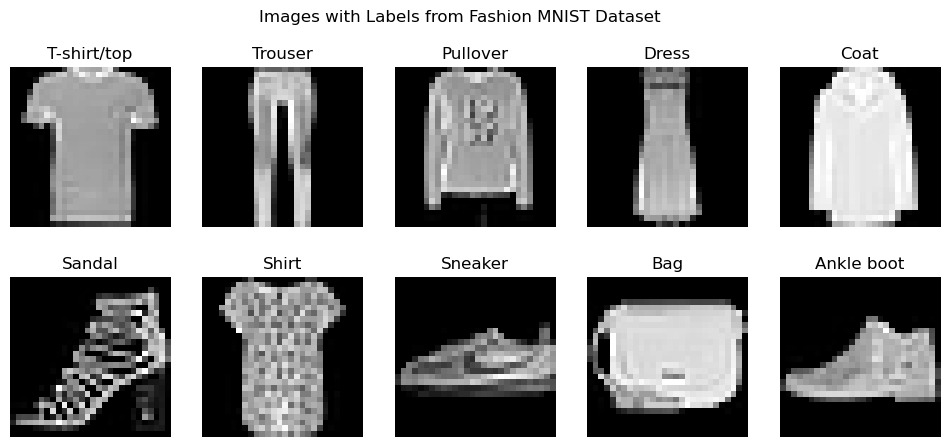

In [108]:
plot_labels()

#### Weights and Biases initialization (random or xavier)

In [43]:
def random(layers_and_neurons):
    params = {}
    for i in range(1, len(layers_and_neurons)):
        params["w"+str(i)]=0.01*np.random.randn(layers_and_neurons[i], layers_and_neurons[i-1])
        params["b"+str(i)]=0.01*np.random.randn(layers_and_neurons[i],1) 
    
    return params



In [44]:
def xavier(layers_and_neurons):
    params = {}
    for i in range(1, len(layers_and_neurons)):
        norm_xav=np.sqrt(6)/np.sqrt(layers_and_neurons[i-1]+layers_and_neurons[i])
        params["w"+str(i)]=0.01*np.random.randn(layers_and_neurons[i], layers_and_neurons[i-1])*norm_xav
        params["b"+str(i)]=0.01*np.random.randn(layers_and_neurons[i],1) 
    
    return params

#### Activation functions and there derivatives

In [45]:
def sigmoid(pre_act):
 return (1.0/(1.0+np.exp(-pre_act)))

def tanh(pre_act):
  return (np.tanh(pre_act))

def relu(pre_act):
  return (np.maximum(0,pre_act))
     
def softmax(x):
    
    return(np.exp(x)/np.sum(np.exp(x)))

def der_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))
     

def der_tanh(x):
  return 1.0 -tanh(x)**2

     
def der_relu(x):
  return 1. * (x>0)
     

def der_softmax(x):
  return softmax(x) * (1-softmax(x))

## Question - 2

#### Forward Propagation

In [46]:
def forward_prop(x, act_func, param, layers_and_neurons):
    x_temp = x.reshape(-1,1)
    a = [x_temp]
    h = [x_temp]
    if (act_func == "sigmoid"):
        for i in range(1, len(layers_and_neurons)-1):
            weights = param["w"+str(i)]
            biases = param["b"+str(i)]
            temp_a = biases + np.dot(weights,h[i-1])
            a.append(temp_a)
            temp_h = sigmoid(temp_a)
            h.append(temp_h)
            
    elif(act_func == "tanh"):
        for i in range(1, len(layers_and_neurons)-1):
            weights = param["w"+str(i)]
            biases = param["b"+str(i)]
            temp_a = biases + np.dot(weights,h[i-1])
            a.append(temp_a)
            temp_h = tanh(temp_a)
            h.append(temp_h)
            
    elif(act_func == "relu"):
        for i in range(1, len(layers_and_neurons)-1):
            weights = param["w"+str(i)]
            biases = param["b"+str(i)]
            temp_a = biases + np.dot(weights,h[i-1])
            a.append(temp_a)
            temp_h = relu(temp_a)
            h.append(temp_h)
    
    else:
        print("Activation function is not valid")
    
    
    #final layer output function
    
    weights = param["w"+str(len(layers_and_neurons)-1)]
    biases = param["b"+str(len(layers_and_neurons)-1)]
    temp_a = biases + np.dot(weights, h[len(layers_and_neurons)-2])
    a.append(temp_a)
    temp_h = softmax(temp_a)
    h.append(temp_h)
    y_hat = temp_h
    
    return a,h,y_hat

#### Loss and Accuracy Calculation

In [47]:
#Loss

def loss_calc(y, y_hat, loss_name, lambd, layers_and_neurons, params):

 
 
  
  error=0
  if(loss_name == "mse"):
    error=np.sum(((y - y_hat)**2) / (2 * len(y)))
  elif(loss_name == "cross entropy"):
    error= - np.sum( np.multiply(y , np.log(y_hat)))/len(y)

  #For L2 Regularization
  regularized_error = 0.0
  for i in range(len(layers_and_neurons)-1, 0, -1):
    regularized_error += (np.sum(params["w"+str(i)]))**2
  regularized_error = error + ((lambd/(2*len(y)))*(regularized_error))


  return regularized_error

In [48]:
#Accuracy

def acc_calc(y, y_hat):

  

  acc=0.0

  for i in range(len(y_hat)):
    if(y_hat[i].argmax()==y[i]):
      acc+=1
  acc=acc/len(y)
  return(acc*100)

#### Prediction

In [49]:
def pred_func(x, y, params, activ_func, layers_and_neurons):


  prediction = []

  #Iterate over all the data points in the given data set
  for i in range(len(x)):

    #forward propagation
    h,a,y_hat = forward_prop(x[i], activ_func, params, layers_and_neurons)

    #flattening y_hat to 1d array 
    y_hat = y_hat.flatten()

    #storing the result into the result list
    prediction.append(y_hat)
  
  return prediction


## Question - 3

#### Backward Propagation

In [50]:
def backward_prop(y, y_hat, h, a, params, loss_type, layers_and_neurons, active):
    #one hot encoded y_train
    y_enc = np.zeros((y.size, 10))
    y_enc[np.arange(y.size), y] = 1
    y_enc = y_enc.reshape(10,1)
    
    #required gradients
    grad = {}
    #output gradients
    if (loss_type == "cross entropy"):
        grad["dh"+str(len(layers_and_neurons)-1)] = -y_enc/y_hat
        grad["da"+str(len(layers_and_neurons)-1)] = -(y_enc-y_hat)
    elif (loss_type == "mse"):
        grad["dh"+str(len(layers_and_neurons)-1)] = (y_hat - y_enc)
        grad["da"+str(len(layers_and_neurons)-1)] = (y_hat - y_enc) * der_softmax(a[len(layers_and_neurons)-1])
    else:
        print("Type valid loss type")
    
    
    
    for i in range(len(layers_and_neurons)-1,0,-1):
        
        # parameters gradients
        grad["dw"+str(i)] = np.dot(grad["da"+str(i)], np.transpose(h[i-1]))
        grad["db"+str(i)] = grad["da"+str(i)]
        
        # gradients w.r.t. layers below (activation)
        
        if i == 1:
            continue
        
        grad["dh"+str(i-1)] = np.dot(np.transpose(params["w"+str(i)]), grad["da"+str(i)])
        
        # gradients w.r.t. layers below (preactivation)
#         if i > 1:
        if (active == "sigmoid"):
            grad["da"+str(i-1)] = np.multiply(grad["dh"+str(i-1)], der_sigmoid(a[i-1]))

        if (active == "tanh"):
            grad["da"+str(i-1)] = np.multiply(grad["dh"+str(i-1)], der_tanh(a[i-1]))

        if (active == "relu"):
            grad["da"+str(i-1)] = np.multiply(grad["dh"+str(i-1)], der_relu(a[i-1]))

    
    return grad

#### Mini Batch Gradient Descent

In [51]:
def mini_gradient_descent(x_train, y_train, params, layers_and_neurons, eta, lambd, max_epochs, mini_batch_size,active_fun,loss_type, wandb_log=False):
    total_grad = {}
    
    loss_train = []
    accuracy_train = []
    loss_val = []
    accuracy_val = []
    
    y_train_enc = np.zeros((y_train.size, 10))
    y_train_enc[np.arange(y_train.size), y_train] = 1
    
    for i in tqdm(range(max_epochs)):
        no_points_seen = 0
        for k in range(1, len(layers_and_neurons)-1):
            total_grad["dw"+str(k)], total_grad["db"+str(k)], = 0, 0 
        for x,y in zip(x_train, y_train):
            # forward prop 
            a,h,y_hat = forward_prop(x, active_fun, params, layers_and_neurons)

            # backward prop
            gradients = backward_prop(y, y_hat, h, a, params, loss_type, layers_and_neurons, active_fun)

            for k in range(1, len(layers_and_neurons)-1):
                total_grad["dw"+str(k)] += gradients["dw"+str(k)]
                total_grad["db"+str(k)] += gradients["db"+str(k)]
            no_points_seen += 1
            
            if (no_points_seen%mini_batch_size == 0):
                for k in range(1, len(layers_and_neurons)-1):
                    params["w"+str(k)] = params["w"+str(k)] - eta*total_grad["dw"+str(k)]
                    params["b"+str(k)] = params["b"+str(k)] - eta*total_grad["db"+str(k)]
    
        prediction_t = pred_func(x_train,y_train,params, active_fun, layers_and_neurons)
        prediction_v = pred_func(x_val,y_val,params, active_fun, layers_and_neurons)
        #Loss calculation
        train_error = loss_calc(y_train_enc, prediction_t, loss_type, lambd, layers_and_neurons, params)
        loss_train.append(train_error)
        val_error = loss_calc(y_val_enc, prediction_v, loss_type, lambd, layers_and_neurons, params)
        loss_val.append(val_error)

        #Accuracy calculation
        train_accu = acc_calc(y_train, prediction_t)
        accuracy_train.append(train_accu)
        val_accu = acc_calc(y_val, prediction_v)
        accuracy_val.append(val_accu)
        
        
        
        if(wandb_log==True):  
          # Logging the values into wandb
          log_dict = {"Train_Accuracy": train_accu, "Validation_Accuracy": val_accu, "Train_Loss": train_error, "Validation_loss": val_error, "epoch": i}
                  
          wandb.log(log_dict)
        
        
            
    return params, loss_train, accuracy_train, loss_val, accuracy_val

#### Momentum based gradient descent(Mini Batch Version)

In [52]:
def mbgd(x_train, y_train, params, layers_and_neurons, eta, lambd, max_epochs, mini_batch_size,active_fun,loss_type, wandb_log=False):
    total_grad = {}
    history = {}
    
    loss_train = []
    accuracy_train = []
    loss_val = []
    accuracy_val = []
    
    beta = 0.89
    
    for i in tqdm(range(max_epochs)):
        params["w"+str(0)], params["b"+str(0)], no_points_seen = 0, 0, 0
        for k in range(1, len(layers_and_neurons)-1):
            total_grad["dw"+str(k)], total_grad["db"+str(k)], = 0, 0 
            history["u_w"+str(k)], history["u_b"+str(k)], = 0, 0
        for x,y in zip(x_train, y_train):
            # forward prop 
            a,h,y_hat = forward_prop(x, active_fun, params, layers_and_neurons)

            # backward prop
            gradients = backward_prop(y, y_hat, h, a, params, loss_type, layers_and_neurons, active_fun)

            for k in range(1, len(layers_and_neurons)-1):
                total_grad["dw"+str(k)] += gradients["dw"+str(k)]
                total_grad["db"+str(k)] += gradients["db"+str(k)]
            no_points_seen += 1
            
            if (no_points_seen%mini_batch_size == 0):
                for k in range(1, len(layers_and_neurons)-1):
                    history["u_w"+str(k)] = beta*history["u_w"+str(k)] + total_grad["dw"+str(k)]
                    history["u_b"+str(k)] = beta*history["u_b"+str(k)] + total_grad["db"+str(k)]
                    
                    params["w"+str(k)] = params["w"+str(k)] - eta*history["u_w"+str(k)]
                    params["b"+str(k)] = params["b"+str(k)] - eta*history["u_b"+str(k)]
                    
    
        prediction_t = pred_func(x_train,y_train,params, active_fun, layers_and_neurons)
        prediction_v = pred_func(x_val,y_val,params, active_fun, layers_and_neurons)
        #Loss calculation
        train_error = loss_calc(y_train_enc, prediction_t, loss_type, lambd, layers_and_neurons, params)
        loss_train.append(train_error)
        val_error = loss_calc(y_val_enc, prediction_v, loss_type, lambd, layers_and_neurons, params)
        loss_val.append(val_error)

        #Accuracy calculation
        train_accu = acc_calc(y_train, prediction_t)
        accuracy_train.append(train_accu)
        val_accu = acc_calc(y_val, prediction_v)
        accuracy_val.append(val_accu)
        
        if(wandb_log==True):  
          # Logging the values into wandb
          log_dict = {"Train_Accuracy": train_accu, "Validation_Accuracy": val_accu, "Train_Loss": train_error, "Validation_loss": val_error, "epoch": i}
                  
          wandb.log(log_dict)
            
    return params, loss_train, accuracy_train, loss_val, accuracy_val

#### Nesterov accelerated gradient descent(Mini Batch Version) 

In [53]:
def nagd(x_train, y_train, params, layers_and_neurons, eta, lambd, max_epochs, mini_batch_size,active_fun,loss_type, wandb_log=False):
    total_grad = {}
    history = {}
    params_La = {}
    
    loss_train = []
    accuracy_train = []
    loss_val = []
    accuracy_val = []
    
    beta = 0.89
    
    
    for i in tqdm(range(max_epochs)):
        params["w"+str(0)], params["b"+str(0)], no_points_seen = 0, 0, 0
        for k in range(1, len(layers_and_neurons)-1):
            total_grad["dw"+str(k)], total_grad["db"+str(k)], = 0, 0 
            history["u_w"+str(k)], history["u_b"+str(k)], = 0, 0
        out = 0    
        for x,y in zip(x_train, y_train):
            out += 1 
            # forward prop 
            a,h,y_hat = forward_prop(x, active_fun, params, layers_and_neurons)
            
            #Parameters lookahead
            if (out == 1):
                params_La = copy.deepcopy(params)
            else:
                for k in range(1, len(layers_and_neurons)-1):
                    params_La["w"+str(k)] = params["w"+str(k)] - beta*history["u_w"+str(k)]
                    params_La["b"+str(k)] = params["b"+str(k)]

            # backward prop
            gradients = backward_prop(y, y_hat, h, a, params_La, loss_type, layers_and_neurons, active_fun)

            for k in range(1, len(layers_and_neurons)-1):
                total_grad["dw"+str(k)] += gradients["dw"+str(k)]
                total_grad["db"+str(k)] += gradients["db"+str(k)]
            no_points_seen += 1
            
            if (no_points_seen%mini_batch_size == 0):
                for k in range(1, len(layers_and_neurons)-1):
                    history["u_w"+str(k)] = beta*history["u_w"+str(k)] + total_grad["dw"+str(k)]
                    history["u_b"+str(k)] = beta*history["u_b"+str(k)] + total_grad["db"+str(k)]
                    
                    params["w"+str(k)] = params["w"+str(k)] - eta*history["u_w"+str(k)]
                    params["b"+str(k)] = params["b"+str(k)] - eta*history["u_b"+str(k)]
                    
    
        prediction_t = pred_func(x_train,y_train,params, active_fun, layers_and_neurons)
        prediction_v = pred_func(x_val,y_val,params, active_fun, layers_and_neurons)
        #Loss calculation
        train_error = loss_calc(y_train_enc, prediction_t, loss_type, lambd, layers_and_neurons, params)
        loss_train.append(train_error)
        val_error = loss_calc(y_val_enc, prediction_v, loss_type, lambd, layers_and_neurons, params)
        loss_val.append(val_error)

        #Accuracy calculation
        train_accu = acc_calc(y_train, prediction_t)
        accuracy_train.append(train_accu)
        val_accu = acc_calc(y_val, prediction_v)
        accuracy_val.append(val_accu)
        
        
        if(wandb_log==True):  
          # Logging the values into wandb
          log_dict = {"Train_Accuracy": train_accu, "Validation_Accuracy": val_accu, "Train_Loss": train_error, "Validation_loss": val_error, "epoch": i}
                  
          wandb.log(log_dict)
            
    return params, loss_train, accuracy_train, loss_val, accuracy_val

#### RMSprop

In [54]:
def RMSprop(x_train, y_train, params, layers_and_neurons, eta, lambd, max_epochs, mini_batch_size,active_fun,loss_type, wandb_log=False):
    total_grad = {}
    history = {}
    
    loss_train = []
    accuracy_train = []
    loss_val = []
    accuracy_val = []
    
    epsilon, beta = 1e-8, 0.89
    
    for i in tqdm(range(max_epochs)):
        no_points_seen = 0
        for k in range(1, len(layers_and_neurons)-1):
            total_grad["dw"+str(k)], total_grad["db"+str(k)], = 0, 0 
            history["u_w"+str(k)], history["u_b"+str(k)], = 0, 0
        for x,y in zip(x_train, y_train):
            # forward prop 
            a,h,y_hat = forward_prop(x, active_fun, params, layers_and_neurons)
            

            # backward prop
            gradients = backward_prop(y, y_hat, h, a, params, loss_type, layers_and_neurons, active_fun)

            for k in range(1, len(layers_and_neurons)-1):
                total_grad["dw"+str(k)] += gradients["dw"+str(k)]
                total_grad["db"+str(k)] += gradients["db"+str(k)]
            no_points_seen += 1
            
            if (no_points_seen%mini_batch_size == 0):
                for k in range(1, len(layers_and_neurons)-1):
                    history["u_w"+str(k)] = beta*history["u_w"+str(k)] + (1-beta)*total_grad["dw"+str(k)]**2
                    history["u_b"+str(k)] = beta*history["u_b"+str(k)] + (1-beta)*total_grad["db"+str(k)]**2
                    
                    params["w"+str(k)] = params["w"+str(k)] - (eta*total_grad["dw"+str(k)])/(np.sqrt(history["u_w"+str(k)]+epsilon))
                    params["b"+str(k)] = params["b"+str(k)] - (eta*total_grad["db"+str(k)])/(np.sqrt(history["u_b"+str(k)]+epsilon))
                    
    
        prediction_t = pred_func(x_train,y_train,params, active_fun, layers_and_neurons)
        prediction_v = pred_func(x_val,y_val,params, active_fun, layers_and_neurons)
        #Loss calculation
        train_error = loss_calc(y_train_enc, prediction_t, loss_type, lambd, layers_and_neurons, params)
        loss_train.append(train_error)
        val_error = loss_calc(y_val_enc, prediction_v, loss_type, lambd, layers_and_neurons, params)
        loss_val.append(val_error)

        #Accuracy calculation
        train_accu = acc_calc(y_train, prediction_t)
        accuracy_train.append(train_accu)
        val_accu = acc_calc(y_val, prediction_v)
        accuracy_val.append(val_accu)
        
        if(wandb_log==True):  
          # Logging the values into wandb
          log_dict = {"Train_Accuracy": train_accu, "Validation_Accuracy": val_accu, "Train_Loss": train_error, "Validation_loss": val_error, "epoch": i}
                  
          wandb.log(log_dict)
            
    return params, loss_train, accuracy_train, loss_val, accuracy_val

#### Adam

In [55]:
def Adam(x_train, y_train, params, layers_and_neurons, eta, lambd, max_epochs, mini_batch_size,active_fun,loss_type, wandb_log=False):
    total_grad = {} 
    history = {}
    m = {}
    v = {}
    
    loss_train = []
    accuracy_train = []
    loss_val = []
    accuracy_val = []
    
    beta1, beta2, epsilon = 0.91, 0.99, 1e-8 

    for i in tqdm(range(max_epochs)):
        no_points_seen = 0
        for k in range(1, len(layers_and_neurons)-1):
            total_grad["dw"+str(k)], total_grad["db"+str(k)], = 0, 0 
            history["m_w"+str(k)], history["m_b"+str(k)], = 0, 0
            history["v_w"+str(k)], history["v_b"+str(k)], = 0, 0
            m["m_w"+str(k)], m["m_b"+str(k)], = 0, 0
            v["v_w"+str(k)], v["v_b"+str(k)], = 0, 0
        for x,y in zip(x_train, y_train):
            # forward prop 
            a,h,y_hat = forward_prop(x, active_fun, params, layers_and_neurons)

            # backward prop
            gradients = backward_prop(y, y_hat, h, a, params, loss_type, layers_and_neurons, active_fun)

            for k in range(1, len(layers_and_neurons)-1):
                total_grad["dw"+str(k)] += gradients["dw"+str(k)]
                total_grad["db"+str(k)] += gradients["db"+str(k)]
            no_points_seen += 1
            
            if (no_points_seen%mini_batch_size == 0):
                for k in range(1, len(layers_and_neurons)-1):
                    history["m_w"+str(k)] = beta1*history["m_w"+str(k)] +(1-beta1)*total_grad["dw"+str(k)]
                    history["m_b"+str(k)] = beta1*history["m_b"+str(k)] + (1-beta1)*total_grad["db"+str(k)]
                    history["v_w"+str(k)] = beta2*history["v_w"+str(k)] + (1-beta2)*total_grad["dw"+str(k)]**2
                    history["v_b"+str(k)] = beta2*history["v_b"+str(k)] + (1-beta2)*total_grad["db"+str(k)]**2
                    
                    mw_hat = history["m_w"+str(k)]/(1 - np.power(beta1,i+1))
                    mb_hat = history["m_b"+str(k)]/(1 - np.power(beta1,i+1))
                    vw_hat = history["v_w"+str(k)]/(1 - np.power(beta2,i+1))
                    vb_hat = history["v_b"+str(k)]/(1 - np.power(beta2,i+1))
                    
                    params["w"+str(k)] = params["w"+str(k)] - eta*mw_hat/(np.sqrt(vw_hat)+epsilon)
                    params["b"+str(k)] = params["b"+str(k)] - eta*mb_hat/(np.sqrt(vb_hat)+epsilon)
                    
    
        prediction_t = pred_func(x_train,y_train,params, active_fun, layers_and_neurons)
        prediction_v = pred_func(x_val,y_val,params, active_fun, layers_and_neurons)
        #Loss calculation
        train_error = loss_calc(y_train_enc, prediction_t, loss_type, lambd, layers_and_neurons, params)
        loss_train.append(train_error)
        val_error = loss_calc(y_val_enc, prediction_v, loss_type, lambd, layers_and_neurons, params)
        loss_val.append(val_error)

        #Accuracy calculation
        train_accu = acc_calc(y_train, prediction_t)
        accuracy_train.append(train_accu)
        val_accu = acc_calc(y_val, prediction_v)
        accuracy_val.append(val_accu)
        
        if(wandb_log==True):  
          # Logging the values into wandb
          log_dict = {"Train_Accuracy": train_accu, "Validation_Accuracy": val_accu, "Train_Loss": train_error, "Validation_loss": val_error, "epoch": i}
                  
          wandb.log(log_dict)
            
    return params, loss_train, accuracy_train, loss_val, accuracy_val

#### NAdam

In [56]:
def NAdam(x_train, y_train, params, layers_and_neurons, eta, lambd, max_epochs, mini_batch_size,active_fun,loss_type, wandb_log=False):
    total_grad = {}
    history = {}
    m = {}
    v = {}
    
    loss_train = []
    accuracy_train = []
    loss_val = []
    accuracy_val = []
    
    beta1, beta2, epsilon = 0.91, 0.99, 1e-8 
    
    for i in tqdm(range(max_epochs)):
        no_points_seen = 0
        for k in range(1, len(layers_and_neurons)-1):
            total_grad["dw"+str(k)], total_grad["db"+str(k)], = 0, 0 
            history["m_w"+str(k)], history["m_b"+str(k)], = 0, 0
            history["v_w"+str(k)], history["v_b"+str(k)], = 0, 0
            m["m_w"+str(k)], m["m_b"+str(k)], = 0, 0
            v["v_w"+str(k)], v["v_b"+str(k)], = 0, 0
        for x,y in zip(x_train, y_train):
            # forward prop 
            a,h,y_hat = forward_prop(x, active_fun, params, layers_and_neurons)

            # backward prop
            gradients = backward_prop(y, y_hat, h, a, params, loss_type, layers_and_neurons, active_fun)

            for k in range(1, len(layers_and_neurons)-1):
                total_grad["dw"+str(k)] += gradients["dw"+str(k)]
                total_grad["db"+str(k)] += gradients["db"+str(k)]
            no_points_seen += 1
            
            if (no_points_seen%mini_batch_size == 0):
                for k in range(1, len(layers_and_neurons)-1):
                    history["m_w"+str(k)] = beta1*history["m_w"+str(k)] +(1-beta1)*total_grad["dw"+str(k)]
                    history["m_b"+str(k)] = beta1*history["m_b"+str(k)] + (1-beta1)*total_grad["db"+str(k)]
                    history["v_w"+str(k)] = beta2*history["v_w"+str(k)] + (1-beta2)*total_grad["dw"+str(k)]**2
                    history["v_b"+str(k)] = beta2*history["v_b"+str(k)] + (1-beta2)*total_grad["db"+str(k)]**2
                    
                    mw_hat = history["m_w"+str(k)]/(1 - np.power(beta1,i+1))
                    mb_hat = history["m_b"+str(k)]/(1 - np.power(beta1,i+1))
                    vw_hat = history["v_w"+str(k)]/(1 - np.power(beta2,i+1))
                    vb_hat = history["v_b"+str(k)]/(1 - np.power(beta2,i+1))
                    
                    params["w"+str(k)] = params["w"+str(k)] - (eta/(np.sqrt(vw_hat + 1)+epsilon))*(beta1*mw_hat + (1-beta1)*total_grad["dw"+str(k)]/(1 - np.power(beta1,i+1)))
                    params["b"+str(k)] = params["b"+str(k)] - (eta/(np.sqrt(vb_hat + 1)+epsilon))*(beta1*mb_hat + (1-beta1)*total_grad["db"+str(k)]/(1 - np.power(beta1,i+1)))
                    
    
        prediction_t = pred_func(x_train,y_train,params, active_fun, layers_and_neurons)
        prediction_v = pred_func(x_val,y_val,params, active_fun, layers_and_neurons)
        #Loss calculation
        train_error = loss_calc(y_train_enc, prediction_t, loss_type, lambd, layers_and_neurons, params)
        loss_train.append(train_error)
        val_error = loss_calc(y_val_enc, prediction_v, loss_type, lambd, layers_and_neurons, params)
        loss_val.append(val_error)

        #Accuracy calculation
        train_accu = acc_calc(y_train, prediction_t)
        accuracy_train.append(train_accu)
        val_accu = acc_calc(y_val, prediction_v)
        accuracy_val.append(val_accu)
        
        
        
        if(wandb_log==True):  
          # Logging the values into wandb
          log_dict = {"Train_Accuracy": train_accu, "Validation_Accuracy": val_accu, "Train_Loss": train_error, "Validation_loss": val_error, "epoch": i}
                  
          wandb.log(log_dict)
            
    return params, loss_train, accuracy_train, loss_val, accuracy_val

In [57]:
def fit(x_train, y_train, layers_and_neurons,wandb_log, learning_rate = 0.0001, parameters_initialization = "random", activation_function = "sigmoid", loss_function = "cross_entropy", mini_batch_Size = 32, max_epochs = 5, lambd = 0,optimization_function = mini_gradient_descent): 

  
  
 
  if (parameters_initialization == "random"):
    parameters = random(layers_and_neurons)
  elif (parameters_initialization == "xavier"):
    parameters = xavier(layers_and_neurons)
  else:
    print("Invalid Initialization function for parameters ")
    
  params, loss_train, accuracy_train, loss_val, accuracy_val = optimization_function(x_train, y_train, parameters, layers_and_neurons, learning_rate, lambd, max_epochs, mini_batch_Size, activation_function, loss_function, wandb_log)
  
  print("Training Accuracy:",accuracy_train[-1])
  print("Validation Accuracy:",accuracy_val[-1])
  print("Training Error:",loss_train[-1])
  print("Validation Error:",loss_val[-1])

  return params




## Question- 4

In [58]:
def train():

  

  #default hyperparameters
  config_defaults = {
      'number_hidden_layers': 2,
      'number_neurons': 32,
      'learning_rate': 0.001,
      'parameters_initialization': "xavier",
      'activation_function':'sigmoid',
      'mini_batch_size' : 64,
      'max_epochs': 5,
      'lambd': 0,
      'optimization_function': "adam"
      
  }

  # Initializing the wandb run
  wandb.init(config=config_defaults)
  config = wandb.config


  #architecture of our neural network
  layers_and_neurons = [784]
  for i in range(config.number_hidden_layers):
    layers_and_neurons = layers_and_neurons + [config.number_neurons]
  layers_and_neurons  = layers_and_neurons + [10]

  #Collecting all the hyperparameters from the wandb run
  learning_rate = config.learning_rate
  parameters_initialization = config.parameters_initialization
  activation_function = config.activation_function
  loss_function = "cross entropy"
  mini_batch_size = config.mini_batch_size
  max_epochs = config.max_epochs
  lambd = config.lambd
  opt_fun = config.optimization_function
  number_hidden_layers = config.number_hidden_layers

  #Calling the respective hyperparameters
  if opt_fun == "mini_batch_gd":
    optimization_function = mini_gradient_descent
  elif opt_fun == "momentum_gd":
    optimization_function = mbgd
  elif opt_fun == "nesterov_gd":
    optimization_function = nagd
  elif opt_fun == "rmsprop":
    optimization_function = RMSprop
  elif opt_fun == "adam":
    optimization_function = Adam
  elif opt_fun == "nadam":
    optimization_function = NAdam
  else:
    print("Wrong optimization function")
    exit()

  
  #Forming meaningful run name using the hyperparameters
  name_run = "hl" + "_" + str(number_hidden_layers) + "_" + "bs" + "_" + str(mini_batch_size) + "ac" + "_" + activation_function[0] + "of" + "_" + opt_fun[:4] 
 

  wandb.run.name = name_run
  wandb_log=True
  #Calling the fit function to train the neural network with the current hyperparameters
  parameters = fit(x_train_norm, y_train, layers_and_neurons,wandb_log, learning_rate, parameters_initialization, activation_function, loss_function, mini_batch_size, max_epochs, lambd, optimization_function)

  
  wandb.run.save()
  wandb.run.finish()




In [59]:
def sweeper(entity_name,project_name):
  
  hyperparameters = {
      "learning_rate":{
        'values': [0.001, 0.0001]
      },

      "number_hidden_layers": {
          'values' : [3, 4, 5]
      },

      "number_neurons": {
        'values': [32, 64, 128]
      },

      "parameters_initialization": {
          'values' : ["xavier", "random"]
      },

      "activation_function": {
          'values': ["sigmoid", "tanh", "relu"]
      },

      "mini_batch_size": {
          'values': [16,32,64,128]
      },

      "max_epochs": {
          'values': [5, 10, 20]
      },

      "lambd": {
          'values': [0, 0.0005, 0.5]
      },

      "optimization_function": {
          'values': ["mini_batch_gd", "momentum_gd", "nesterov_gd", "rmsprop", "adam", "nadam"]
      }

  }


  #Using bayes method for hyperparameter sweeps to remove  unnecessary configurations
  sweep_config = {
      'method' : 'bayes',
      'metric' :{
          'name': 'Validation_Accuracy',
          'goal': 'maximize'
      },
      'parameters': hyperparameters
  }

  sweep_id = wandb.sweep(sweep_config, entity=entity_name, project=project_name)
  wandb.agent(sweep_id, train)

In [23]:
sweeper(entity_name,project_name)

Create sweep with ID: 6smbu7po
Sweep URL: https://wandb.ai/team_zulkar/cs6910-Zulkar/sweeps/6smbu7po


wandb: Agent Starting Run: bx849622 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random
wandb: Currently logged in as: ph23m012 (team_zulkar). Use `wandb login --relogin` to force relogin


  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\zulka\AppData\Local\Temp\ipykernel_11332\3213292219.py:11: RuntimeWarning: overflow encountered in exp
  return(np.exp(x)/np.sum(np.exp(x)))
C:\Users\zulka\AppData\Local\Temp\ipykernel_11332\3213292219.py:11: RuntimeWarning: invalid value encountered in divide
  return(np.exp(x)/np.sum(np.exp(x)))
C:\Users\zulka\AppData\Local\Temp\ipykernel_11332\2254485427.py:18: RuntimeWarning: divide by zero encountered in log
  error= - np.sum( np.multiply(y , np.log(y_hat)))/len(y)
C:\Users\zulka\AppData\Local\Temp\ipykernel_11332\2254485427.py:18: RuntimeWarning: invalid value encountered in multiply
  error= - np.sum( np.multiply(y , np.log(y_hat)))/len(y)
100%|██████████| 5/5 [02:07<00:00, 25.42s/it]
wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Training Accuracy: 66.63888888888889
Validation Accuracy: 46.35
Training Error: 0.7933147610145349
Validation Error: nan


Train_Accuracy,▁▃▅▇█
Train_Loss,█▅▃▂▁
Validation_Accuracy,▁▃▃██
epoch,▁▃▅▆█
Train_Accuracy,66.63889
Train_Loss,0.79331
Validation_Accuracy,46.35
Validation_loss,nan
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2wae30ww with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\zulka\AppData\Local\Temp\ipykernel_11332\281744649.py:11: RuntimeWarning: divide by zero encountered in divide
  grad["dh"+str(len(layers_and_neurons)-1)] = -y_enc/y_hat
 10%|█         | 1/10 [00:35<05:20, 35.63s/it]

0 nan 10.05 nan 9.55


 20%|██        | 2/10 [01:12<04:48, 36.10s/it]

1 nan 10.05 nan 9.55


 30%|███       | 3/10 [01:56<04:38, 39.86s/it]

2 nan 10.05 nan 9.55


 40%|████      | 4/10 [02:32<03:51, 38.52s/it]

3 nan 10.05 nan 9.55


 50%|█████     | 5/10 [03:09<03:09, 37.91s/it]

4 nan 10.05 nan 9.55


 60%|██████    | 6/10 [03:46<02:30, 37.58s/it]

5 nan 10.05 nan 9.55


 70%|███████   | 7/10 [04:44<02:12, 44.31s/it]

6 nan 10.05 nan 9.55


 80%|████████  | 8/10 [05:25<01:26, 43.17s/it]

7 nan 10.05 nan 9.55


 90%|█████████ | 9/10 [06:03<00:41, 41.54s/it]

8 nan 10.05 nan 9.55


100%|██████████| 10/10 [06:48<00:00, 40.90s/it]

9 nan 10.05 nan 9.55
Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,9


wandb: Agent Starting Run: tgcg2f5a with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: xavier


100%|██████████| 20/20 [06:44<00:00, 20.25s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,████████████████▁▁▁▁
Train_Loss,▁▃▄▅▆▇▆ ▇▇ ████
Validation_Accuracy,▃▂▆▂▂▆▄▆▄█▇▆▄▅▂█▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xoa1xrrr with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [02:18<00:00, 27.67s/it]


Training Accuracy: 49.13703703703703
Validation Accuracy: 25.333333333333336
Training Error: 1.185825287723268
Validation Error: nan


Train_Accuracy,▁▁▃▅█
Train_Loss,█▇▆▃▁
Validation_Accuracy,▃▁▂█▇
epoch,▁▃▅▆█
Train_Accuracy,49.13704
Train_Loss,1.18583
Validation_Accuracy,25.33333
Validation_loss,nan
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nd33dkrq with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [04:25<00:00, 26.59s/it]


Training Accuracy: 63.196296296296296
Validation Accuracy: 33.650000000000006
Training Error: 0.9134886118035872
Validation Error: nan


Train_Accuracy,▁▂▃▃▆▆▇▇▇█
Train_Loss,█▅▅▅▂▂▂▂▁▁
Validation_Accuracy,▁▃▄▂▆▆▇▆█▇
Validation_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,63.1963
Train_Loss,0.91349
Validation_Accuracy,33.65
Validation_loss,nan
epoch,9


wandb: Agent Starting Run: 9cndn6p8 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [04:51<00:00, 29.15s/it]


Training Accuracy: 88.38333333333334
Validation Accuracy: 56.53333333333334
Training Error: 0.39331174226706556
Validation Error: nan


Train_Accuracy,▁▅▇▇██████
Train_Loss,█▄▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▂▄▇▆█▇▇▆█
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,88.38333
Train_Loss,0.39331
Validation_Accuracy,56.53333
Validation_loss,nan
epoch,9


wandb: Agent Starting Run: 3zswl0xi with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [09:19<00:00, 27.97s/it]


Training Accuracy: 85.15555555555555
Validation Accuracy: 56.599999999999994
Training Error: 143.5750205796836
Validation Error: nan


Train_Accuracy,▁▁▄▄▅▆▇▇▇▇▇█████████
Train_Loss,▁▅▅▇▇█▇█████▇▇▇▆▆▆▆▆
Validation_Accuracy,▁▁▄▅▅▅▆▇▆▇▇▇▇▇█▇█▇▇▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,85.15556
Train_Loss,143.57502
Validation_Accuracy,56.6
Validation_loss,nan
epoch,19


wandb: Agent Starting Run: npv2f8lz with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: xavier


  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\zulka\AppData\Local\Temp\ipykernel_11332\3213292219.py:2: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0+np.exp(-pre_act)))
100%|██████████| 20/20 [06:28<00:00, 19.45s/it]


Training Accuracy: 49.88333333333333
Validation Accuracy: 49.733333333333334
Training Error: 2.2527633128914
Validation Error: 2.2531595775085127


Train_Accuracy,▂▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▄▇█
Train_Loss,█▇▇▇▆▆▅▅▅▅▄▄▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▄▇█
Validation_loss,█▇▇▇▆▆▆▅▅▅▅▄▄▃▃▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,49.88333
Train_Loss,2.25276
Validation_Accuracy,49.73333
Validation_loss,2.25316
epoch,19


wandb: Agent Starting Run: t74asl23 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 64
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [04:39<00:00, 13.95s/it]


Training Accuracy: 9.97037037037037
Validation Accuracy: 10.266666666666667
Training Error: 2.3025963266980747
Validation Error: 2.302576345702112


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▆▅▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,█▅▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,9.97037
Train_Loss,2.3026
Validation_Accuracy,10.26667
Validation_loss,2.30258
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2ugqspgo with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:43<00:00, 20.17s/it]


Training Accuracy: 88.61851851851851
Validation Accuracy: 85.38333333333334
Training Error: 1.9606556616113462
Validation Error: 1.9830261603229173


Train_Accuracy,▁▃▃▄▅▅▅▆▆▇▇█████████
Train_Loss,█▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▃▃▄▅▅▅▆▆▇▇█████████
Validation_loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.61852
Train_Loss,1.96066
Validation_Accuracy,85.38333
Validation_loss,1.98303
epoch,19


wandb: Agent Starting Run: 8cwt295c with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:46<00:00, 17.31s/it]


Training Accuracy: 45.24629629629629
Validation Accuracy: 45.983333333333334
Training Error: 9.705329067041541
Validation Error: 71.52337870837417


Train_Accuracy,▁▁▂▄▄█▅▆▆▆▄▆▆▃▄▅▆▆▇▆
Train_Loss,▁▂▆▄▄▂▇▅█▆▄▃▃▂▂▂▅▃▆▃
Validation_Accuracy,▁▁▂▅▅█▅▆▆▇▄▆▆▄▅▅▇▆▆▇
Validation_loss,▁▂▆▄▄▂▇▅█▆▄▃▃▂▂▂▅▃▆▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,45.2463
Train_Loss,9.70533
Validation_Accuracy,45.98333
Validation_loss,71.52338
epoch,19


wandb: Agent Starting Run: tctzjt9s with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [04:06<00:00, 12.34s/it]


Training Accuracy: 87.10185185185185
Validation Accuracy: 83.26666666666667
Training Error: 2.1438877513566252
Validation Error: 2.187879060152959


Train_Accuracy,▁▃▄▄▅▅▆▆▆▆▇▇▇█▇█████
Train_Loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▃▄▄▄▆▆▆▆▆▇▇▇███████
Validation_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,87.10185
Train_Loss,2.14389
Validation_Accuracy,83.26667
Validation_loss,2.18788
epoch,19


wandb: Agent Starting Run: ctsnt5js with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:33<00:00, 25.67s/it]


Training Accuracy: 56.338888888888896
Validation Accuracy: 54.85
Training Error: 2.325615629548034
Validation Error: 4.17106890234585


Train_Accuracy,▁▁▄▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆██
Train_Loss,▂▂▁▁▂▃▄▅▆▇▆▇██▇▇▇▇▇█
Validation_Accuracy,▁▁▄▄▆▆▆▆▆▆▆▆▆▆▆▆▆▆██
Validation_loss,▁▁▂▂▃▄▅▆▆▇▆▇██▇▇▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,56.33889
Train_Loss,2.32562
Validation_Accuracy,54.85
Validation_loss,4.17107
epoch,19


wandb: Agent Starting Run: 345dl79s with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:00<00:00, 21.02s/it]


Training Accuracy: 86.10925925925926
Validation Accuracy: 83.45
Training Error: 1.7147343573388123
Validation Error: 1.729143082622323


wandb: Network error (ConnectionError), entering retry loop.


Train_Accuracy,▁▄▃▅▆▆▆▆▇▇▇▇▇███████
Train_Loss,█▇▆▅▅▄▄▄▃▂▂▂▂▂▁▂▁▁▁▁
Validation_Accuracy,▁▄▃▅▆▆▆▆▇▇▇▇▇███████
Validation_loss,█▇█▆▅▄▄▄▃▂▂▂▂▁▁▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,86.10926
Train_Loss,1.71473
Validation_Accuracy,83.45
Validation_loss,1.72914
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zowctaff with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [03:48<00:00, 11.40s/it]


Training Accuracy: 67.67407407407407
Validation Accuracy: 65.10000000000001
Training Error: 1.9970576362846095
Validation Error: 2.008791774224461


Train_Accuracy,▁▁▁▂▂▂▃▃▅▅▅▆▇███████
Train_Loss,███▇▆▆▅▅▅▄▃▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▂▂▂▃▃▅▅▆▆▇███████
Validation_loss,███▇▆▅▅▅▅▄▃▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,67.67407
Train_Loss,1.99706
Validation_Accuracy,65.1
Validation_loss,2.00879
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zhdehh0d with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [02:42<00:00, 16.23s/it]


Training Accuracy: 88.02962962962962
Validation Accuracy: 84.2
Training Error: 1.816456347216898
Validation Error: 2.8927503253305136


Train_Accuracy,▁▂▅▆▇▇████
Train_Loss,▄▄▂▂▆█▅▄▃▁
Validation_Accuracy,▁▂▅▆▇█████
Validation_loss,▁▃▁▂▆█▆▅▄▂
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,88.02963
Train_Loss,1.81646
Validation_Accuracy,84.2
Validation_loss,2.89275
epoch,9


wandb: Agent Starting Run: 4pexacz8 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:26<00:00, 16.33s/it]


Training Accuracy: 90.26111111111112
Validation Accuracy: 85.63333333333333
Training Error: 1.5852735799037836
Validation Error: 1.6297873719412919


Train_Accuracy,▁▃▄▆▇▇██████████████
Train_Loss,█▇▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▃▄▇▇███████████████
Validation_loss,█▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,90.26111
Train_Loss,1.58527
Validation_Accuracy,85.63333
Validation_loss,1.62979
epoch,19


wandb: Agent Starting Run: vgwnby61 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [03:23<00:00, 20.31s/it]


Training Accuracy: 29.43148148148148
Validation Accuracy: 29.683333333333334
Training Error: 1.9750833581913907
Validation Error: 1.9756240809100014


Train_Accuracy,▁▁▁▁▁▁▆███
Train_Loss,███▇▇▇▄▂▂▁
Validation_Accuracy,▁▁▁▁▁▁▆▇██
Validation_loss,███▇▇▇▄▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,29.43148
Train_Loss,1.97508
Validation_Accuracy,29.68333
Validation_loss,1.97562
epoch,9


wandb: Agent Starting Run: wtn2e8z3 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:38<00:00, 16.93s/it]


Training Accuracy: 83.76481481481481
Validation Accuracy: 82.58333333333333
Training Error: 1.7754698767230364
Validation Error: 2.3916806157792263


Train_Accuracy,▁▃▅▅▆▆▇▇▇████▇███▇██
Train_Loss,██▇▆▆█▅▅▃▃▂▁▂▁▂▂▂▂▁▂
Validation_Accuracy,▁▃▅▅▆▆▇▇▇▇██████████
Validation_loss,▁▄▅▅▆█▄▄▃▃▃▁▂▁▄▂▂▂▂▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,83.76481
Train_Loss,1.77547
Validation_Accuracy,82.58333
Validation_loss,2.39168
epoch,19


wandb: Agent Starting Run: 0pzeefx2 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [03:09<00:00, 18.94s/it]


Training Accuracy: 88.22962962962963
Validation Accuracy: 85.21666666666667
Training Error: 2.1118333143989503
Validation Error: 5.835885615084442


Train_Accuracy,▁▃▆▆▇█████
Train_Loss,▅▄▃▂▂▁▄▄▄█
Validation_Accuracy,▁▃▅▆▇█████
Validation_loss,▁▁▁▁▁▁▄▄▄█
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,88.22963
Train_Loss,2.11183
Validation_Accuracy,85.21667
Validation_loss,5.83589
epoch,9


wandb: Agent Starting Run: i5f13ups with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:49<00:00, 17.49s/it]


Training Accuracy: 30.63888888888889
Validation Accuracy: 30.11666666666667
Training Error: 3.15791972651094
Validation Error: 10.692128123005347


Train_Accuracy,▁▂▄▄▄▄▄▃▂▄▄▄████████
Train_Loss,▁▃▄▅▅▅▅▅▇▇████▇▇▇▇▇▇
Validation_Accuracy,▁▄▄▄▄▄▄▄▂▄▄▄▇███████
Validation_loss,▁▃▄▅▅▅▅▅▇▇██████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,30.63889
Train_Loss,3.15792
Validation_Accuracy,30.11667
Validation_loss,10.69213
epoch,19


wandb: Agent Starting Run: fyyhmjdw with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:54<00:00, 23.71s/it]


Training Accuracy: 89.88888888888889
Validation Accuracy: 84.8
Training Error: 1.593843934317169
Validation Error: 1.6297801185788965


Train_Accuracy,▁▃▆▆▇▇▇▇████████████
Train_Loss,█▇▅▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▃▆▇▇▇▇▇████████████
Validation_loss,█▇▅▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,89.88889
Train_Loss,1.59384
Validation_Accuracy,84.8
Validation_loss,1.62978
epoch,19


wandb: Agent Starting Run: zx7funlt with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [09:17<00:00, 27.89s/it]


Training Accuracy: 86.82037037037037
Validation Accuracy: 84.38333333333333
Training Error: 2.027284357215674
Validation Error: 2.0322962327947227


Train_Accuracy,▁▁▃▂▃▃▃▃▃▃▃▄▅▆▇▇████
Train_Loss,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▁▂▃▃▃▃▃▃▃▃▄▅▆▇█████
Validation_loss,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,86.82037
Train_Loss,2.02728
Validation_Accuracy,84.38333
Validation_loss,2.0323
epoch,19


wandb: Agent Starting Run: fw2gvw3p with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:14<00:00, 18.70s/it]


Training Accuracy: 84.18703703703704
Validation Accuracy: 81.28333333333333
Training Error: 2.319052966688853
Validation Error: 7.724121223530739


Train_Accuracy,▁▃▄▅▆▆▇▇▇▇▇███▇█████
Train_Loss,▁▁▁▃▃▄▄▄▆▅█▇▆▇▅▅▄▅▄▄
Validation_Accuracy,▁▃▄▅▆▇▇▇▇▇▇███▇████▇
Validation_loss,▁▁▁▂▃▄▄▄▆▅█▇▆▇▅▅▅▅▅▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,84.18704
Train_Loss,2.31905
Validation_Accuracy,81.28333
Validation_loss,7.72412
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zqcievbu with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


  5%|▌         | 1/20 [00:13<04:11, 13.21s/it]

0 388013.48205232096 30.13148148148148 3492103.726996485 30.099999999999998


 10%|█         | 2/20 [00:26<03:54, 13.01s/it]

1 388013.4857055701 31.957407407407405 3492103.873180044 31.4


 15%|█▌        | 3/20 [00:38<03:39, 12.89s/it]

2 388013.3198380478 31.005555555555553 3492102.4542560335 30.433333333333334


 20%|██        | 4/20 [00:52<03:29, 13.06s/it]

3 388013.319220974 29.203703703703702 3492102.4535069885 28.799999999999997


 25%|██▌       | 5/20 [01:05<03:17, 13.16s/it]

4 388013.318318153 32.26851851851852 3492102.4527665707 31.7


 30%|███       | 6/20 [01:18<03:04, 13.17s/it]

5 388013.317070294 29.27777777777778 3492102.4513346334 28.833333333333332


 35%|███▌      | 7/20 [01:32<02:54, 13.42s/it]

6 388013.31709378486 29.203703703703702 3492102.451331728 28.799999999999997


 40%|████      | 8/20 [01:46<02:42, 13.58s/it]

7 388013.31705381436 29.27777777777778 3492102.451312686 28.833333333333332


 45%|████▌     | 9/20 [02:02<02:38, 14.42s/it]

8 388013.31686516805 29.27777777777778 3492102.4511396415 28.833333333333332


 50%|█████     | 10/20 [02:19<02:31, 15.18s/it]

9 388013.31681192905 29.27777777777778 3492102.4511091486 28.833333333333332


 55%|█████▌    | 11/20 [02:37<02:25, 16.14s/it]

10 388013.3169075377 29.27777777777778 3492102.4511995856 28.833333333333332


 60%|██████    | 12/20 [02:54<02:10, 16.37s/it]

11 388013.31682432274 29.27777777777778 3492102.4511196828 28.833333333333332


 65%|██████▌   | 13/20 [03:08<01:48, 15.52s/it]

12 388013.31680592283 29.27777777777778 3492102.4511025427 28.833333333333332


 70%|███████   | 14/20 [03:22<01:30, 15.12s/it]

13 388013.31677977205 31.757407407407406 3492102.4511892376 30.383333333333333


 75%|███████▌  | 15/20 [03:35<01:12, 14.44s/it]

14 388013.31669333647 29.27777777777778 3492102.4509854484 28.833333333333332


 80%|████████  | 16/20 [03:48<00:55, 13.94s/it]

15 388013.31651844765 29.27777777777778 3492102.4508160143 28.833333333333332


 85%|████████▌ | 17/20 [04:01<00:40, 13.66s/it]

16 388013.3165195415 29.27777777777778 3492102.4508146946 28.833333333333332


 90%|█████████ | 18/20 [04:14<00:27, 13.62s/it]

17 388013.3165164698 29.27777777777778 3492102.4508147477 28.833333333333332


 95%|█████████▌| 19/20 [04:28<00:13, 13.67s/it]

18 388013.3165123596 29.27777777777778 3492102.450809391 28.833333333333332


100%|██████████| 20/20 [04:44<00:00, 14.22s/it]

19 388013.3165094823 29.27777777777778 3492102.4508091384 28.833333333333332
Training Accuracy: 29.27777777777778
Validation Accuracy: 28.833333333333332
Training Error: 388013.3165094823
Validation Error: 3492102.4508091384


Train_Accuracy,▃▇▅▁█▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁
Train_Loss,▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▄▇▅▁█▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁
Validation_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,29.27778
Train_Loss,388013.31651
Validation_Accuracy,28.83333
Validation_loss,3492102.45081
epoch,19


wandb: Agent Starting Run: p3tfhkrx with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:02<00:00, 18.12s/it]


Training Accuracy: 89.8425925925926
Validation Accuracy: 85.45
Training Error: 1.633818145637949
Validation Error: 1.674059339644899


Train_Accuracy,▁▄▅▆▆▆▇▇▇▇██████████
Train_Loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▁▃▆▆▆▆▇█▇███████████
Validation_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,89.84259
Train_Loss,1.63382
Validation_Accuracy,85.45
Validation_loss,1.67406
epoch,19


wandb: Agent Starting Run: pyl2un2h with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:40<00:00, 26.05s/it]


Training Accuracy: 79.57037037037037
Validation Accuracy: 76.73333333333333
Training Error: 2.054130872460524
Validation Error: 2.649261573564625


Train_Accuracy,▁▂▄▄▄▆▆▆▆▆▆▆▇█▇█████
Train_Loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
Validation_Accuracy,▁▂▄▄▄▆▆▆▆▆▆▇████████
Validation_loss,▁▂▂▃▅▆▇▇▇▇▇▇█▇█████▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,79.57037
Train_Loss,2.05413
Validation_Accuracy,76.73333
Validation_loss,2.64926
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eboyipxx with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:48<00:00, 23.41s/it]


Training Accuracy: 73.08518518518518
Validation Accuracy: 70.28333333333333
Training Error: 2.0276654561092475
Validation Error: 2.032295930984851


Train_Accuracy,▁▁▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
Train_Loss,█▇▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁
Validation_Accuracy,▁▁▂▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇██
Validation_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,73.08519
Train_Loss,2.02767
Validation_Accuracy,70.28333
Validation_loss,2.0323
epoch,19


wandb: Agent Starting Run: d8qo1yar with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


 10%|█         | 1/10 [00:45<06:51, 45.77s/it]

0 33.53126110613072 20.427777777777777 284.3788683649743 20.316666666666666


 20%|██        | 2/10 [01:34<06:19, 47.47s/it]

1 32.36972246654642 32.22962962962963 274.05196508973177 31.766666666666666


 30%|███       | 3/10 [02:16<05:13, 44.80s/it]

2 31.810174392787047 35.718518518518515 269.1057800582501 35.56666666666667


 40%|████      | 4/10 [02:58<04:23, 43.96s/it]

3 31.664821223338322 36.87222222222222 267.9221601763161 36.233333333333334


 50%|█████     | 5/10 [03:36<03:28, 41.72s/it]

4 31.664520432422858 35.85 267.9930711552818 35.583333333333336


 60%|██████    | 6/10 [04:12<02:39, 39.86s/it]

5 31.84508481749311 35.827777777777776 269.6773657875138 35.61666666666667


 70%|███████   | 7/10 [04:50<01:57, 39.05s/it]

6 31.817674588701898 36.18518518518519 269.46788833642745 35.78333333333333


 80%|████████  | 8/10 [05:25<01:15, 37.79s/it]

7 31.79433041071565 37.611111111111114 269.28084376262586 37.0


 90%|█████████ | 9/10 [05:59<00:36, 36.77s/it]

8 31.747509457412363 41.93888888888889 268.8759023361144 41.516666666666666


100%|██████████| 10/10 [06:32<00:00, 39.26s/it]

9 31.795180671838562 41.79074074074074 269.3147318791817 41.28333333333333
Training Accuracy: 41.79074074074074
Validation Accuracy: 41.28333333333333
Training Error: 31.795180671838562
Validation Error: 269.3147318791817


Train_Accuracy,▁▅▆▆▆▆▆▇██
Train_Loss,█▄▂▁▁▂▂▁▁▁
Validation_Accuracy,▁▅▆▆▆▆▆▇██
Validation_loss,█▄▂▁▁▂▂▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,41.79074
Train_Loss,31.79518
Validation_Accuracy,41.28333
Validation_loss,269.31473
epoch,9


wandb: Agent Starting Run: wggyosmv with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


 45%|████▌     | 9/20 [03:00<03:33, 19.40s/it]C:\Users\zulka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 20/20 [06:21<00:00, 19.07s/it]


Training Accuracy: 88.45555555555555
Validation Accuracy: 53.46666666666666
Training Error: 0.31513743696617214
Validation Error: nan


Train_Accuracy,▁▅▆▇▇▇▇▇▇███████████
Train_Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▃▇▇▆▇▅▇▆▆▄▅█▆▄▇▅▄█▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.45556
Train_Loss,0.31514
Validation_Accuracy,53.46667
Validation_loss,nan
epoch,19


wandb: Agent Starting Run: 7z9r65z8 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:28<00:00, 19.41s/it]


Training Accuracy: 52.18333333333334
Validation Accuracy: 48.13333333333333
Training Error: 2.107089907648024
Validation Error: 2.175888724976357


Train_Accuracy,▁▃▃▃▃▄▄▄▄▅▆▇▇▇▇█████
Train_Loss,█▇▆▆▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁
Validation_Accuracy,▁▃▃▃▃▄▄▄▄▆▆▇▇███████
Validation_loss,█▆▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,52.18333
Train_Loss,2.10709
Validation_Accuracy,48.13333
Validation_loss,2.17589
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zxj81rmq with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:52<00:00, 20.61s/it]


Training Accuracy: 73.59074074074074
Validation Accuracy: 73.5
Training Error: 1.8255877729717618
Validation Error: 1.8455612045129413


Train_Accuracy,▁▁▁▂▃▃▄▄▄▄▄▄▄▆▇▇▇▇██
Train_Loss,▇█▇▅▅▅▄▄▄▄▄▃▃▃▂▂▂▁▁▁
Validation_Accuracy,▁▁▁▂▃▃▄▄▄▄▄▄▄▆▇▇▇▇██
Validation_loss,▆█▇▅▄▅▄▄▄▃▃▃▃▃▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,73.59074
Train_Loss,1.82559
Validation_Accuracy,73.5
Validation_loss,1.84556
epoch,19


wandb: Agent Starting Run: 2d4z66y0 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:41<00:00, 17.06s/it]


Training Accuracy: 88.02037037037037
Validation Accuracy: 85.41666666666666
Training Error: 1.638481392212718
Validation Error: 1.6536612654332938


Train_Accuracy,▁▄▅▅▅▇▇▇▇▇▇▇████████
Train_Loss,█▇▆▅▅▄▄▃▃▃▃▃▃▃▃▂▂▁▁▁
Validation_Accuracy,▁▄▅▅▅▇▇▇▇▇▇▇███▇█▇██
Validation_loss,█▇▆▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.02037
Train_Loss,1.63848
Validation_Accuracy,85.41667
Validation_loss,1.65366
epoch,19


wandb: Agent Starting Run: vlcydsgg with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


  5%|▌         | 1/20 [00:20<06:22, 20.12s/it]

0 2.3034551460059065 10.031481481481482 2.303589153454271 9.716666666666667


 10%|█         | 2/20 [00:40<06:02, 20.15s/it]

1 2.303150902607745 10.024074074074074 2.3035585500182973 9.783333333333333


 15%|█▌        | 3/20 [01:00<05:41, 20.09s/it]

2 2.303150818628551 10.024074074074074 2.3035582013727267 9.783333333333333


 20%|██        | 4/20 [01:20<05:22, 20.14s/it]

3 2.303150765734982 10.024074074074074 2.303557991202171 9.783333333333333


 25%|██▌       | 5/20 [01:40<05:00, 20.02s/it]

4 2.3031507188220037 10.024074074074074 2.3035578108359798 9.783333333333333


 30%|███       | 6/20 [02:00<04:41, 20.08s/it]

5 2.3031506645997686 10.024074074074074 2.3035576075902537 9.783333333333333


 35%|███▌      | 7/20 [02:20<04:20, 20.06s/it]

6 2.3031505810145068 10.024074074074074 2.3035572998419225 9.783333333333333


 40%|████      | 8/20 [02:40<04:01, 20.14s/it]

7 2.30315038888522 10.024074074074074 2.3035565991022073 9.783333333333333


 45%|████▌     | 9/20 [03:00<03:40, 20.07s/it]

8 2.303149371914316 10.024074074074074 2.3035528862960133 9.783333333333333


 50%|█████     | 10/20 [03:20<03:20, 20.05s/it]

9 2.303111750181335 10.024074074074074 2.3033783101642835 9.783333333333333


 55%|█████▌    | 11/20 [03:40<03:00, 20.05s/it]

10 2.303111094323182 10.024074074074074 2.3033745497532316 9.783333333333333


 60%|██████    | 12/20 [04:01<02:41, 20.14s/it]

11 2.3031110458825768 10.024074074074074 2.303374513803761 9.783333333333333


 65%|██████▌   | 13/20 [04:21<02:20, 20.07s/it]

12 2.3031110150733203 10.024074074074074 2.3033744854420233 9.783333333333333


 70%|███████   | 14/20 [04:41<02:01, 20.19s/it]

13 2.3031109924918205 10.024074074074074 2.3033744611800246 9.783333333333333


 75%|███████▌  | 15/20 [05:02<01:41, 20.27s/it]

14 2.3031109745247984 10.024074074074074 2.3033744388050543 9.783333333333333


 80%|████████  | 16/20 [05:22<01:21, 20.33s/it]

15 2.3031109593977632 10.024074074074074 2.303374417019347 9.783333333333333


 85%|████████▌ | 17/20 [05:42<01:00, 20.23s/it]

16 2.303110946092364 10.024074074074074 2.303374394930468 9.783333333333333


 90%|█████████ | 18/20 [06:02<00:40, 20.14s/it]

17 2.3031109339487013 10.024074074074074 2.3033743717959814 9.783333333333333


 95%|█████████▌| 19/20 [06:22<00:20, 20.12s/it]

18 2.3031109224882433 10.024074074074074 2.3033743468795276 9.783333333333333


100%|██████████| 20/20 [06:43<00:00, 20.17s/it]

19 2.3031109113206125 10.024074074074074 2.303374319342761 9.783333333333333
Training Accuracy: 10.024074074074074
Validation Accuracy: 9.783333333333333
Training Error: 2.3031109113206125
Validation Error: 2.303374319342761


Train_Accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁███████████████████
Validation_loss,█▇▇▇▇▇▇▇▇▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,10.02407
Train_Loss,2.30311
Validation_Accuracy,9.78333
Validation_loss,2.30337
epoch,19


wandb: Agent Starting Run: hf6kxt0z with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [03:54<00:00, 11.71s/it]


Training Accuracy: 29.692592592592593
Validation Accuracy: 29.7
Training Error: 2.1936477302811963
Validation Error: 2.193998560909736


Train_Accuracy,▃▁▂▂▂▂▂▂▂▂▂▂▄▇▇█████
Train_Loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▂▁▁▁▁▁▁▁▁▁▁▁▄▇██████
Validation_loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,29.69259
Train_Loss,2.19365
Validation_Accuracy,29.7
Validation_loss,2.194
epoch,19


wandb: Agent Starting Run: kl4wmvdm with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:35<00:00, 16.76s/it]


Training Accuracy: 83.47222222222223
Validation Accuracy: 82.81666666666668
Training Error: 1.6951350926718254
Validation Error: 2.3757412162455482


Train_Accuracy,▁▃▄▆▆▆▇▇▇▇▇▇███▇████
Train_Loss,█▇▆▅▄▄▄▃▃▃▂▂▂▃▄▁▂▃▁▂
Validation_Accuracy,▁▄▅▆▆▆▇▇▇▇▇▇█▇▇▇▇█▇█
Validation_loss,▂▂▁▂▁▁▃▁▃▃▁▂▂▄▇▁▃█▂▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,83.47222
Train_Loss,1.69514
Validation_Accuracy,82.81667
Validation_loss,2.37574
epoch,19


wandb: Agent Starting Run: pck8wb7u with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:33<00:00, 16.70s/it]


Training Accuracy: 84.85925925925926
Validation Accuracy: 83.45
Training Error: 1.6727332588164692
Validation Error: 1.6823454094747394


Train_Accuracy,▁▃▄▆▆▆▆▇▇▇▇▇▇▇██▇███
Train_Loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Validation_Accuracy,▁▃▄▆▆▆▇▇▇▇▇▇▇▇██▇███
Validation_loss,█▇▆▅▅▅▄▄▃▃▃▂▂▂▂▁▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,84.85926
Train_Loss,1.67273
Validation_Accuracy,83.45
Validation_loss,1.68235
epoch,19


wandb: Agent Starting Run: gddcw9j8 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:11<00:00, 14.27s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: 5.472436846660756
Validation Error: 30.83106279612593


Train_Accuracy,▁▁▁██
Train_Loss,█▁▁▅▄
Validation_Accuracy,███▁▁
Validation_loss,▁▃▇█▆
epoch,▁▃▅▆█
Train_Accuracy,10.05
Train_Loss,5.47244
Validation_Accuracy,9.55
Validation_loss,30.83106
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 70hb7q9c with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:51<00:00, 10.38s/it]


Training Accuracy: 29.57962962962963
Validation Accuracy: 28.733333333333334
Training Error: 2.2837438959169902
Validation Error: 2.284040441818219


Train_Accuracy,▅▁▂██
Train_Loss,█▃▃▂▁
Validation_Accuracy,▆▁▂██
Validation_loss,█▃▂▂▁
epoch,▁▃▅▆█
Train_Accuracy,29.57963
Train_Loss,2.28374
Validation_Accuracy,28.73333
Validation_loss,2.28404
epoch,4


wandb: Agent Starting Run: q60e7qra with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 20/20 [13:35<00:00, 40.76s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 2.302602341691581
Validation Error: 2.302632476224208


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,10.03148
Train_Loss,2.3026
Validation_Accuracy,9.71667
Validation_loss,2.30263
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i234yb2z with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:50<00:00, 10.08s/it]


Training Accuracy: 9.97037037037037
Validation Accuracy: 10.266666666666667
Training Error: 6.838548790682907
Validation Error: 43.126013002532495


Train_Accuracy,█▁▁▁▁
Train_Loss,▁████
Validation_Accuracy,█▁▁▁▄
Validation_loss,█▁▁▁▁
epoch,▁▃▅▆█
Train_Accuracy,9.97037
Train_Loss,6.83855
Validation_Accuracy,10.26667
Validation_loss,43.12601
epoch,4


wandb: Agent Starting Run: 1sowlqty with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:36<00:00, 19.34s/it]


Training Accuracy: 28.933333333333334
Validation Accuracy: 28.999999999999996
Training Error: 2.265183432492026
Validation Error: 2.2653640809126148


Train_Accuracy,▁▁▅██
Train_Loss,█▄▂▁▁
Validation_Accuracy,▁▅▇██
Validation_loss,█▃▂▁▁
epoch,▁▃▅▆█
Train_Accuracy,28.93333
Train_Loss,2.26518
Validation_Accuracy,29.0
Validation_loss,2.26536
epoch,4


wandb: Agent Starting Run: oq7af7hu with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:57<00:00, 11.51s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 2.3026472735556207
Validation Error: 2.302659060806584


Train_Accuracy,▁▁▁▁▁
Train_Loss,█▅▄▃▁
Validation_Accuracy,▁▁▁▁▁
Validation_loss,▁▂▄▆█
epoch,▁▃▅▆█
Train_Accuracy,10.03148
Train_Loss,2.30265
Validation_Accuracy,9.71667
Validation_loss,2.30266
epoch,4


wandb: Agent Starting Run: h3pvdoxn with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: xavier


 10%|█         | 1/10 [00:11<01:47, 11.96s/it]

0 996.6156965449136 19.92962962962963 8951.240148375926 19.933333333333334


 20%|██        | 2/10 [00:24<01:36, 12.04s/it]

1 996.6079179113511 19.92037037037037 8951.173654694898 19.900000000000002


 30%|███       | 3/10 [00:36<01:24, 12.13s/it]

2 992.2569546868025 19.93888888888889 8912.015312436846 19.933333333333334


 40%|████      | 4/10 [00:48<01:12, 12.11s/it]

3 992.0608127165593 19.93888888888889 8910.250210655053 19.933333333333334


 50%|█████     | 5/10 [01:00<01:00, 12.18s/it]

4 993.0051623913175 19.942592592592593 8918.749515643187 19.933333333333334


 60%|██████    | 6/10 [01:12<00:48, 12.09s/it]

5 1002.10614726343 19.89074074074074 9000.658148015624 19.883333333333333


 70%|███████   | 7/10 [01:24<00:36, 12.10s/it]

6 991.865198404678 19.92962962962963 8908.49002605386 19.900000000000002


 80%|████████  | 8/10 [01:36<00:24, 12.13s/it]

7 990.9849573455328 19.933333333333334 8900.567874591658 19.933333333333334


 90%|█████████ | 9/10 [01:49<00:12, 12.16s/it]

8 991.8094310948027 19.93148148148148 8907.988217688247 19.916666666666664


100%|██████████| 10/10 [02:01<00:00, 12.13s/it]

9 989.1560126015547 19.94074074074074 8884.107534827208 19.933333333333334
Training Accuracy: 19.94074074074074
Validation Accuracy: 19.933333333333334
Training Error: 989.1560126015547
Validation Error: 8884.107534827208


Train_Accuracy,▆▅▇▇█▁▆▇▇█
Train_Loss,▅▅▃▃▃█▂▂▂▁
Validation_Accuracy,█▃███▁▃█▆█
Validation_loss,▅▅▃▃▃█▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,19.94074
Train_Loss,989.15601
Validation_Accuracy,19.93333
Validation_loss,8884.10753
epoch,9


wandb: Agent Starting Run: mrce8tln with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:48<00:00,  9.80s/it]


Training Accuracy: 36.09074074074074
Validation Accuracy: 35.4
Training Error: 2.2784702232361522
Validation Error: 2.2786307338835257


Train_Accuracy,▁▄▇██
Train_Loss,█▃▂▁▁
Validation_Accuracy,▁▄▆▇█
Validation_loss,█▃▂▁▁
epoch,▁▃▅▆█
Train_Accuracy,36.09074
Train_Loss,2.27847
Validation_Accuracy,35.4
Validation_loss,2.27863
epoch,4


wandb: Agent Starting Run: t01ekhcn with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:49<00:00,  9.82s/it]


Training Accuracy: 18.71666666666667
Validation Accuracy: 18.21666666666667
Training Error: 2.2834564427483963
Validation Error: 2.2836800442669163


Train_Accuracy,▁▇▇██
Train_Loss,█▄▂▁▁
Validation_Accuracy,▁▇▇██
Validation_loss,█▄▂▁▁
epoch,▁▃▅▆█
Train_Accuracy,18.71667
Train_Loss,2.28346
Validation_Accuracy,18.21667
Validation_loss,2.28368
epoch,4


wandb: Agent Starting Run: snfkfedi with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:43<00:00, 17.16s/it]


Training Accuracy: 80.71296296296296
Validation Accuracy: 79.31666666666666
Training Error: 1.726906895089404
Validation Error: 1.731863934866676


Train_Accuracy,▁▃▄▄▄▅▅▇▇▇▇▇█▇▇█████
Train_Loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▃▄▄▄▅▅▇▇█▇▇█▇▇█████
Validation_loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,80.71296
Train_Loss,1.72691
Validation_Accuracy,79.31667
Validation_loss,1.73186
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: psnnv01l with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: xavier


 20%|██        | 1/5 [00:13<00:54, 13.68s/it]

0 2.302611392757969 9.996296296296297 2.3027693371292597 10.033333333333333


 40%|████      | 2/5 [00:27<00:41, 13.90s/it]

1 2.302610171066401 9.996296296296297 2.3027610411921593 10.033333333333333


 60%|██████    | 3/5 [00:41<00:27, 13.88s/it]

2 2.302610460429579 9.996296296296297 2.30276315667156 10.033333333333333


 80%|████████  | 4/5 [00:55<00:13, 13.78s/it]

3 2.302610383982577 9.996296296296297 2.3027626087175697 10.033333333333333


100%|██████████| 5/5 [01:08<00:00, 13.74s/it]

4 2.3026104036045263 9.996296296296297 2.3027627500755417 10.033333333333333
Training Accuracy: 9.996296296296297
Validation Accuracy: 10.033333333333333
Training Error: 2.3026104036045263
Validation Error: 2.3027627500755417


Train_Accuracy,▁▁▁▁▁
Train_Loss,█▁▂▂▂
Validation_Accuracy,▁▁▁▁▁
Validation_loss,█▁▃▂▂
epoch,▁▃▅▆█
Train_Accuracy,9.9963
Train_Loss,2.30261
Validation_Accuracy,10.03333
Validation_loss,2.30276
epoch,4


wandb: Agent Starting Run: 6wfmqudu with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [01:54<00:00, 11.45s/it]


Training Accuracy: 35.57037037037037
Validation Accuracy: 34.833333333333336
Training Error: 2.2561335539081826
Validation Error: 2.256513803895927


Train_Accuracy,▁▁▁▄▅▄▇███
Train_Loss,█▆▅▃▃▂▂▁▁▁
Validation_Accuracy,▁▁▁▄▄▄▇███
Validation_loss,█▆▅▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,35.57037
Train_Loss,2.25613
Validation_Accuracy,34.83333
Validation_loss,2.25651
epoch,9


wandb: Agent Starting Run: tvcu734e with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [02:44<00:00, 16.40s/it]


Training Accuracy: 79.16296296296296
Validation Accuracy: 78.33333333333333
Training Error: 1.7044768675617343
Validation Error: 1.7078261471356184


Train_Accuracy,▁▄▅▆▆▇▇▇██
Train_Loss,█▆▆▅▄▃▃▂▂▁
Validation_Accuracy,▁▄▅▆▆▇▆▇██
Validation_loss,█▆▆▅▄▃▃▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,79.16296
Train_Loss,1.70448
Validation_Accuracy,78.33333
Validation_loss,1.70783
epoch,9


wandb: Agent Starting Run: 01imtjti with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 20/20 [09:06<00:00, 27.31s/it]


Training Accuracy: 29.40740740740741
Validation Accuracy: 29.03333333333333
Training Error: 2.2638145001130123
Validation Error: 2.2640041631097088


Train_Accuracy,▁▁▅▅████████████████
Train_Loss,█▇▆▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▁▁▄▅████████████████
Validation_loss,█▇▆▆▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,29.40741
Train_Loss,2.26381
Validation_Accuracy,29.03333
Validation_loss,2.264
epoch,19


wandb: Agent Starting Run: ga8lkk6r with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 10/10 [02:00<00:00, 12.04s/it]


Training Accuracy: 20.072222222222223
Validation Accuracy: 19.15
Training Error: 2.29170007128164
Validation Error: 2.291922266193084


Train_Accuracy,▁▁▁▁██████
Train_Loss,████▆▄▃▂▁▁
Validation_Accuracy,▁▁▁▁██████
Validation_loss,████▆▄▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,20.07222
Train_Loss,2.2917
Validation_Accuracy,19.15
Validation_loss,2.29192
epoch,9


wandb: Agent Starting Run: gmz318rq with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:47<00:00, 20.39s/it]


Training Accuracy: 79.84629629629629
Validation Accuracy: 78.93333333333334
Training Error: 2.2009226647717592
Validation Error: 5.470539158465935


Train_Accuracy,▁▂▃▃▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇█
Train_Loss,▁▃▃▁▂▂▃▂▂▁▄▂▂▅▄▅█▄▅▂
Validation_Accuracy,▁▂▃▃▃▄▅▅▅▆▅▆▆▇▇▇▇▇▇█
Validation_loss,▁▃▃▂▃▃▃▂▃▂▄▃▃▅▅▆█▅▆▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,79.8463
Train_Loss,2.20092
Validation_Accuracy,78.93333
Validation_loss,5.47054
epoch,19


wandb: Agent Starting Run: xvnwu68h with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


  5%|▌         | 1/20 [00:28<09:01, 28.50s/it]

0 45235.39809170559 22.29259259259259 407102.5232354891 23.666666666666668


 10%|█         | 2/20 [00:56<08:25, 28.06s/it]

1 45235.38762967006 22.057407407407407 407102.415126312 23.599999999999998


 15%|█▌        | 3/20 [01:23<07:50, 27.68s/it]

2 45233.10109961785 22.08703703703704 407081.86143602926 23.45


 20%|██        | 4/20 [01:52<07:29, 28.11s/it]

3 45248.857989221215 21.955555555555556 407223.6637817862 23.383333333333333


 25%|██▌       | 5/20 [02:20<07:00, 28.01s/it]

4 45248.854638202 25.71851851851852 407223.65938629134 26.883333333333333


 30%|███       | 6/20 [02:47<06:31, 27.94s/it]

5 45248.85462902435 25.677777777777777 407223.65957418724 26.566666666666666


 35%|███▌      | 7/20 [03:15<06:02, 27.85s/it]

6 45248.8550982375 25.877777777777776 407223.6596834258 26.98333333333333


 40%|████      | 8/20 [03:43<05:33, 27.80s/it]

7 45248.85264685742 25.8537037037037 407223.6574461093 27.016666666666666


 45%|████▌     | 9/20 [04:11<05:06, 27.84s/it]

8 45248.85282955128 25.8537037037037 407223.6570601101 27.016666666666666


 50%|█████     | 10/20 [04:39<04:38, 27.85s/it]

9 45248.8529362642 25.807407407407407 407223.6571680957 26.950000000000003


 55%|█████▌    | 11/20 [05:06<04:09, 27.67s/it]

10 45248.8523255194 25.796296296296294 407223.656487447 26.916666666666668


 60%|██████    | 12/20 [05:34<03:41, 27.71s/it]

11 45248.85198695452 25.6 407223.65608979296 26.816666666666666


 65%|██████▌   | 13/20 [06:02<03:14, 27.83s/it]

12 45248.85232162598 25.446296296296296 407223.6583599462 26.35


 70%|███████   | 14/20 [06:30<02:47, 27.95s/it]

13 45248.85231518402 25.716666666666665 407223.65861040517 26.55


 75%|███████▌  | 15/20 [06:57<02:18, 27.75s/it]

14 45248.85223183095 25.811111111111114 407223.6596046917 26.916666666666668


 80%|████████  | 16/20 [07:25<01:51, 27.77s/it]

15 45248.85161840509 25.824074074074073 407223.6590805812 26.883333333333333


 85%|████████▌ | 17/20 [07:53<01:23, 27.95s/it]

16 45248.850976950416 25.796296296296294 407223.6534627166 26.883333333333333


 90%|█████████ | 18/20 [08:21<00:55, 27.76s/it]

17 45248.85107210233 24.131481481481483 407223.6537474555 25.15


 95%|█████████▌| 19/20 [08:48<00:27, 27.56s/it]

18 45248.85075588147 25.796296296296294 407223.6534267378 26.883333333333333


100%|██████████| 20/20 [09:16<00:00, 27.82s/it]

19 45248.85099985127 24.131481481481483 407223.65377161576 25.15
Training Accuracy: 24.131481481481483
Validation Accuracy: 25.15
Training Error: 45248.85099985127
Validation Error: 407223.65377161576


Train_Accuracy,▂▁▁▁████████▇████▅█▅
Train_Loss,▂▂▁█████████████████
Validation_Accuracy,▂▁▁▁█▇██████▇▇███▄█▄
Validation_loss,▂▂▁█████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,24.13148
Train_Loss,45248.851
Validation_Accuracy,25.15
Validation_loss,407223.65377
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xzesqytm with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:15<00:00, 18.76s/it]


Training Accuracy: 83.47592592592594
Validation Accuracy: 29.7
Training Error: 0.45085385728314714
Validation Error: nan


Train_Accuracy,▁▄▅▆▆▇▆▇▇▇█▇▇███████
Train_Loss,█▄▄▃▃▃▃▂▂▂▁▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▂▄▆▆█▄▆▃▃▆▅▅▄▅▅▂▄▄▃▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,83.47593
Train_Loss,0.45085
Validation_Accuracy,29.7
Validation_loss,nan
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lnfcmvmg with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: xavier


  5%|▌         | 1/20 [00:10<03:22, 10.65s/it]

0 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 10%|█         | 2/20 [00:21<03:10, 10.57s/it]

1 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 15%|█▌        | 3/20 [00:31<02:56, 10.38s/it]

2 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 20%|██        | 4/20 [00:41<02:46, 10.38s/it]

3 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 25%|██▌       | 5/20 [00:52<02:37, 10.47s/it]

4 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 30%|███       | 6/20 [01:02<02:25, 10.38s/it]

5 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 35%|███▌      | 7/20 [01:12<02:15, 10.40s/it]

6 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 40%|████      | 8/20 [01:23<02:05, 10.43s/it]

7 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 45%|████▌     | 9/20 [01:33<01:53, 10.36s/it]

8 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 50%|█████     | 10/20 [01:44<01:44, 10.42s/it]

9 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 55%|█████▌    | 11/20 [01:54<01:34, 10.45s/it]

10 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 60%|██████    | 12/20 [02:05<01:23, 10.39s/it]

11 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 65%|██████▌   | 13/20 [02:15<01:12, 10.39s/it]

12 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 70%|███████   | 14/20 [02:25<01:02, 10.37s/it]

13 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 75%|███████▌  | 15/20 [02:35<00:51, 10.32s/it]

14 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 80%|████████  | 16/20 [02:46<00:41, 10.37s/it]

15 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 85%|████████▌ | 17/20 [02:56<00:31, 10.40s/it]

16 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 90%|█████████ | 18/20 [03:07<00:20, 10.44s/it]

17 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


 95%|█████████▌| 19/20 [03:17<00:10, 10.44s/it]

18 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667


100%|██████████| 20/20 [03:28<00:00, 10.40s/it]

19 2.302670880670163 9.97037037037037 2.302517053728789 10.266666666666667
Training Accuracy: 9.97037037037037
Validation Accuracy: 10.266666666666667
Training Error: 2.302670880670163
Validation Error: 2.302517053728789


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,9.97037
Train_Loss,2.30267
Validation_Accuracy,10.26667
Validation_loss,2.30252
epoch,19


wandb: Agent Starting Run: 4rdjm77t with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:54<00:00, 20.74s/it]


Training Accuracy: 77.7074074074074
Validation Accuracy: 76.16666666666667
Training Error: 2.023362484834409
Validation Error: 2.0297402024953755


Train_Accuracy,▁▂▂▃▃▄▆▅▅▆▆▆▆▇▇▇████
Train_Loss,█▇▆▆▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▂▃▃▃▄▆▆▅▆▆▆▆▆▇▇████
Validation_loss,█▇▆▆▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,77.70741
Train_Loss,2.02336
Validation_Accuracy,76.16667
Validation_loss,2.02974
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d6sm80y8 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [01:43<00:00, 20.72s/it]


Training Accuracy: 42.9
Validation Accuracy: 43.2
Training Error: 2.112452850611593
Validation Error: 2.1149461020940663


Train_Accuracy,▁▁▆▆█
Train_Loss,█▇▆▃▁
Validation_Accuracy,▁▁▆▆█
Validation_loss,█▇▆▃▁
epoch,▁▃▅▆█
Train_Accuracy,42.9
Train_Loss,2.11245
Validation_Accuracy,43.2
Validation_loss,2.11495
epoch,4


wandb: Agent Starting Run: yxwa94ju with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:34<00:00, 16.74s/it]


Training Accuracy: 84.70925925925926
Validation Accuracy: 51.483333333333334
Training Error: 0.4190240085358221
Validation Error: nan


Train_Accuracy,▁▂▅▆▆▆▇▇▇██▇████████
Train_Loss,█▅▄▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▃▄▆▄▅▅▅▇▆▆▅▇▆█▅▇▅█▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,84.70926
Train_Loss,0.41902
Validation_Accuracy,51.48333
Validation_loss,nan
epoch,19


wandb: Agent Starting Run: ftfhakek with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:32<00:00, 16.64s/it]


Training Accuracy: 85.35740740740741
Validation Accuracy: 84.06666666666666
Training Error: 1.6576801822681906
Validation Error: 1.6664232462564514


Train_Accuracy,▁▁▃▄▅▆▆▇▆▇▇▇██▇█████
Train_Loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▁▃▄▅▆▆▇▆▇▇▇▇█▇█▇█▇█
Validation_loss,█▇▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,85.35741
Train_Loss,1.65768
Validation_Accuracy,84.06667
Validation_loss,1.66642
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nlx654f0 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:28<00:00, 19.40s/it]


Training Accuracy: 84.36666666666667
Validation Accuracy: 82.26666666666667
Training Error: 1.9360471420880963
Validation Error: 1.9447777421435262


Train_Accuracy,▁▃▅▅▆▆▆▆▇▇██████████
Train_Loss,█▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▁▃▅▅▆▆▆▆▇███████████
Validation_loss,█▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,84.36667
Train_Loss,1.93605
Validation_Accuracy,82.26667
Validation_loss,1.94478
epoch,19


wandb: Agent Starting Run: ijejh5ip with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:23<00:00, 19.18s/it]


Training Accuracy: 84.48518518518519
Validation Accuracy: 83.25
Training Error: 1.9731356978557828
Validation Error: 1.9787502519492428


Train_Accuracy,▁▃▅▆▇▇▇█████████████
Train_Loss,█▇▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▃▅▆▇▇▇█████████████
Validation_loss,█▇▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,84.48519
Train_Loss,1.97314
Validation_Accuracy,83.25
Validation_loss,1.97875
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rjtv7ur8 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [00:52<00:00, 10.55s/it]


Training Accuracy: 19.305555555555557
Validation Accuracy: 19.116666666666667
Training Error: 6.5969615890675
Validation Error: 41.336290713131625


Train_Accuracy,▁▁▁▁█
Train_Loss,▁▁▃▆█
Validation_Accuracy,▁▁▁▁█
Validation_loss,▁▁▃▆█
epoch,▁▃▅▆█
Train_Accuracy,19.30556
Train_Loss,6.59696
Validation_Accuracy,19.11667
Validation_loss,41.33629
epoch,4


wandb: Agent Starting Run: xly6rl67 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: xavier


 20%|██        | 1/5 [00:33<02:13, 33.26s/it]

0 2.273897803877836 19.864814814814817 2.273908463508322 20.3


 40%|████      | 2/5 [01:06<01:40, 33.37s/it]

1 2.2730310463693084 19.875925925925923 2.273053341421804 20.349999999999998


 60%|██████    | 3/5 [01:40<01:07, 33.73s/it]

2 2.2672027669779804 27.45185185185185 2.2669529345582617 28.416666666666668


 80%|████████  | 4/5 [02:14<00:33, 33.78s/it]

3 2.2659378801509713 27.71666666666667 2.265603467982815 28.599999999999998


100%|██████████| 5/5 [02:48<00:00, 33.76s/it]

4 2.265660077874169 27.8462962962963 2.265391218927484 28.599999999999998
Training Accuracy: 27.8462962962963
Validation Accuracy: 28.599999999999998
Training Error: 2.265660077874169
Validation Error: 2.265391218927484


Train_Accuracy,▁▁███
Train_Loss,█▇▂▁▁
Validation_Accuracy,▁▁███
Validation_loss,█▇▂▁▁
epoch,▁▃▅▆█
Train_Accuracy,27.8463
Train_Loss,2.26566
Validation_Accuracy,28.6
Validation_loss,2.26539
epoch,4


wandb: Agent Starting Run: elriafgn with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:17<00:00, 24.89s/it]


Training Accuracy: 19.392592592592592
Validation Accuracy: 19.983333333333334
Training Error: 2.2201357839739537
Validation Error: 3.256981013952976


Train_Accuracy,█▄▅▇█▅█▇▇▇▁▆▇▇▄▆▇▄█▄
Train_Loss,▁▁▁▅▄▆▄▆▆▅█▄▂▃▄▄▅▅▃▄
Validation_Accuracy,█▆▂▇█▆█▇▇█▁▆▇█▃█▇▅█▄
Validation_loss,▁▁▁▅▅▇▄▇▆▅█▅▂▃▄▄▅▅▃▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,19.39259
Train_Loss,2.22014
Validation_Accuracy,19.98333
Validation_loss,3.25698
epoch,19


wandb: Agent Starting Run: ouox5xfd with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:28<00:00, 16.42s/it]


Training Accuracy: 66.9962962962963
Validation Accuracy: 66.7
Training Error: 1.7888328751615632
Validation Error: 1.7922280061761107


Train_Accuracy,▁▃▃▂▃▃▃▃▄▅▆▇▆▅▇▇▇█▆█
Train_Loss,██▇▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▂▃▂▃▃▃▃▄▅▆▇▆▅▇▇▇█▆█
Validation_loss,██▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,66.9963
Train_Loss,1.78883
Validation_Accuracy,66.7
Validation_loss,1.79223
epoch,19


wandb: Agent Starting Run: nih6uhgl with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


 20%|██        | 1/5 [00:33<02:12, 33.16s/it]

0 2.1372628836331447 26.322222222222223 2.136813370829231 26.1


 40%|████      | 2/5 [01:06<01:38, 32.98s/it]

1 2.1343789965810345 27.01296296296296 2.1342421886510574 26.583333333333332


 60%|██████    | 3/5 [01:39<01:06, 33.05s/it]

2 2.1331355119690856 26.985185185185184 2.1330373951632016 26.716666666666665


 80%|████████  | 4/5 [02:12<00:33, 33.25s/it]

3 2.132585444333232 27.116666666666667 2.1325547322707803 26.700000000000003


100%|██████████| 5/5 [02:45<00:00, 33.19s/it]

4 2.1321000209553818 27.344444444444445 2.1320902647709143 26.85
Training Accuracy: 27.344444444444445
Validation Accuracy: 26.85
Training Error: 2.1321000209553818
Validation Error: 2.1320902647709143


Train_Accuracy,▁▆▆▆█
Train_Loss,█▄▂▂▁
Validation_Accuracy,▁▆▇▇█
Validation_loss,█▄▂▂▁
epoch,▁▃▅▆█
Train_Accuracy,27.34444
Train_Loss,2.1321
Validation_Accuracy,26.85
Validation_loss,2.13209
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lwp22ed9 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:23<00:00, 19.17s/it]


Training Accuracy: 76.44074074074074
Validation Accuracy: 75.64999999999999
Training Error: 1.7643839743934366
Validation Error: 1.7689606406510714


Train_Accuracy,▁▄▄▆▇▆▇▇▇▇▇▇▇▇▇▇████
Train_Loss,█▅▄▄▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▄▄▆▇▆▇▇▆▇▇▇▇▇▇▇████
Validation_loss,█▅▄▄▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,76.44074
Train_Loss,1.76438
Validation_Accuracy,75.65
Validation_loss,1.76896
epoch,19


wandb: Agent Starting Run: 1vrtfn16 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:53<00:00, 20.67s/it]


Training Accuracy: 77.47037037037036
Validation Accuracy: 34.55
Training Error: 12.18713779778331
Validation Error: nan


Train_Accuracy,▂▁▃▄▅▅▅▆▅▆▆▇▇███████
Train_Loss,▃▂▂▁▁▁▁▁▁▂▂▃▄▄▅▅▆▆▇█
Validation_Accuracy,▃▁▁▅▁▂▂▃▂▃▃▅▄▅▅▄▆▅▆█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,77.47037
Train_Loss,12.18714
Validation_Accuracy,34.55
Validation_loss,nan
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gangzl7u with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 10/10 [02:45<00:00, 16.58s/it]


Training Accuracy: 46.162962962962965
Validation Accuracy: 46.36666666666667
Training Error: 2.2129066722882302
Validation Error: 2.2133659464507716


Train_Accuracy,▁▅▇████▇██
Train_Loss,█▃▂▂▁▁▁▂▁▁
Validation_Accuracy,▁▆▇████▇██
Validation_loss,█▃▂▂▁▁▁▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,46.16296
Train_Loss,2.21291
Validation_Accuracy,46.36667
Validation_loss,2.21337
epoch,9


wandb: Agent Starting Run: awg39v23 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:07<00:00, 18.38s/it]


Training Accuracy: 88.1462962962963
Validation Accuracy: 55.50000000000001
Training Error: 17.093442051856886
Validation Error: nan


Train_Accuracy,▁▄▅▆▆▇▇▇▇███████████
Train_Loss,▁▂▁▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇▇█
Validation_Accuracy,▁▁▂▁▃▃▄▅▅▆▅▆▇▇█▇█▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.1463
Train_Loss,17.09344
Validation_Accuracy,55.5
Validation_loss,nan
epoch,19


wandb: Agent Starting Run: 4ueowpgq with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:40<00:00, 17.01s/it]


Training Accuracy: 88.05555555555556
Validation Accuracy: 84.51666666666667
Training Error: 1.6728771792661314
Validation Error: 1.6944370199944103


Train_Accuracy,▁▂▄▆▇▇▇▇▇███████████
Train_Loss,█▇▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▂▄▇▇▇▇▇████████████
Validation_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.05556
Train_Loss,1.67288
Validation_Accuracy,84.51667
Validation_loss,1.69444
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4uteboi3 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:48<00:00, 17.40s/it]


Training Accuracy: 87.93333333333334
Validation Accuracy: 83.98333333333333
Training Error: 1.638780155937692
Validation Error: 1.663907290337189


Train_Accuracy,▁▂▄▅▆▆▇▇▇███████████
Train_Loss,█▇▆▆▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▂▄▅▇▆▇▇▇███████████
Validation_loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,87.93333
Train_Loss,1.63878
Validation_Accuracy,83.98333
Validation_loss,1.66391
epoch,19


wandb: Agent Starting Run: vvtmkrl3 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:30<00:00, 16.53s/it]


Training Accuracy: 81.27777777777779
Validation Accuracy: 80.10000000000001
Training Error: 2.6562738818681906
Validation Error: 10.431566585149662


Train_Accuracy,▁▁▃▅▇▇▇▇███▇████████
Train_Loss,▂▄▆▃▂▁▂▁▂▁▃▃▃▄▃▅▄█▆█
Validation_Accuracy,▁▁▃▅▇▇▇▇█▇█▇████████
Validation_loss,▁▃▅▃▃▁▂▂▃▂▃▄▄▄▄▆▅█▆█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,81.27778
Train_Loss,2.65627
Validation_Accuracy,80.1
Validation_loss,10.43157
epoch,19


wandb: Agent Starting Run: cwz9cr1a with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:42<00:00,  8.46s/it]


Training Accuracy: 21.935185185185187
Validation Accuracy: 21.85
Training Error: 2.272632900034328
Validation Error: 2.272530879640639


Train_Accuracy,█▇▇▃▁
Train_Loss,▄▃█▁▆
Validation_Accuracy,█▇▇▃▁
Validation_loss,▃▃█▁▇
epoch,▁▃▅▆█
Train_Accuracy,21.93519
Train_Loss,2.27263
Validation_Accuracy,21.85
Validation_loss,2.27253
epoch,4


wandb: Agent Starting Run: 8ffbtmf8 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 20/20 [06:12<00:00, 18.60s/it]


Training Accuracy: 38.49629629629629
Validation Accuracy: 38.25
Training Error: 2.253351873856972
Validation Error: 2.253746906208313


Train_Accuracy,▁▄▃▃▃▄▆█████████████
Train_Loss,█▇▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▃▃▃▃▄▇█████████████
Validation_loss,█▇▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,38.4963
Train_Loss,2.25335
Validation_Accuracy,38.25
Validation_loss,2.25375
epoch,19


wandb: Agent Starting Run: h28mf79m with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:31<00:00, 19.59s/it]


Training Accuracy: 77.0537037037037
Validation Accuracy: 76.5
Training Error: 2.0259974741538653
Validation Error: 2.029529799147169


Train_Accuracy,▁▂▃▄▄▆▆▆▇▇▇▇▇▇▇█████
Train_Loss,█▆▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▁▂▃▄▄▆▆▆▇▇▇▇▇▇▇█████
Validation_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,77.0537
Train_Loss,2.026
Validation_Accuracy,76.5
Validation_loss,2.02953
epoch,19


wandb: Agent Starting Run: 399zmrqm with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:46<00:00, 17.32s/it]


Training Accuracy: 87.67407407407407
Validation Accuracy: 85.35000000000001
Training Error: 1.6103957465896002
Validation Error: 1.6383498710042366


Train_Accuracy,▁▄▅▅▅▆▆▇████████████
Train_Loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▄▅▅▆▆▆▇████████████
Validation_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,87.67407
Train_Loss,1.6104
Validation_Accuracy,85.35
Validation_loss,1.63835
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gbwmqv5s with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:42<00:00, 17.15s/it]


Training Accuracy: 75.22407407407408
Validation Accuracy: 74.31666666666666
Training Error: 1.7486105987395821
Validation Error: 1.7567770309056125


Train_Accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇▇███▆▇█
Train_Loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▁▁▁▂▁▁
Validation_Accuracy,▁▂▅▆▆▆▇▆▇▇▇██▇███▆██
Validation_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▁▁▁▂▁▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,75.22407
Train_Loss,1.74861
Validation_Accuracy,74.31667
Validation_loss,1.75678
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zhoizzxp with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:12<00:00, 18.62s/it]


Training Accuracy: 70.43148148148148
Validation Accuracy: 69.56666666666666
Training Error: 1.7927397907437526
Validation Error: 1.7978616152744187


Train_Accuracy,▂▁▃▃▅▅▆▇▆▄▆▇▆██▆▇▇█▇
Train_Loss,▆█▆▇▅▄▄▄▄▅▃▃▃▂▃▂▂▂▁▃
Validation_Accuracy,▁▁▃▂▅▅▆▇▆▄▆▆▆▇█▆▇▆█▇
Validation_loss,▇█▆▇▆▄▄▄▄▅▄▃▃▂▃▃▂▂▁▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,70.43148
Train_Loss,1.79274
Validation_Accuracy,69.56667
Validation_loss,1.79786
epoch,19


wandb: Agent Starting Run: xwbrprw4 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:49<00:00,  9.88s/it]


Training Accuracy: 27.520370370370372
Validation Accuracy: 27.18333333333333
Training Error: 2.2922283232719796
Validation Error: 2.292292738942142


Train_Accuracy,▁▃▃▄█
Train_Loss,█▅▃▂▁
Validation_Accuracy,▁▅▅▅█
Validation_loss,█▄▃▂▁
epoch,▁▃▅▆█
Train_Accuracy,27.52037
Train_Loss,2.29223
Validation_Accuracy,27.18333
Validation_loss,2.29229
epoch,4


wandb: Agent Starting Run: qvyu76k0 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [09:14<00:00, 27.74s/it]


Training Accuracy: 64.39074074074074
Validation Accuracy: 64.21666666666667
Training Error: 2.049934169475513
Validation Error: 2.050708465281581


Train_Accuracy,▁▂▃▃▄▄▆▆▇█████████▇▇
Train_Loss,█▆▅▅▅▅▄▃▃▂▂▂▂▁▁▁▁▁▂▂
Validation_Accuracy,▁▂▃▃▄▄▅▆▇▇███████▇▇▇
Validation_loss,█▆▅▅▅▅▄▃▃▃▂▂▂▁▁▁▁▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,64.39074
Train_Loss,2.04993
Validation_Accuracy,64.21667
Validation_loss,2.05071
epoch,19


wandb: Agent Starting Run: h8a6ftiw with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:51<00:00, 20.59s/it]


Training Accuracy: 72.02407407407408
Validation Accuracy: 70.76666666666667
Training Error: 1.9877778110086914
Validation Error: 1.991335926638722


Train_Accuracy,▁▃▃▄▄▅▆▆▇████▇█▇▇███
Train_Loss,█▆▆▅▅▅▄▄▃▃▂▂▁▂▂▂▁▁▁▁
Validation_Accuracy,▁▃▃▄▄▅▆▆▇████▇█▇▇███
Validation_loss,█▆▆▅▅▅▄▄▃▃▂▂▁▂▁▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,72.02407
Train_Loss,1.98778
Validation_Accuracy,70.76667
Validation_loss,1.99134
epoch,19


wandb: Agent Starting Run: 77f00usf with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [02:16<00:00, 27.37s/it]


Training Accuracy: 55.04629629629629
Validation Accuracy: 55.11666666666667
Training Error: 2.069270172047289
Validation Error: 2.0706640970914183


Train_Accuracy,▁▅▇██
Train_Loss,█▅▄▂▁
Validation_Accuracy,▁▅▇▇█
Validation_loss,█▅▄▂▁
epoch,▁▃▅▆█
Train_Accuracy,55.0463
Train_Loss,2.06927
Validation_Accuracy,55.11667
Validation_loss,2.07066
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5lqg16og with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:04<00:00, 24.24s/it]


Training Accuracy: 70.38148148148147
Validation Accuracy: 68.53333333333333
Training Error: 1.7351823830706066
Validation Error: 1.7484817644381552


Train_Accuracy,▁▃▄▄▆▇▇▇▇▇▇▇████████
Train_Loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▁▃▄▄▆▇▇▇▇▇▇▇████████
Validation_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,70.38148
Train_Loss,1.73518
Validation_Accuracy,68.53333
Validation_loss,1.74848
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o6a5c4c6 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:44<00:00, 17.22s/it]


Training Accuracy: 86.77777777777777
Validation Accuracy: 82.16666666666667
Training Error: 1.6165430468620194
Validation Error: 1.6534399893584395


Train_Accuracy,▁▅▆▆▆▇▇▇▇███████████
Train_Loss,█▇▆▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▆▆▇▇▇▇▇█████▇█████▇
Validation_loss,█▇▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,86.77778
Train_Loss,1.61654
Validation_Accuracy,82.16667
Validation_loss,1.65344
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m656qii7 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:33<00:00, 19.66s/it]


Training Accuracy: 66.72777777777777
Validation Accuracy: 63.916666666666664
Training Error: 2.0616326309850352
Validation Error: 2.0683688714710633


Train_Accuracy,▁▂▂▂▃▄▅▅▅▇▇▇▇▇▇█████
Train_Loss,█▇▇▇▆▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▁▁▁▂▃▅▅▆▆▇▇▇▇██████
Validation_loss,█▇▇▇▇▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,66.72778
Train_Loss,2.06163
Validation_Accuracy,63.91667
Validation_loss,2.06837
epoch,19


wandb: Agent Starting Run: w3f9qgg0 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:28<00:00, 16.41s/it]


Training Accuracy: 88.60555555555555
Validation Accuracy: 83.71666666666667
Training Error: 2.1845926423029223
Validation Error: 6.391590169262907


Train_Accuracy,▁▃▃▄▅▆▆▇▇███████████
Train_Loss,▅▅▂▃▄▂▂▂▁▂▁▁▁▂▁▁▂▃█▆
Validation_Accuracy,▁▃▃▄▆▆▇▇▇███████████
Validation_loss,▂▃▁▂▃▁▁▁▁▂▁▁▁▂▁▁▂▄█▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.60556
Train_Loss,2.18459
Validation_Accuracy,83.71667
Validation_loss,6.39159
epoch,19


wandb: Agent Starting Run: tczcuse5 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:33<00:00, 19.70s/it]


Training Accuracy: 50.43703703703704
Validation Accuracy: 49.18333333333334
Training Error: 2.143876352454849
Validation Error: 2.1456118344163038


Train_Accuracy,▁▁▃▄▅▅▅▅▅██▆▆▅█▅▃▄▄▅
Train_Loss,█▇▅▄▄▅▄▃▄▂▁▁▂▂▁▃▅▅▄▄
Validation_Accuracy,▁▁▃▄▅▅▅▅▅█▇▆▆▅▇▅▃▄▄▅
Validation_loss,█▇▅▄▄▅▄▄▄▂▁▁▂▂▁▃▅▅▄▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,50.43704
Train_Loss,2.14388
Validation_Accuracy,49.18333
Validation_loss,2.14561
epoch,19


wandb: Agent Starting Run: 1ayyfo78 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:39<00:00, 19.82s/it]


Training Accuracy: 20.14074074074074
Validation Accuracy: 19.433333333333334
Training Error: 2.2782595933742504
Validation Error: 2.2784934110116906


Train_Accuracy,▁▅▆▇█
Train_Loss,█▅▃▂▁
Validation_Accuracy,▁▇███
Validation_loss,█▅▃▂▁
epoch,▁▃▅▆█
Train_Accuracy,20.14074
Train_Loss,2.27826
Validation_Accuracy,19.43333
Validation_loss,2.27849
epoch,4


wandb: Agent Starting Run: utrga6fh with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 20/20 [03:14<00:00,  9.71s/it]


Training Accuracy: 35.41481481481482
Validation Accuracy: 35.05
Training Error: 2.2793720022351285
Validation Error: 2.2882293513503456


Train_Accuracy,▁▄▄▆▆▆▆▆▆▆▆▆▆▆▇▇████
Train_Loss,█▇▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▄▄▆▅▅▅▆▆▆▆▆▆▆▇▇█▇▇█
Validation_loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,35.41481
Train_Loss,2.27937
Validation_Accuracy,35.05
Validation_loss,2.28823
epoch,19


wandb: Agent Starting Run: bspboa2i with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:02<00:00, 24.11s/it]


Training Accuracy: 73.31481481481481
Validation Accuracy: 72.7
Training Error: 3.8139315767454818
Validation Error: 18.54335714627093


Train_Accuracy,▁▁▁▁▄▅▆▆▆▇▇▇▇█▇▇▇█▇▇
Train_Loss,▁▃▄▅▅▆▆▇▆▇▆▆▇▇▆▆▇▇▇█
Validation_Accuracy,▁▁▁▁▄▅▆▆▆▇▇▇▇█▇▇▇█▇▇
Validation_loss,▁▃▄▅▅▆▆▇▆▇▆▆▇▇▆▇▇▇▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,73.31481
Train_Loss,3.81393
Validation_Accuracy,72.7
Validation_loss,18.54336
epoch,19


wandb: Agent Starting Run: c5t3cvf4 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:55<00:00, 17.79s/it]


Training Accuracy: 88.40370370370371
Validation Accuracy: 58.71666666666666
Training Error: 72.27828848421657
Validation Error: nan


Train_Accuracy,▁▆▆▇▇▇▇▇████████████
Train_Loss,▃▁▃▃▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇█
Validation_Accuracy,▁▃▅▆▆▅▅▆▇▆▇█▆▇█▆█▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.4037
Train_Loss,72.27829
Validation_Accuracy,58.71667
Validation_loss,nan
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ewzkz479 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:12<00:00, 14.40s/it]


Training Accuracy: 28.89074074074074
Validation Accuracy: 28.433333333333334
Training Error: 2.2789353838338395
Validation Error: 2.279189966487339


Train_Accuracy,▁▅▆█▆
Train_Loss,█▅▂▁▁
Validation_Accuracy,▁▆▆█▆
Validation_loss,█▅▃▂▁
epoch,▁▃▅▆█
Train_Accuracy,28.89074
Train_Loss,2.27894
Validation_Accuracy,28.43333
Validation_loss,2.27919
epoch,4


wandb: Agent Starting Run: aa22kges with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:33<00:00, 16.65s/it]


Training Accuracy: 78.03703703703704
Validation Accuracy: 77.16666666666666
Training Error: 1.7749053228818974
Validation Error: 1.779538487631378


Train_Accuracy,▁▂▃▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇██
Train_Loss,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁
Validation_Accuracy,▁▂▃▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇██
Validation_loss,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,78.03704
Train_Loss,1.77491
Validation_Accuracy,77.16667
Validation_loss,1.77954
epoch,19


wandb: Agent Starting Run: 9tdh0r9y with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:32<00:00, 18.49s/it]


Training Accuracy: 19.67037037037037
Validation Accuracy: 19.983333333333334
Training Error: 2.2750467377297587
Validation Error: 2.2755655010329834


Train_Accuracy,▁█▇▇▇
Train_Loss,█▄▂▁▁
Validation_Accuracy,▁▇███
Validation_loss,█▅▂▁▁
epoch,▁▃▅▆█
Train_Accuracy,19.67037
Train_Loss,2.27505
Validation_Accuracy,19.98333
Validation_loss,2.27557
epoch,4


wandb: Agent Starting Run: 9vp8fl2j with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:35<00:00, 19.15s/it]


Training Accuracy: 29.129629629629626
Validation Accuracy: 29.549999999999997
Training Error: 10.372729779829752
Validation Error: 75.1918728399173


Train_Accuracy,▁▁▁██
Train_Loss,▁▆▅██
Validation_Accuracy,▁▂▂██
Validation_loss,▁▆▅██
epoch,▁▃▅▆█
Train_Accuracy,29.12963
Train_Loss,10.37273
Validation_Accuracy,29.55
Validation_loss,75.19187
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qxgax3yx with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:11<00:00, 18.60s/it]


Training Accuracy: 87.60925925925926
Validation Accuracy: 83.91666666666666
Training Error: 1.6701165248037422
Validation Error: 1.7105784783645284


Train_Accuracy,▁▃▄▅▆▆▇▇████████████
Train_Loss,█▇▇▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▃▄▅▆▇▇█████████████
Validation_loss,█▇▆▅▄▄▄▃▃▃▃▃▃▃▂▂▁▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,87.60926
Train_Loss,1.67012
Validation_Accuracy,83.91667
Validation_loss,1.71058
epoch,19


wandb: Agent Starting Run: x3jw4gpt with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:39<00:00, 16.99s/it]


Training Accuracy: 84.01666666666667
Validation Accuracy: 57.35
Training Error: 0.4426484471530331
Validation Error: nan


Train_Accuracy,▁▁▁▃▄▆▆▆▇▇▇▇▇▇▇█████
Train_Loss,█▆▇▅▄▃▃▃▂▂▂▂▁▂▂▁▁▁▁▁
Validation_Accuracy,▁▅▁▃▆▆▅▆▆▆▆▇▆█▆▇▇▇▆█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,84.01667
Train_Loss,0.44265
Validation_Accuracy,57.35
Validation_loss,nan
epoch,19


wandb: Agent Starting Run: 2vkqks61 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [04:11<00:00, 12.55s/it]


Training Accuracy: 61.79444444444444
Validation Accuracy: 61.3
Training Error: 2.2156573979229424
Validation Error: 2.2157683562517585


Train_Accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▇█▇███▇▇
Train_Loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
Validation_Accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▇█▇███▇▇
Validation_loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,61.79444
Train_Loss,2.21566
Validation_Accuracy,61.3
Validation_loss,2.21577
epoch,19


wandb: Agent Starting Run: u6l4ncgd with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [04:04<00:00, 12.21s/it]


Training Accuracy: 52.37407407407407
Validation Accuracy: 52.18333333333334
Training Error: 2.1836004940897817
Validation Error: 2.1853129990752143


Train_Accuracy,▁▁▁▃▃▃▄▅▅▆▅▆▅▇▇█████
Train_Loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▁▁▃▃▃▄▅▅▅▅▆▅▆▇█████
Validation_loss,█▇▆▅▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,52.37407
Train_Loss,2.1836
Validation_Accuracy,52.18333
Validation_loss,2.18531
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wl7y79yr with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [03:25<00:00, 10.26s/it]


Training Accuracy: 52.992592592592594
Validation Accuracy: 52.733333333333334
Training Error: 2.228813912947884
Validation Error: 2.2290433876746976


Train_Accuracy,▁▃▅▃▂▅▄▅▄▅▄▇▇███████
Train_Loss,█▆▅▅▄▄▄▃▃▃▃▂▂▁▁▂▁▁▁▁
Validation_Accuracy,▁▃▅▃▂▅▄▅▄▅▄▇▇███████
Validation_loss,█▆▅▅▄▃▄▃▃▃▃▂▂▁▁▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,52.99259
Train_Loss,2.22881
Validation_Accuracy,52.73333
Validation_loss,2.22904
epoch,19


wandb: Agent Starting Run: a1riskx2 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:34<00:00, 16.74s/it]


Training Accuracy: 85.05925925925925
Validation Accuracy: 83.16666666666667
Training Error: 1.6565417812401604
Validation Error: 1.6684990314789043


Train_Accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█
Train_Loss,█▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▄▅▆▆▆▆▆▆▆▇▇█▇▇▇▇█▇█
Validation_loss,█▆▆▅▅▄▃▄▃▂▂▂▂▂▂▂▁▁▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,85.05926
Train_Loss,1.65654
Validation_Accuracy,83.16667
Validation_loss,1.6685
epoch,19


wandb: Agent Starting Run: l9t90lai with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:31<00:00, 16.56s/it]


Training Accuracy: 79.58148148148149
Validation Accuracy: 78.78333333333333
Training Error: 1.7183962414540346
Validation Error: 1.7255409058939155


Train_Accuracy,▁▂▃▄▄▇▆▇▇▇▇▇▇███████
Train_Loss,█▇▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
Validation_Accuracy,▁▂▃▄▄▇▆▇▇▇▇▇▇███████
Validation_loss,█▇▆▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,79.58148
Train_Loss,1.7184
Validation_Accuracy,78.78333
Validation_loss,1.72554
epoch,19


wandb: Agent Starting Run: oukz279d with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [01:14<00:00, 14.81s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: 2.3026455422131367
Validation Error: 2.3027848559425497


Train_Accuracy,█▁███
Train_Loss,█▃▁▁▁
Validation_Accuracy,▁█▁▁▁
Validation_loss,█▄▁▂▂
epoch,▁▃▅▆█
Train_Accuracy,10.05
Train_Loss,2.30265
Validation_Accuracy,9.55
Validation_loss,2.30278
epoch,4


wandb: Agent Starting Run: qh9p5zx1 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


  5%|▌         | 1/20 [00:18<05:46, 18.23s/it]

0 2.3027235797474215 9.953703703703704 2.3026761963180493 10.416666666666668


 10%|█         | 2/20 [00:36<05:26, 18.16s/it]

1 2.302719904300633 9.953703703703704 2.30260126689737 10.416666666666668


 15%|█▌        | 3/20 [00:54<05:08, 18.16s/it]

2 2.302716832740211 9.953703703703704 2.3025940529729048 10.416666666666668


 20%|██        | 4/20 [01:12<04:50, 18.15s/it]

3 2.3027061676484046 9.953703703703704 2.3025501711786935 10.416666666666668


 25%|██▌       | 5/20 [01:30<04:32, 18.20s/it]

4 2.3027058251286667 9.953703703703704 2.302551094982134 10.416666666666668


 30%|███       | 6/20 [01:49<04:16, 18.34s/it]

5 2.3027060072199332 9.953703703703704 2.3025505925522483 10.416666666666668


 35%|███▌      | 7/20 [02:07<03:58, 18.34s/it]

6 2.3027058520334385 9.953703703703704 2.3025510217373006 10.416666666666668


 40%|████      | 8/20 [02:26<03:39, 18.33s/it]

7 2.302705972726947 9.953703703703704 2.302550693512852 10.416666666666668


 45%|████▌     | 9/20 [02:44<03:21, 18.36s/it]

8 2.302705867931577 9.953703703703704 2.3025509875903865 10.416666666666668


 50%|█████     | 10/20 [03:02<03:02, 18.29s/it]

9 2.302705951333855 9.953703703703704 2.30255076529439 10.416666666666668


 55%|█████▌    | 11/20 [03:21<02:44, 18.29s/it]

10 2.30270587811693 9.953703703703704 2.3025509750460933 10.416666666666668


 60%|██████    | 12/20 [03:39<02:26, 18.27s/it]

11 2.302705936724429 9.953703703703704 2.302550823642117 10.416666666666668


 65%|██████▌   | 13/20 [03:57<02:07, 18.25s/it]

12 2.302705884728027 9.953703703703704 2.3025509773329857 10.416666666666668


 70%|███████   | 14/20 [04:15<01:49, 18.24s/it]

13 2.3027059262221092 9.953703703703704 2.3025508754692217 10.416666666666668


 75%|███████▌  | 15/20 [2:21:35<3:28:02, 2496.54s/it]

14 2.302705888920227 9.953703703703704 2.3025509910470903 10.416666666666668


 80%|████████  | 16/20 [2:22:00<1:56:49, 1752.46s/it]

15 2.3027059183875407 9.953703703703704 2.3025509246766607 10.416666666666668


 85%|████████▌ | 17/20 [2:22:19<1:01:33, 1231.16s/it]

16 2.3027058914121894 9.953703703703704 2.302551014205346 10.416666666666668


 90%|█████████ | 18/20 [2:22:37<28:53, 866.73s/it]   

17 2.3027059123442037 9.953703703703704 2.3025509737023135 10.416666666666668


 95%|█████████▌| 19/20 [2:22:55<10:11, 611.92s/it]

18 2.3027058926826087 9.953703703703704 2.3025510454703615 10.416666666666668


100%|██████████| 20/20 [2:23:16<00:00, 429.84s/it]

19 2.3027059075192136 9.953703703703704 2.3025510240318527 10.416666666666668
Training Accuracy: 9.953703703703704
Validation Accuracy: 10.416666666666668
Training Error: 2.3027059075192136
Validation Error: 2.3025510240318527


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▇▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,9.9537
Train_Loss,2.30271
Validation_Accuracy,10.41667
Validation_loss,2.30255
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ultkl0yg with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:47<00:00, 20.37s/it]


Training Accuracy: 87.40370370370371
Validation Accuracy: 83.35000000000001
Training Error: 1.6565244302891016
Validation Error: 1.6811925128930205


Train_Accuracy,▁▄▅▅▆▆▆▇▇▇██▇███████
Train_Loss,█▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁
Validation_Accuracy,▁▅▅▆▆▇▇▇█▇▇▇▇███████
Validation_loss,█▆▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,87.4037
Train_Loss,1.65652
Validation_Accuracy,83.35
Validation_loss,1.68119
epoch,19


wandb: Agent Starting Run: uvlk83r2 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:31<00:00, 25.56s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 2.439671286617838
Validation Error: 3.5362567778453506


Train_Accuracy,▁███████████████████
Train_Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,10.03148
Train_Loss,2.43967
Validation_Accuracy,9.71667
Validation_loss,3.53626
epoch,19


wandb: Agent Starting Run: jlop2ecb with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:46<00:00, 17.32s/it]


Training Accuracy: 88.14074074074074
Validation Accuracy: 84.48333333333333
Training Error: 1.666092845550462
Validation Error: 1.6940375727778063


Train_Accuracy,▁▅▅▆▆▆▇▇██████▇▇████
Train_Loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▂▂▁▁▁▁
Validation_Accuracy,▁▆▆▆▇▇▇████████▇████
Validation_loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁▁▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.14074
Train_Loss,1.66609
Validation_Accuracy,84.48333
Validation_loss,1.69404
epoch,19


wandb: Agent Starting Run: e1nwcfmr with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:35<00:00, 19.79s/it]


Training Accuracy: 29.075925925925926
Validation Accuracy: 28.933333333333334
Training Error: 2.0060963687968543
Validation Error: 2.006272089607057


Train_Accuracy,▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▇▇█
Train_Loss,▅█▄▄▄▄▅▄▅▄▄▄▄▄▄▄▄▃▂▁
Validation_Accuracy,▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▇▇█
Validation_loss,▅█▄▄▄▄▄▄▅▄▄▄▄▄▄▄▄▃▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,29.07593
Train_Loss,2.0061
Validation_Accuracy,28.93333
Validation_loss,2.00627
epoch,19


wandb: Agent Starting Run: zvglxpho with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:00<00:00, 15.01s/it]


Training Accuracy: 29.385185185185186
Validation Accuracy: 29.666666666666668
Training Error: 5.71788278812
Validation Error: 33.685985808218284


Train_Accuracy,▃▃▁▄▆▆▅▅▅▅▇█████████
Train_Loss,▁▁▁▃▃▃▄▄▄▅▅▅▅▆▆▇▇███
Validation_Accuracy,▁▁▁▁▄▄▅▅▅▅▅█████████
Validation_loss,▁▁▁▃▃▃▄▄▄▅▅▅▅▆▆▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,29.38519
Train_Loss,5.71788
Validation_Accuracy,29.66667
Validation_loss,33.68599
epoch,19


wandb: Agent Starting Run: l9poi5cz with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [11:12<00:00, 33.63s/it]


Training Accuracy: 52.30185185185186
Validation Accuracy: 51.083333333333336
Training Error: 2.054298844883918
Validation Error: 2.057612997125725


Train_Accuracy,▁▁▁▁▁▃▄▅▅▆▇█████▇███
Train_Loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁
Validation_Accuracy,▁▁▁▁▁▃▄▄▅▆▇▇▇██▇▇███
Validation_loss,█▆▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,52.30185
Train_Loss,2.0543
Validation_Accuracy,51.08333
Validation_loss,2.05761
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fs88jc12 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:05<00:00, 21.28s/it]


Training Accuracy: 50.27407407407407
Validation Accuracy: 50.24999999999999
Training Error: 1.9601792054729061
Validation Error: 2.1509081464943893


Train_Accuracy,▁▁▁▄▅▆▆▇▇▅▇█▇▇███▇▆▇
Train_Loss,█▆▆▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁
Validation_Accuracy,▁▁▁▃▅▆▆▇▆▆▇▇▇▇███▇▆▇
Validation_loss,▅▄▅▇▄▅▄▅▄█▃▂▂▁▄▂▅▄▅▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,50.27407
Train_Loss,1.96018
Validation_Accuracy,50.25
Validation_loss,2.15091
epoch,19


wandb: Agent Starting Run: je69nksf with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:48<00:00, 20.43s/it]


Training Accuracy: 76.02407407407408
Validation Accuracy: 52.18333333333334
Training Error: 28.59442905222365
Validation Error: nan


Train_Accuracy,▁▃▃▃▅▆▅▆▆▇▇▇▇███████
Train_Loss,▂▁▁▁▁▁▂▂▂▂▃▃▄▄▅▆▆▇▇█
Validation_Accuracy,▁▃▂▂▄▄▄▆▄▇▅▆▆▅▇█▇▇▇▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,76.02407
Train_Loss,28.59443
Validation_Accuracy,52.18333
Validation_loss,nan
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mm07c6w7 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:15<00:00, 18.76s/it]


Training Accuracy: 68.08518518518518
Validation Accuracy: 67.18333333333332
Training Error: 2.0041487347222233
Validation Error: 2.018302972629309


Train_Accuracy,▁▁▂▂▂▂▃▄▄▄▅▆▆▇██▇███
Train_Loss,█▆▅▄▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▁▂▂▂▂▃▄▄▄▅▆▆▇██████
Validation_loss,█▆▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,68.08519
Train_Loss,2.00415
Validation_Accuracy,67.18333
Validation_loss,2.0183
epoch,19


wandb: Agent Starting Run: d3s2oigt with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:21<00:00, 22.08s/it]


Training Accuracy: 82.60740740740741
Validation Accuracy: 81.05
Training Error: 20464.692872965647
Validation Error: 184166.29687402476


Train_Accuracy,▁▁▃▃▃▅▆▆▆▇▇▇▇███████
Train_Loss,▁▃▂▃▂▅▇▇▇▇▇▇▇▆▇▆▆▇██
Validation_Accuracy,▁▂▃▃▃▅▆▆▆▇▇█▇███████
Validation_loss,▁▃▂▃▂▅▇▇▇▇▇▇▇▆▇▆▆▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,82.60741
Train_Loss,20464.69287
Validation_Accuracy,81.05
Validation_loss,184166.29687
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5wvrcgln with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:19<00:00, 24.99s/it]


Training Accuracy: 83.48703703703704
Validation Accuracy: 81.23333333333333
Training Error: 261.0258035044238
Validation Error: 2333.858921044315


Train_Accuracy,▁▂▃▄▆▆▆▇████████████
Train_Loss,▁▅▃▄▃▄▄▃▄▅▅▅▆▆██▇▇█▇
Validation_Accuracy,▁▃▃▅▆▆▆▇████████████
Validation_loss,▁▅▃▄▃▄▄▃▄▅▅▅▆▆██▇▇█▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,83.48704
Train_Loss,261.0258
Validation_Accuracy,81.23333
Validation_loss,2333.85892
epoch,19


wandb: Agent Starting Run: imv0u8yt with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:48<00:00, 23.44s/it]


Training Accuracy: 71.53333333333333
Validation Accuracy: 70.06666666666666
Training Error: 2.3381655673759894
Validation Error: 4.936296921140569


Train_Accuracy,▁▂▃▄▄▄▄▄▅▆▆▆▇▇▇▇█▇██
Train_Loss,▂▃▅▆▆█▆▆█▄▇▄▃▄▁▃▂▅▁▂
Validation_Accuracy,▁▂▃▄▄▄▄▅▆▆▆▆▇▇▇▇████
Validation_loss,▁▃▄▆▆█▆▇█▅▇▅▄▅▂▄▃▆▂▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,71.53333
Train_Loss,2.33817
Validation_Accuracy,70.06667
Validation_loss,4.9363
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ej8eqnhp with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:15<00:00, 18.75s/it]


Training Accuracy: 88.12592592592593
Validation Accuracy: 83.66666666666667
Training Error: 1.6677798891589533
Validation Error: 1.692734507657905


Train_Accuracy,▁▁▁▂▃▄▄▄▅▆▇▇▇▇▇▇▇▇▇█
Train_Loss,███▇▆▆▅▅▅▄▃▃▃▂▂▂▁▁▁▁
Validation_Accuracy,▁▁▁▃▃▄▄▅▅▆▇▇▇▇▇▇▇▇▇█
Validation_loss,███▇▆▅▅▅▅▄▃▃▂▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.12593
Train_Loss,1.66778
Validation_Accuracy,83.66667
Validation_loss,1.69273
epoch,19


wandb: Agent Starting Run: sob8f52x with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:10<00:00, 24.52s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 2.477347615316395
Validation Error: 3.8527493520282325


Train_Accuracy,█▄▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▆▃▇▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Validation_Accuracy,█▄▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,█▆▄▆▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,10.03148
Train_Loss,2.47735
Validation_Accuracy,9.71667
Validation_loss,3.85275
epoch,19


wandb: Agent Starting Run: lvaf35ct with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:26<00:00, 16.31s/it]


Training Accuracy: 83.71111111111111
Validation Accuracy: 81.93333333333334
Training Error: 1.7537233127849154
Validation Error: 2.1314372856070563


Train_Accuracy,▁▃▃▃▄▅▆▆▇▇▇▇▇██▇▇███
Train_Loss,█▅▅▅▅▄▃▃▃▃▃▃▂▃▂▃▂▂▁▂
Validation_Accuracy,▁▂▃▃▄▅▅▆▇▇▇▇▇██▇▇███
Validation_loss,█▂▄▃▄▂▂▂▂▂▃▄▂▄▂▄▂▄▁▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,83.71111
Train_Loss,1.75372
Validation_Accuracy,81.93333
Validation_loss,2.13144
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fqb78umt with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:18<00:00, 21.91s/it]


Training Accuracy: 87.89814814814815
Validation Accuracy: 54.43333333333334
Training Error: 125.40849121642117
Validation Error: nan


Train_Accuracy,▁▅▅▆▇▇▇▇▇███████████
Train_Loss,▁▁▃▄▅▆▆▇▇▇▇▇▇▇▇█▇███
Validation_Accuracy,▁▄▅▇▆▆▇▇▆▇▇▆▇▇▇▇▇█▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,87.89815
Train_Loss,125.40849
Validation_Accuracy,54.43333
Validation_loss,nan
epoch,19


wandb: Agent Starting Run: 2zre3x74 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:46<00:00, 17.34s/it]


Training Accuracy: 91.02222222222223
Validation Accuracy: 45.6
Training Error: 0.24730165659236003
Validation Error: nan


Train_Accuracy,▁▄▆▇▇▇▇▇████████████
Train_Loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▂▁▂▃▆█▇▇▇▇██▇▇▇▇▇▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,91.02222
Train_Loss,0.2473
Validation_Accuracy,45.6
Validation_loss,nan
epoch,19


wandb: Agent Starting Run: csj1udge with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:35<00:00, 19.76s/it]


Training Accuracy: 73.0537037037037
Validation Accuracy: 70.41666666666667
Training Error: 4.055310704253607
Validation Error: 20.71233515028974


Train_Accuracy,▁▂▅▅▆▆▇▇▇▇▇█████████
Train_Loss,▁▃▅▆▅█▆▄▄▃▂▂▂▂▁▁▁▂▁▂
Validation_Accuracy,▁▂▅▅▆▆▇▇▇▇▇█████████
Validation_loss,▁▃▅▆▅█▆▄▄▃▃▂▂▂▂▁▁▂▁▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,73.0537
Train_Loss,4.05531
Validation_Accuracy,70.41667
Validation_loss,20.71234
epoch,19


wandb: Agent Starting Run: 3wypr4x9 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:50<00:00, 23.52s/it]


Training Accuracy: 64.69444444444444
Validation Accuracy: 35.5
Training Error: 0.8485340277203405
Validation Error: nan


Train_Accuracy,▁▁▁▁▁▃▂▃▃▄▃▅▆▆▅▇▇▇██
Train_Loss,█████▆▆▅▅▅▄▃▃▃▃▂▂▁▂▁
Validation_Accuracy,▁▁▁▁▄▅▄▂▃▃▁█▅▆▆▇▅▇▅█
Validation_loss,████▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,64.69444
Train_Loss,0.84853
Validation_Accuracy,35.5
Validation_loss,nan
epoch,19


wandb: Agent Starting Run: 3pm2b97z with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 20/20 [08:36<00:00, 25.82s/it]


Training Accuracy: 52.56666666666666
Validation Accuracy: 51.31666666666666
Training Error: 2.2536129822581312
Validation Error: 2.2541232506743007


Train_Accuracy,▁▃▃▄▄▄▄▄▄▅▆▆▆▇██████
Train_Loss,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▂▃▄▄▄▄▄▄▅▆▆▆▇▇█████
Validation_loss,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,52.56667
Train_Loss,2.25361
Validation_Accuracy,51.31667
Validation_loss,2.25412
epoch,19


wandb: Agent Starting Run: v1l725o7 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:04<00:00, 21.24s/it]


Training Accuracy: 86.79259259259258
Validation Accuracy: 85.16666666666667
Training Error: 1.998227728843338
Validation Error: 2.1962831136505963


Train_Accuracy,▁▂▂▂▂▃▄▄▅▅▆▆▆▆▆▆▆▇▇█
Train_Loss,█▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▂▂▁▁
Validation_Accuracy,▁▂▂▂▂▃▄▄▅▅▆▆▆▆▆▆▆▇▇█
Validation_loss,▁▂▁▂▄▃▃▃▅▆▆▇▇█▆▇▅▃▃▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,86.79259
Train_Loss,1.99823
Validation_Accuracy,85.16667
Validation_loss,2.19628
epoch,19


wandb: Agent Starting Run: d2to1eog with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:22<00:00, 19.14s/it]


Training Accuracy: 45.955555555555556
Validation Accuracy: 44.61666666666667
Training Error: 2.19871816369499
Validation Error: 2.786120856232225


Train_Accuracy,▁▁▃▄▄▄▄▄▅▄▅▅▆▆▆▆▆███
Train_Loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▄▄▄▄▄▄▆▅▅▅▆▆▆▆▆███
Validation_loss,█▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,45.95556
Train_Loss,2.19872
Validation_Accuracy,44.61667
Validation_loss,2.78612
epoch,19


wandb: Agent Starting Run: notlg8n4 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:22<00:00, 19.13s/it]


Training Accuracy: 81.65555555555557
Validation Accuracy: 80.01666666666667
Training Error: 1.6991848391436217
Validation Error: 1.7118346360231145


Train_Accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇███
Train_Loss,█▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁
Validation_Accuracy,▁▃▄▅▆▆▆▇▆▇▇▇▇▇▇▇▇███
Validation_loss,█▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,81.65556
Train_Loss,1.69918
Validation_Accuracy,80.01667
Validation_loss,1.71183
epoch,19


wandb: Agent Starting Run: rkd1ls2k with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:59<00:00, 20.96s/it]


Training Accuracy: 85.50185185185185
Validation Accuracy: 58.5
Training Error: 0.3867616402747772
Validation Error: nan


Train_Accuracy,▁▃▅▅▆▇▇▇▇▇▇▇▇███████
Train_Loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▂▅▄▆▅▆▆▇▇▇▇█▇█▇████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,85.50185
Train_Loss,0.38676
Validation_Accuracy,58.5
Validation_loss,nan
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8d6rkbpi with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:11<00:00, 18.59s/it]


Training Accuracy: 84.62777777777778
Validation Accuracy: 80.55
Training Error: 2.5588156069905446
Validation Error: 7.492067150810232


Train_Accuracy,▁▁▃▃▄▅▇▇▇███████████
Train_Loss,▃▁▁▂▂▃▃▃▄▅▄▆▆▅▆▅▆▇▇█
Validation_Accuracy,▁▁▃▃▄▅▇█████████████
Validation_loss,▂▁▁▂▃▄▄▄▅▆▅▆▇▆▇▆▇▇▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,84.62778
Train_Loss,2.55882
Validation_Accuracy,80.55
Validation_loss,7.49207
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bxlhzas5 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [03:43<00:00, 11.15s/it]


Training Accuracy: 76.23333333333333
Validation Accuracy: 73.25
Training Error: 2.358936925371198
Validation Error: 5.286350163730281


Train_Accuracy,▁▂▄▄▅▆▅▆▆▆▆▆▆▆▆▇████
Train_Loss,▁▃▂▃▃▅▆█▆▅▃▃▄▃▃▄▂▃▃▃
Validation_Accuracy,▁▂▄▄▅▆▅▆▆▆▆▆▆▆▆▇████
Validation_loss,▁▃▂▃▃▅▆█▆▅▄▄▄▄▄▄▃▄▄▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,76.23333
Train_Loss,2.35894
Validation_Accuracy,73.25
Validation_loss,5.28635
epoch,19


wandb: Agent Starting Run: ik552d16 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:22<00:00, 19.11s/it]


Training Accuracy: 85.71296296296296
Validation Accuracy: 81.21666666666667
Training Error: 1.680497255589105
Validation Error: 1.7005164777560857


Train_Accuracy,▁▃▄▅▅▇▇▇▇███████████
Train_Loss,█▆▆▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▃▄▅▅▇▇█████████████
Validation_loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,85.71296
Train_Loss,1.6805
Validation_Accuracy,81.21667
Validation_loss,1.70052
epoch,19


wandb: Agent Starting Run: 0i7zijst with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:03<00:00, 18.17s/it]


Training Accuracy: 88.08518518518518
Validation Accuracy: 84.63333333333334
Training Error: 28.581765895488108
Validation Error: 243.91478792875174


Train_Accuracy,▁▃▄▅▅▇▇▇████████████
Train_Loss,▁▄▇▇▇▇▇████▇█▇███▆▆▆
Validation_Accuracy,▁▃▅▅▅▇▇█████████████
Validation_loss,▁▄▇▇▇▇▇████▇█▇███▆▆▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.08519
Train_Loss,28.58177
Validation_Accuracy,84.63333
Validation_loss,243.91479
epoch,19


wandb: Agent Starting Run: bp9n1v9j with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:23<00:00, 16.15s/it]


Training Accuracy: 73.00555555555556
Validation Accuracy: 71.81666666666666
Training Error: 1.691247713115233
Validation Error: 1.7018561907503917


Train_Accuracy,▁▂▄▄▅▅▅▆▇▇▇▇█▇█▇▇▇██
Train_Loss,█▆▆▅▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▂▄▄▅▅▄▇▇▇▇▇█▇█▇▇▆██
Validation_loss,█▆▆▅▅▄▃▃▂▂▂▂▂▂▂▂▁▂▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,73.00556
Train_Loss,1.69125
Validation_Accuracy,71.81667
Validation_loss,1.70186
epoch,19


wandb: Agent Starting Run: umipki68 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:28<00:00, 16.42s/it]


Training Accuracy: 86.37777777777778
Validation Accuracy: 83.53333333333333
Training Error: 1.7132810976714101
Validation Error: 2.3199385077960963


Train_Accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██▇███
Train_Loss,██▅▄▃▄▄▃▄▃▄▃▃▃▃▄▄▁▂▁
Validation_Accuracy,▁▃▄▅▆▆▆▇▇▇██▇▇▇█▇███
Validation_loss,▇▇▅▃▁▄▃▃▆▃▇▅▄▆▄█▇▁▃▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,86.37778
Train_Loss,1.71328
Validation_Accuracy,83.53333
Validation_loss,2.31994
epoch,19


wandb: Agent Starting Run: 7clckli9 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:23<00:00, 19.17s/it]


Training Accuracy: 73.6888888888889
Validation Accuracy: 72.46666666666667
Training Error: 2.0487224905584163
Validation Error: 2.051111565204842


Train_Accuracy,▁▂▃▃▅▅▅▅▅▅▅▅▅▅▆▇▇▇██
Train_Loss,█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▁▁▁▁
Validation_Accuracy,▁▁▂▃▄▅▅▅▅▅▅▄▅▅▇▇▇▇██
Validation_loss,█▆▆▅▅▅▄▄▄▄▄▄▃▄▂▂▁▂▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,73.68889
Train_Loss,2.04872
Validation_Accuracy,72.46667
Validation_loss,2.05111
epoch,19


wandb: Agent Starting Run: xggctzoe with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:55<00:00, 17.78s/it]


Training Accuracy: 86.5037037037037
Validation Accuracy: 82.16666666666667
Training Error: 1.648667929447185
Validation Error: 1.7353482675027183


Train_Accuracy,▁▃▄▄▅▆▆▇▇▇▇█████████
Train_Loss,▇▇█▅▄▄▃▃▃▃▂▂▂▂▁▂▁▁▁▁
Validation_Accuracy,▁▃▄▄▅▇▇▇▇▇▇██████▇██
Validation_loss,▂▃█▂▂▂▂▂▂▃▁▁▁▃▁▃▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,86.5037
Train_Loss,1.64867
Validation_Accuracy,82.16667
Validation_loss,1.73535
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rgqs260v with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:54<00:00, 20.70s/it]


Training Accuracy: 18.598148148148148
Validation Accuracy: 18.883333333333333
Training Error: 10.81238387350692
Validation Error: 79.35473951906256


Train_Accuracy,▃▄▅▅▅█▇▇▆▆▇█▅▇▆▆▃▆▂▁
Train_Loss,▄▄▄▃▃▃▃▂▂▂▁▂▁▂▂▁▂▂▄█
Validation_Accuracy,▃▄▅▅▅█▇▇▆▆▇█▅▆▆▅▃▆▂▁
Validation_loss,▄▄▄▃▃▃▃▂▂▂▁▂▁▂▂▁▂▂▄█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,18.59815
Train_Loss,10.81238
Validation_Accuracy,18.88333
Validation_loss,79.35474
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8g8yeqv1 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:52<00:00, 17.60s/it]


Training Accuracy: 87.8425925925926
Validation Accuracy: 84.08333333333333
Training Error: 1.6323385816597362
Validation Error: 1.6615705129672815


Train_Accuracy,▁▄▅▆▇▇▇▇▇▇██████████
Train_Loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▁▄▆▇▇▇▇▇▇████▇██████
Validation_loss,█▇▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,87.84259
Train_Loss,1.63234
Validation_Accuracy,84.08333
Validation_loss,1.66157
epoch,19


wandb: Agent Starting Run: 57asw0i3 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


100%|██████████| 20/20 [06:32<00:00, 19.65s/it]


Training Accuracy: 61.68333333333334
Validation Accuracy: 60.81666666666666
Training Error: 2.105292905593085
Validation Error: 2.1707451927042536


Train_Accuracy,▁▃▃▄▄▄▄▅▅▆▇▇████████
Train_Loss,█▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
Validation_Accuracy,▁▁▁▁▃▃▃▃▄▅▆▇▇███████
Validation_loss,█▇██▇▇▆▅▅▄▄▄▃▃▃▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,61.68333
Train_Loss,2.10529
Validation_Accuracy,60.81667
Validation_loss,2.17075
epoch,19


wandb: Agent Starting Run: w2lv0snt with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:46<00:00, 17.32s/it]


Training Accuracy: 88.05185185185185
Validation Accuracy: 84.46666666666667
Training Error: 5.400143079091282
Validation Error: 35.60058375278355


Train_Accuracy,▁▂▅▆▆▆▆▆▆▇███▇██████
Train_Loss,▁▅▅▃▅▆▇███▇▇▇▅▇▃▇▄▅▆
Validation_Accuracy,▁▃▅▆▆▆▆▆▆▇███▇██████
Validation_loss,▁▅▅▄▅▆▇███▇▇▇▅▇▃▇▄▆▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.05185
Train_Loss,5.40014
Validation_Accuracy,84.46667
Validation_loss,35.60058
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 005ynhg3 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:33<00:00, 16.68s/it]


Training Accuracy: 78.38148148148149
Validation Accuracy: 76.6
Training Error: 1.7142703569589164
Validation Error: 1.7246118497583602


Train_Accuracy,▁▃▅▆▆▆▇▇▇▇▇█████████
Train_Loss,█▇▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▂▅▅▆▆▇▇▇█▇█████████
Validation_loss,█▇▆▅▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,78.38148
Train_Loss,1.71427
Validation_Accuracy,76.6
Validation_loss,1.72461
epoch,19


wandb: Agent Starting Run: 9yq6mfz0 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:28<00:00, 16.45s/it]


Training Accuracy: 78.45
Validation Accuracy: 77.25
Training Error: 1.6860207363473965
Validation Error: 1.7365847330505038


Train_Accuracy,▁▃▃▆▆▇▇▇▇▇██████████
Train_Loss,█▇▆▅▄▄▃▂▃▂▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▃▃▆▆▇▇▇▇▇██████████
Validation_loss,▇█▄▃▃▆▄▃▇▂▁▃▂▁▃▂▂▄▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,78.45
Train_Loss,1.68602
Validation_Accuracy,77.25
Validation_loss,1.73658
epoch,19


wandb: Agent Starting Run: 8cvgfddn with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: xavier


100%|██████████| 20/20 [07:34<00:00, 22.71s/it]


Training Accuracy: 38.2962962962963
Validation Accuracy: 38.2
Training Error: 2.2506541894129137
Validation Error: 2.2506140570273887


Train_Accuracy,▁▄▄▄▃▄▄▄▅▅▆▇▇▇▇▇▆███
Train_Loss,█▅▅▅▅▄▄▄▄▆▄▄▃▃▂▂▃▁▁▁
Validation_Accuracy,▁▄▄▄▃▄▄▄▅▅▆▇▇▇▇▆▆███
Validation_loss,█▅▅▅▅▄▄▄▄▆▄▄▃▃▂▂▃▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,38.2963
Train_Loss,2.25065
Validation_Accuracy,38.2
Validation_loss,2.25061
epoch,19


wandb: Agent Starting Run: 47ojrxzb with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:54<00:00, 17.71s/it]


Training Accuracy: 85.25555555555555
Validation Accuracy: 80.83333333333333
Training Error: 1.7958994841952274
Validation Error: 2.950916564301552


Train_Accuracy,▁▃▄▆▇▇▇▇▇▇▇█████████
Train_Loss,█▆▅▅█▃▅▃▄▃▃▄▃▆▃▆▃▆▁▂
Validation_Accuracy,▁▃▄▆▇▇▇▇▇▇▇████████▇
Validation_loss,▄▃▃▃▆▁▄▂▄▃▃▅▃▇▄▇▄█▂▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,85.25556
Train_Loss,1.7959
Validation_Accuracy,80.83333
Validation_loss,2.95092
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k5bm9l7o with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:55<00:00, 17.76s/it]


Training Accuracy: 86.93333333333332
Validation Accuracy: 84.43333333333334
Training Error: 1.7000989655029284
Validation Error: 1.8983121764782598


Train_Accuracy,▁▂▃▅▆▆▆▇▇▇▇▇▇████▇██
Train_Loss,▇▅█▅▅▄▃▂▃▃▄▂▃▂▂▁▂▁▂▁
Validation_Accuracy,▁▂▃▅▆▆▇▇▇█▇▇▇█▇█████
Validation_loss,▄▃█▃▄▄▃▂▄▄▅▃▃▃▂▂▂▁▃▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,86.93333
Train_Loss,1.7001
Validation_Accuracy,84.43333
Validation_loss,1.89831
epoch,19


wandb: Agent Starting Run: lxwy9npj with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:02<00:00, 21.15s/it]


Training Accuracy: 56.23703703703704
Validation Accuracy: 54.78333333333333
Training Error: 15.667016407088333
Validation Error: 126.0347524169988


Train_Accuracy,▁▁▃▃▄▄▅▅▆▅▆▇▆▇▇█████
Train_Loss,▁▁▂▄▅▆██▆▅▅▅▆▆▇▇█▆▆▇
Validation_Accuracy,▁▁▃▃▄▄▅▅▆▅▆▇▇▇▇█████
Validation_loss,▁▁▂▄▅▆██▆▅▅▅▆▆▇▇█▆▆▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,56.23704
Train_Loss,15.66702
Validation_Accuracy,54.78333
Validation_loss,126.03475
epoch,19


wandb: Agent Starting Run: sqlpzq7p with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 10/10 [01:53<00:00, 11.31s/it]


Training Accuracy: 9.955555555555556
Validation Accuracy: 10.4
Training Error: 2.30344631272807
Validation Error: 2.3026864286157505


Train_Accuracy,█▁▁▁▁▁▁▁▁▁
Train_Loss,▁█████████
Validation_Accuracy,█▁▁▁▁▁▁▁▁▁
Validation_loss,▁█████████
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,9.95556
Train_Loss,2.30345
Validation_Accuracy,10.4
Validation_loss,2.30269
epoch,9


wandb: Agent Starting Run: pk8icjkk with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:30<00:00, 16.53s/it]


Training Accuracy: 79.25555555555556
Validation Accuracy: 77.01666666666667
Training Error: 1.7582023119779069
Validation Error: 1.7676414133248508


Train_Accuracy,▁▃▃▅▅▆▆▇▇▇▇▇▇███████
Train_Loss,█▆▅▄▄▄▃▃▃▂▃▃▂▂▂▂▂▁▁▁
Validation_Accuracy,▁▄▃▅▅▆▆▇▇▇▇▇▇███████
Validation_loss,█▆▅▄▄▄▃▃▃▂▃▂▂▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,79.25556
Train_Loss,1.7582
Validation_Accuracy,77.01667
Validation_loss,1.76764
epoch,19


wandb: Agent Starting Run: a5a1na4h with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:46<00:00, 20.31s/it]


Training Accuracy: 46.99444444444445
Validation Accuracy: 46.61666666666667
Training Error: 1.848928345370328
Validation Error: 1.853135167962258


Train_Accuracy,▁▁▁▁▁▅▆▆▇▆▆▆▆▇▇▇▇▇▇█
Train_Loss,█▇▇▇▇▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▅▆▆▇▆▆▇▆▇▇▇▇▇▇█
Validation_loss,█▇▇▇▇▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,46.99444
Train_Loss,1.84893
Validation_Accuracy,46.61667
Validation_loss,1.85314
epoch,19


wandb: Agent Starting Run: hxvvs4ii with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [02:42<00:00, 16.28s/it]


Training Accuracy: 78.15925925925926
Validation Accuracy: 75.9
Training Error: 1.6945792674510274
Validation Error: 1.710782076389171


Train_Accuracy,▁▃▃▄▅▅▅▅▇█
Train_Loss,█▆▅▄▃▃▂▂▁▁
Validation_Accuracy,▁▃▃▄▄▅▅▅▇█
Validation_loss,█▆▅▄▃▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,78.15926
Train_Loss,1.69458
Validation_Accuracy,75.9
Validation_loss,1.71078
epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cb3fthlt with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:44<00:00, 17.21s/it]


Training Accuracy: 88.14999999999999
Validation Accuracy: 84.56666666666666
Training Error: 1.6542758410740444
Validation Error: 1.6715721122581157


Train_Accuracy,▁▅▅▆▆▇▇▇▇▇██████████
Train_Loss,█▇▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▅▆▇▇▇▇▇▇▇███▇██████
Validation_loss,█▇▆▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.15
Train_Loss,1.65428
Validation_Accuracy,84.56667
Validation_loss,1.67157
epoch,19


wandb: Agent Starting Run: ss9zvr84 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:26<00:00, 19.32s/it]


Training Accuracy: 83.23703703703703
Validation Accuracy: 81.41666666666667
Training Error: 1.948365072010445
Validation Error: 1.957407425073462


Train_Accuracy,▁▁▂▄▅▆▆▆▆▇▇▇▇██▇████
Train_Loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▁▁▂▄▅▆▆▆▆▇▇▇▇▇▇▇████
Validation_loss,█▆▆▅▄▄▄▄▃▃▃▂▂▂▁▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,83.23704
Train_Loss,1.94837
Validation_Accuracy,81.41667
Validation_loss,1.95741
epoch,19


wandb: Agent Starting Run: np231e5k with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:28<00:00, 19.41s/it]


Training Accuracy: 83.64074074074074
Validation Accuracy: 80.83333333333333
Training Error: 1.6889440275163787
Validation Error: 1.7290117570986578


Train_Accuracy,▁▁▃▅▅▆▆▇▆▇▇█▇███████
Train_Loss,█▇▆▆▆▅▅▄▄▄▄▃▃▃▂▂▁▁▁▁
Validation_Accuracy,▁▁▃▅▅▆▆▇▇▇▇█████████
Validation_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,83.64074
Train_Loss,1.68894
Validation_Accuracy,80.83333
Validation_loss,1.72901
epoch,19


wandb: Agent Starting Run: nr241z74 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:13<00:00, 15.65s/it]


Training Accuracy: 9.996296296296297
Validation Accuracy: 10.033333333333333
Training Error: 2.3031354427168735
Validation Error: 2.303045406473977


Train_Accuracy,█▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,▁▅▅█████████████████
Validation_Accuracy,█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,▁▅▄█████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,9.9963
Train_Loss,2.30314
Validation_Accuracy,10.03333
Validation_loss,2.30305
epoch,19


wandb: Agent Starting Run: v6y7u6s8 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:55<00:00, 11.10s/it]


Training Accuracy: 19.646296296296295
Validation Accuracy: 19.716666666666665
Training Error: 2.2922555417946797
Validation Error: 2.2921662683023705


Train_Accuracy,▁▇▆▇█
Train_Loss,█▄▃▂▁
Validation_Accuracy,▁▇▇██
Validation_loss,█▄▃▂▁
epoch,▁▃▅▆█
Train_Accuracy,19.6463
Train_Loss,2.29226
Validation_Accuracy,19.71667
Validation_loss,2.29217
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dgk7dfs4 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:53<00:00, 20.69s/it]


Training Accuracy: 43.701851851851856
Validation Accuracy: 42.9
Training Error: 2.1581525534986894
Validation Error: 2.2305928027686726


Train_Accuracy,▂▁▂▄▄▄▅▅▅▅▅▅▆▇▇▇▇▇▇█
Train_Loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Validation_Accuracy,▂▁▃▄▅▅▅▅▅▅▅▅▆▆▇▆▇▇▇█
Validation_loss,█▆▆▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,43.70185
Train_Loss,2.15815
Validation_Accuracy,42.9
Validation_loss,2.23059
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7sldlp4e with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:37<00:00, 16.90s/it]


Training Accuracy: 19.046296296296298
Validation Accuracy: 19.416666666666664
Training Error: 2.1331676555780277
Validation Error: 2.1319278125378034


Train_Accuracy,▆▆▆▆▇▇▇█▇▇██▇█▄▄▃▃▃▁
Train_Loss,▁▁▁▁▁▂▁▁▂▂▂▂▂▃▄▇██▇▆
Validation_Accuracy,▆▆▆▆▇▇▇▇▇▇██▇█▄▃▃▃▃▁
Validation_loss,▁▁▁▁▁▂▁▁▂▃▂▂▂▃▄▇██▇▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,19.0463
Train_Loss,2.13317
Validation_Accuracy,19.41667
Validation_loss,2.13193
epoch,19


wandb: Agent Starting Run: t8wo58j9 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:01<00:00, 24.05s/it]


Training Accuracy: 53.39259259259259
Validation Accuracy: 52.483333333333334
Training Error: 132.32130086066525
Validation Error: 1174.2617041195138


Train_Accuracy,▁▁▃▃▃▃▂▃▃▃▄▄▄▄▅▇████
Train_Loss,▁▂▂▃▄▃▃▄▅▅▆▇▆▇▇█▇▇██
Validation_Accuracy,▁▁▃▃▃▃▂▃▃▃▄▅▄▄▅▇████
Validation_loss,▁▂▂▃▄▃▃▄▅▅▆▇▆▇▇█▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,53.39259
Train_Loss,132.3213
Validation_Accuracy,52.48333
Validation_loss,1174.2617
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7qmvjmb3 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:30<00:00, 16.53s/it]


Training Accuracy: 72.50740740740741
Validation Accuracy: 71.25
Training Error: 1.706065052063801
Validation Error: 1.7185853255288839


Train_Accuracy,▁▂▃▃▃▃▄▅▅▇▇▇▇███████
Train_Loss,█▇▆▆▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▁▂▃▃▃▃▄▅▅▆▇▇▇▇██▇█▇█
Validation_loss,█▇▆▆▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,72.50741
Train_Loss,1.70607
Validation_Accuracy,71.25
Validation_loss,1.71859
epoch,19


wandb: Agent Starting Run: t2jnas3g with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:59<00:00, 27.00s/it]


Training Accuracy: 78.82222222222222
Validation Accuracy: 78.16666666666666
Training Error: 7.4062273356961885
Validation Error: 51.09201964056638


Train_Accuracy,▁▂▄▄▄▄▅▆▇▇▇▇▇██▇████
Train_Loss,▁▂▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Validation_Accuracy,▁▂▄▄▄▄▅▆▇▇▇▇▇▇▇▇████
Validation_loss,▁▂▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,78.82222
Train_Loss,7.40623
Validation_Accuracy,78.16667
Validation_loss,51.09202
epoch,19


wandb: Agent Starting Run: 0he3ldhm with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:46<00:00, 17.31s/it]


Training Accuracy: 87.12777777777778
Validation Accuracy: 82.78333333333333
Training Error: 1.645632970533865
Validation Error: 1.6753413793066723


Train_Accuracy,▁▄▆▆▇▇▇▇▇███████████
Train_Loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▅▆▇▇▇▇▇▇███▇███████
Validation_loss,█▆▅▄▄▃▃▂▂▂▂▁▂▁▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,87.12778
Train_Loss,1.64563
Validation_Accuracy,82.78333
Validation_loss,1.67534
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ufq65f1s with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [09:05<00:00, 27.28s/it]


Training Accuracy: 44.23148148148148
Validation Accuracy: 44.9
Training Error: 30.771998144234306
Validation Error: 260.2166225214933


Train_Accuracy,▂▂▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇█
Train_Loss,▁▆▆▆▆▆▆▇▇██▇██████▇▇
Validation_Accuracy,▁▂▁▃▃▄▅▄▅▅▅▅▆▆▆▆▆▆▇█
Validation_loss,▁▆▆▆▆▆▆▇▇██▇██████▇▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,44.23148
Train_Loss,30.772
Validation_Accuracy,44.9
Validation_loss,260.21662
epoch,19


wandb: Agent Starting Run: p8syse51 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:48<00:00, 17.42s/it]


Training Accuracy: 87.99444444444444
Validation Accuracy: 85.25
Training Error: 3.030181638357849
Validation Error: 14.254829573460905


Train_Accuracy,▁▂▄▅▆▆▆▆▆▆▇▇▇███████
Train_Loss,▁▂▁▂▁▁▄▂▃▅▄▅▄▃▄▅▄█▃▅
Validation_Accuracy,▁▂▄▅▆▆▆▆▆▆▇▇▇█▇███▇█
Validation_loss,▁▂▁▂▁▂▄▃▃▅▄▆▄▄▄▆▄█▃▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,87.99444
Train_Loss,3.03018
Validation_Accuracy,85.25
Validation_loss,14.25483
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qjmursrk with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:05<00:00, 24.27s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ehhfnsba with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:30<00:00, 16.54s/it]


Training Accuracy: 85.67592592592592
Validation Accuracy: 83.28333333333333
Training Error: 1.650297862847386
Validation Error: 1.6634806454231446


Train_Accuracy,▁▁▁▂▃▄▄▄▆▇▇█████████
Train_Loss,█▇▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Validation_Accuracy,▁▁▁▂▃▄▄▄▆▇▇█▇███████
Validation_loss,█▇▇▆▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,85.67593
Train_Loss,1.6503
Validation_Accuracy,83.28333
Validation_loss,1.66348
epoch,19


wandb: Agent Starting Run: vp4aitwq with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:47<00:00, 17.39s/it]


Training Accuracy: 84.2574074074074
Validation Accuracy: 50.949999999999996
Training Error: 0.43071621029212925
Validation Error: nan


Train_Accuracy,▁▁▃▃▄▅▅▆▆▇▇▇▇███████
Train_Loss,█▇▅▅▅▃▄▃▃▂▂▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▅▂▃▆▆▅▆▅▆▄█▅█▆██▇▇▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,84.25741
Train_Loss,0.43072
Validation_Accuracy,50.95
Validation_loss,nan
epoch,19


wandb: Agent Starting Run: vge6mrfa with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:03<00:00, 18.19s/it]


Training Accuracy: 87.80555555555556
Validation Accuracy: 60.199999999999996
Training Error: 18.906442834621878
Validation Error: nan


Train_Accuracy,▁▄▆▆▇▇▇▇████████████
Train_Loss,▂▁▁▁▂▂▃▃▄▄▅▅▅▆▆▆▇▇██
Validation_Accuracy,▁▂▄▃▄▆▅▅▅▆▆▇▆▆▇▇▇▇▆█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,87.80556
Train_Loss,18.90644
Validation_Accuracy,60.2
Validation_loss,nan
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m7yo275z with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: xavier


100%|██████████| 20/20 [03:56<00:00, 11.80s/it]


Training Accuracy: 62.74074074074074
Validation Accuracy: 61.5
Training Error: 558.6880026097054
Validation Error: 5010.001686404132


Train_Accuracy,▁▃▄▄▅▅▅▅▄▄▅▄▄▆▆▆▆▆██
Train_Loss,▁▄▄▄▄▅▅▅▇▇▇▆▆▅▇▆▆▇▆█
Validation_Accuracy,▁▃▄▄▅▅▄▅▄▄▅▄▄▆▆▆▆▆█▇
Validation_loss,▁▄▄▄▄▅▅▅▇▇▇▆▆▅▇▆▆▇▆█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,62.74074
Train_Loss,558.688
Validation_Accuracy,61.5
Validation_loss,5010.00169
epoch,19


wandb: Agent Starting Run: 73rksi18 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:27<00:00, 19.38s/it]


Training Accuracy: 86.03148148148149
Validation Accuracy: 82.35
Training Error: 6.811270744970126
Validation Error: 45.36436118503198


Train_Accuracy,▁▅▇▇▇███████████████
Train_Loss,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
Validation_Accuracy,▁▅▇▇▇█▇█████████████
Validation_loss,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,86.03148
Train_Loss,6.81127
Validation_Accuracy,82.35
Validation_loss,45.36436
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qhc1pjgm with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:31<00:00, 18.23s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,█▁▁▁▁
Train_Loss,▁
Validation_Accuracy,█▁▁▁▁
epoch,▁▃▅▆█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,4


wandb: Agent Starting Run: lx7s0aeh with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [03:31<00:00, 21.13s/it]


Training Accuracy: 76.30555555555556
Validation Accuracy: 37.083333333333336
Training Error: 2002.0524937897374
Validation Error: nan


Train_Accuracy,▁▂▆▆▇▅▇▇▇█
Train_Loss,▁▇█▇█████▇
Validation_Accuracy,▁▃▅▆█▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,76.30556
Train_Loss,2002.05249
Validation_Accuracy,37.08333
Validation_loss,nan
epoch,9


wandb: Agent Starting Run: 8mq9wp9l with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


  5%|▌         | 1/20 [00:44<14:02, 44.32s/it]

0 16689.390599544255 9.97962962962963 150186.08678265385 10.183333333333334


 10%|█         | 2/20 [01:26<12:59, 43.30s/it]

1 16689.3903276469 9.97037037037037 150186.08627236763 10.266666666666667


 15%|█▌        | 3/20 [02:11<12:27, 43.94s/it]

2 16689.39025446983 9.97962962962963 150186.0864492062 10.183333333333334


 20%|██        | 4/20 [02:57<11:57, 44.87s/it]

3 16689.39002219603 9.97037037037037 150186.08579737088 10.266666666666667


 25%|██▌       | 5/20 [03:41<11:06, 44.47s/it]

4 16689.389920219608 10.031481481481482 150186.0861273833 9.716666666666667


 30%|███       | 6/20 [04:23<10:11, 43.70s/it]

5 16689.389706674494 9.97037037037037 150186.0854931092 10.266666666666667


 35%|███▌      | 7/20 [05:06<09:22, 43.24s/it]

6 16689.38968141979 10.05 150186.08566304538 9.55


 40%|████      | 8/20 [05:48<08:37, 43.09s/it]

7 16689.389596417852 9.97037037037037 150186.08550818174 10.266666666666667


 45%|████▌     | 9/20 [06:31<07:50, 42.78s/it]

8 16689.389617194192 9.996296296296297 150186.08548321557 10.033333333333333


 50%|█████     | 10/20 [07:13<07:07, 42.72s/it]

9 16689.389581858897 9.97037037037037 150186.085524728 10.266666666666667


 55%|█████▌    | 11/20 [07:55<06:22, 42.51s/it]

10 16689.389611497118 9.996296296296297 150186.08545843427 10.033333333333333


 60%|██████    | 12/20 [08:38<05:40, 42.53s/it]

11 16689.389581979038 9.97037037037037 150186.08550480887 10.266666666666667


 65%|██████▌   | 13/20 [09:21<04:59, 42.75s/it]

12 16689.389610473903 9.996296296296297 150186.0854667578 10.033333333333333


 70%|███████   | 14/20 [10:04<04:17, 42.89s/it]

13 16689.38958255353 9.97037037037037 150186.08547631092 10.266666666666667


 75%|███████▌  | 15/20 [10:47<03:33, 42.72s/it]

14 16689.389604580014 10.031481481481482 150186.0854744374 9.716666666666667


 80%|████████  | 16/20 [11:29<02:51, 42.75s/it]

15 16689.389580559488 9.97037037037037 150186.0854502508 10.266666666666667


 85%|████████▌ | 17/20 [12:12<02:08, 42.74s/it]

16 16689.389594723838 10.031481481481482 150186.08547388247 9.716666666666667


 90%|█████████ | 18/20 [12:55<01:25, 42.79s/it]

17 16689.3895770936 9.97037037037037 150186.08543163206 10.266666666666667


 95%|█████████▌| 19/20 [13:46<00:45, 45.36s/it]

18 16689.38958539061 10.031481481481482 150186.08546746452 9.716666666666667


100%|██████████| 20/20 [14:44<00:00, 44.20s/it]

19 16689.389574659974 10.031481481481482 150186.08542165434 9.716666666666667
Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 16689.389574659974
Validation Error: 150186.08542165434


Train_Accuracy,▂▁▂▁▆▁█▁▃▁▃▁▃▁▆▁▆▁▆▆
Train_Loss,███████▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▇█▇█▃█▁█▆█▆█▆█▃█▃█▃▃
Validation_loss,███▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,10.03148
Train_Loss,16689.38957
Validation_Accuracy,9.71667
Validation_loss,150186.08542
epoch,19


wandb: Agent Starting Run: k4w6ldlm with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [10:56<00:00, 32.83s/it]


Training Accuracy: 76.5111111111111
Validation Accuracy: 73.1
Training Error: 255.2771337029156
Validation Error: 2281.5070133590402


Train_Accuracy,▁▂▂▃▃▅▅▅▅▅▅▅▆▆▆▇▇▇▇█
Train_Loss,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇
Validation_Accuracy,▁▂▂▃▃▅▅▅▅▅▅▅▆▆▇▇▇▇▇█
Validation_loss,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,76.51111
Train_Loss,255.27713
Validation_Accuracy,73.1
Validation_loss,2281.50701
epoch,19


wandb: Agent Starting Run: f02lefnz with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:09<00:00, 15.48s/it]


Training Accuracy: 52.85185185185185
Validation Accuracy: 52.083333333333336
Training Error: 5.961634135977381
Validation Error: 36.09880988961196


Train_Accuracy,▁▃▂▂▃▃▃▃▃▃▄▆████████
Train_Loss,█▇▁▅▃▅▅▇▅▆▅▅▅▅▄▄▃▃▃▄
Validation_Accuracy,▁▃▂▂▃▂▃▂▂▃▄▆████████
Validation_loss,█▇▁▅▃▅▅▇▅▆▅▅▅▅▄▄▃▃▃▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,52.85185
Train_Loss,5.96163
Validation_Accuracy,52.08333
Validation_loss,36.09881
epoch,19


wandb: Agent Starting Run: pizhb1w1 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


  5%|▌         | 1/20 [00:53<16:55, 53.44s/it]

0 521656.4839486172 33.324074074074076 4694891.171454942 32.81666666666666


 10%|█         | 2/20 [01:39<14:40, 48.91s/it]

1 521087.28864557 33.970370370370375 4689768.423781286 33.5


 15%|█▌        | 3/20 [02:17<12:29, 44.08s/it]

2 518052.5642747973 39.77962962962963 4662455.925588275 40.266666666666666


 20%|██        | 4/20 [02:53<10:57, 41.06s/it]

3 497552.1806077406 39.34814814814815 4477952.463451219 39.300000000000004


 25%|██▌       | 5/20 [03:30<09:52, 39.49s/it]

4 517748.11131469364 36.86851851851852 4659715.772811459 37.166666666666664


 30%|███       | 6/20 [04:06<08:57, 38.41s/it]

5 505919.116905563 39.66111111111111 4553254.894996942 39.63333333333333


 35%|███▌      | 7/20 [04:43<08:12, 37.92s/it]

6 509949.2814921546 39.27407407407407 4589526.390944014 39.550000000000004


 40%|████      | 8/20 [05:19<07:27, 37.33s/it]

7 508685.3002570064 39.05555555555556 4578150.573417183 39.1


 45%|████▌     | 9/20 [05:57<06:50, 37.34s/it]

8 498139.5582051399 39.29259259259259 4483238.908474778 39.6


 50%|█████     | 10/20 [06:33<06:09, 36.99s/it]

9 486711.11091591435 39.720370370370375 4380382.886050964 39.93333333333333


 55%|█████▌    | 11/20 [07:10<05:31, 36.87s/it]

10 484191.45488080266 39.370370370370374 4357705.995842125 39.166666666666664


 60%|██████    | 12/20 [07:46<04:54, 36.86s/it]

11 491905.1179220651 40.346296296296295 4427128.953142946 40.25


 65%|██████▌   | 13/20 [08:27<04:26, 38.11s/it]

12 492178.90407539357 40.135185185185186 4429593.034585897 40.11666666666667


 70%|███████   | 14/20 [09:04<03:45, 37.57s/it]

13 494370.3069598215 40.63703703703704 4449315.6364027485 40.91666666666667


 75%|███████▌  | 15/20 [09:41<03:07, 37.59s/it]

14 500613.57328019093 36.55 4505505.013370364 36.13333333333333


 80%|████████  | 16/20 [10:18<02:28, 37.20s/it]

15 503374.42497287877 39.52222222222222 4530352.728335319 39.45


 85%|████████▌ | 17/20 [10:54<01:51, 37.04s/it]

16 689591.0743362512 39.79814814814815 6206302.535077807 39.63333333333333


 90%|█████████ | 18/20 [11:30<01:12, 36.50s/it]

17 682498.452973683 37.59814814814815 6142468.922548059 37.13333333333333


 95%|█████████▌| 19/20 [12:06<00:36, 36.59s/it]

18 688083.821440852 40.67222222222222 6192737.300914625 40.35


100%|██████████| 20/20 [12:43<00:00, 38.17s/it]

19 683043.4317993169 40.11666666666667 6147373.799304506 40.03333333333333
Training Accuracy: 40.11666666666667
Validation Accuracy: 40.03333333333333
Training Error: 683043.4317993169
Validation Error: 6147373.799304506


Train_Accuracy,▁▂▇▇▄▇▇▆▇▇▇█▇█▄▇▇▅█▇
Train_Loss,▂▂▂▁▂▂▂▂▁▁▁▁▁▁▂▂████
Validation_Accuracy,▁▂▇▇▅▇▇▆▇▇▆▇▇█▄▇▇▅█▇
Validation_loss,▂▂▂▁▂▂▂▂▁▁▁▁▁▁▂▂████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,40.11667
Train_Loss,683043.4318
Validation_Accuracy,40.03333
Validation_loss,6147373.7993
epoch,19


wandb: Agent Starting Run: ppt5mrga with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:36<00:00, 19.82s/it]


Training Accuracy: 79.48518518518519
Validation Accuracy: 76.7
Training Error: 1.7562794827455317
Validation Error: 1.9826070464048355


Train_Accuracy,▁▄▄▅▆▆▆▆▇▇▇▇▇▇█▇▇███
Train_Loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▂▁▁
Validation_Accuracy,▁▄▅▅▆▆▆▆▇▇▇▇█▇█▇▇███
Validation_loss,█▆▅▅▂▃▃▂▁▂▁▁▂▁▃▂▂▄▂▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,79.48519
Train_Loss,1.75628
Validation_Accuracy,76.7
Validation_loss,1.98261
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e1x8zc4i with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:54<00:00, 17.72s/it]


Training Accuracy: 86.57037037037037
Validation Accuracy: 83.21666666666667
Training Error: 1.8009391341018075
Validation Error: 3.0319666556696783


Train_Accuracy,▁▃▄▅▆▆▇▇▆▇▇█▇███████
Train_Loss,█▅▄▃▂▄▃▄▂▅▃▃▃▃▂▂▂▂▁▂
Validation_Accuracy,▁▃▄▆▆▇▇▇▇███▇███████
Validation_loss,█▄▃▂▁▅▂▄▂▇▃▄▃▅▂▄▂▃▂▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,86.57037
Train_Loss,1.80094
Validation_Accuracy,83.21667
Validation_loss,3.03197
epoch,19


wandb: Agent Starting Run: uuawz298 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:13<00:00, 18.66s/it]


Training Accuracy: 88.07962962962964
Validation Accuracy: 84.81666666666666
Training Error: 1.6485045682028139
Validation Error: 1.7803165915425174


Train_Accuracy,▁▄▅▅▆▇▇▇▇▇▇█████████
Train_Loss,█▃▄▃▂▄▂▂▁▄▁▂▁▁▂▂▁▁▁▁
Validation_Accuracy,▁▄▆▆▆▇▇██▇██████████
Validation_loss,█▂▃▂▁▅▂▂▁▆▁▂▁▁▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.07963
Train_Loss,1.6485
Validation_Accuracy,84.81667
Validation_loss,1.78032
epoch,19


wandb: Agent Starting Run: 1p4yojoq with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:41<00:00, 17.10s/it]


Training Accuracy: 82.29814814814816
Validation Accuracy: 55.36666666666667
Training Error: 0.48334757857577604
Validation Error: nan


Train_Accuracy,▂▁▄▅▆▆▇▇▇▇▇▇▇▇▇█████
Train_Loss,██▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Validation_Accuracy,▂▁▄▃▄▆▆▆▆▅▆▅▆█▆▇▇▇▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,82.29815
Train_Loss,0.48335
Validation_Accuracy,55.36667
Validation_loss,nan
epoch,19


wandb: Agent Starting Run: h0n220aa with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 20/20 [12:11<00:00, 36.60s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 135.82470682888442
Validation Error: 1204.0015745568408


Train_Accuracy,▁███████████████████
Train_Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,10.03148
Train_Loss,135.82471
Validation_Accuracy,9.71667
Validation_loss,1204.00157
epoch,19


wandb: Agent Starting Run: 9vv5syy6 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [03:20<00:00, 20.03s/it]


Training Accuracy: 67.95
Validation Accuracy: 66.85
Training Error: 1.875509099961159
Validation Error: 1.8785131972727513


Train_Accuracy,▁▂▄▄▅▆▆▆▇█
Train_Loss,█▅▄▄▄▃▃▃▂▁
Validation_Accuracy,▁▃▄▄▅▆▆▆▆█
Validation_loss,█▆▄▄▄▃▃▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,67.95
Train_Loss,1.87551
Validation_Accuracy,66.85
Validation_loss,1.87851
epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vx0sf66b with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: xavier


100%|██████████| 10/10 [02:29<00:00, 14.94s/it]


Training Accuracy: 28.546296296296298
Validation Accuracy: 28.299999999999997
Training Error: 421.9802403205713
Validation Error: 3779.55748763477


Train_Accuracy,▁▂▂▆███▅▇▇
Train_Loss,█▇▅▁▁▂▄▆▆▂
Validation_Accuracy,▁▂▂▆█▇▇▅▇▇
Validation_loss,█▇▅▁▁▂▄▆▆▂
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,28.5463
Train_Loss,421.98024
Validation_Accuracy,28.3
Validation_loss,3779.55749
epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nb8ehejl with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:39<00:00, 17.00s/it]


Training Accuracy: 88.50925925925925
Validation Accuracy: 85.18333333333334
Training Error: 6.018821650789218
Validation Error: 41.051982907626794


Train_Accuracy,▁▄▅▆▆▇▇▇▇▇█▇▇▇█▇████
Train_Loss,▁▃▂▂▃▃▃▂▄▄▅▄▃▃▄▅▆▇▄█
Validation_Accuracy,▁▄▅▆▆▇▇▇▆██▇█▇█▇▇███
Validation_loss,▁▃▂▂▃▃▃▃▄▄▅▄▃▃▄▅▆▇▄█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.50926
Train_Loss,6.01882
Validation_Accuracy,85.18333
Validation_loss,41.05198
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9oku3ozc with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:23<00:00, 16.18s/it]


Training Accuracy: 75.9537037037037
Validation Accuracy: 74.83333333333333
Training Error: 1.7151763734854173
Validation Error: 1.7194649567061069


Train_Accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇█
Train_Loss,█▆▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▃▄▄▅▆▅▆▆▆▆▆▆▆▆▆▇▇▇█
Validation_loss,█▆▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,75.9537
Train_Loss,1.71518
Validation_Accuracy,74.83333
Validation_loss,1.71946
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qbypwi32 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:20<00:00, 16.01s/it]


Training Accuracy: 70.52407407407408
Validation Accuracy: 70.15
Training Error: 5.452627441819175
Validation Error: 35.37212514410804


Train_Accuracy,▁▄▅▆▆▆▇▇▇▇██████████
Train_Loss,█▇▇▂▄▅▅█▆▂▄▃▁▁▁▂▁▁▂▂
Validation_Accuracy,▁▄▅▆▆▆▇▇▇▇▇█▇█▇█████
Validation_loss,█▇▇▂▄▅▅█▆▂▄▃▁▁▁▂▁▁▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,70.52407
Train_Loss,5.45263
Validation_Accuracy,70.15
Validation_loss,35.37213
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e53ledb3 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [03:52<00:00, 11.64s/it]


Training Accuracy: 79.67592592592592
Validation Accuracy: 77.96666666666667
Training Error: 2.1328318383838747
Validation Error: 2.1380491337993406


Train_Accuracy,▁▂▃▄▄▅▆▆▇▇▇▇▇███████
Train_Loss,█▇▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▂▃▄▄▅▆▆▇▇▇▇▇███████
Validation_loss,█▇▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,79.67593
Train_Loss,2.13283
Validation_Accuracy,77.96667
Validation_loss,2.13805
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x525pmvg with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:41<00:00, 17.08s/it]


Training Accuracy: 82.46666666666667
Validation Accuracy: 79.33333333333333
Training Error: 1.6992224980868498
Validation Error: 1.7157047801923524


Train_Accuracy,▁▃▃▄▄▅▅▅▅▇▇▇▇▇█████▇
Train_Loss,█▇▆▅▅▄▃▃▃▂▃▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▃▃▄▄▅▅▅▅▇▇▇▇▇████▇▇
Validation_loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,82.46667
Train_Loss,1.69922
Validation_Accuracy,79.33333
Validation_loss,1.7157
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k6mf3oxg with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [03:15<00:00,  9.78s/it]


Training Accuracy: 52.32962962962963
Validation Accuracy: 47.099999999999994
Training Error: 2.254468167818211
Validation Error: 2.3456363391041166


Train_Accuracy,▁▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▇██
Train_Loss,█▄▃▃▃▃▃▃▃▂▂▂▁▂▁▂▂▂▂▂
Validation_Accuracy,▁▃▃▃▃▃▃▄▅▅▅▅▅▅▄▅▅▇██
Validation_loss,▂▁▁▁▂▂▂▂▂▂▂▂▃▄▃▆▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,52.32963
Train_Loss,2.25447
Validation_Accuracy,47.1
Validation_loss,2.34564
epoch,19


wandb: Agent Starting Run: arb8g2ph with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:27<00:00, 22.38s/it]


Training Accuracy: 65.00555555555556
Validation Accuracy: 62.916666666666664
Training Error: 2.069146147692763
Validation Error: 2.350468963994031


Train_Accuracy,▁▁▂▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆█
Train_Loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▁▁▂▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆█
Validation_loss,▅▂▁▁▁▂▄▄▅▄▆▆▅▇▅▇▆▇▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,65.00556
Train_Loss,2.06915
Validation_Accuracy,62.91667
Validation_loss,2.35047
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sm35l0d4 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:36<00:00, 16.84s/it]


Training Accuracy: 86.06666666666666
Validation Accuracy: 82.75
Training Error: 1.6555414715473293
Validation Error: 1.6729706547653553


Train_Accuracy,▁▁▃▄▅▆▆▆▆▇▇▇▇███████
Train_Loss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁
Validation_Accuracy,▁▁▃▄▅▆▇▇▆▇▇▇████████
Validation_loss,█▇▆▆▅▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,86.06667
Train_Loss,1.65554
Validation_Accuracy,82.75
Validation_loss,1.67297
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bn64uihl with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:56<00:00, 26.80s/it]


Training Accuracy: 51.629629629629626
Validation Accuracy: 51.583333333333336
Training Error: 43.074639085228156
Validation Error: 370.8031792809956


Train_Accuracy,▁▂▃▅▄▄▅▆▆▆▆▆▆▆▆▆▆▆██
Train_Loss,▁▁▃▅▅▆██▇▇▇▆▆███████
Validation_Accuracy,▁▂▃▄▄▄▅▆▆▆▆▆▆▆▆▆▆▆██
Validation_loss,▁▁▃▅▅▆██▇▇▇▆▆███████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,51.62963
Train_Loss,43.07464
Validation_Accuracy,51.58333
Validation_loss,370.80318
epoch,19


wandb: Agent Starting Run: 0uhjhjye with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [03:54<00:00, 11.72s/it]


Training Accuracy: 71.19259259259259
Validation Accuracy: 68.43333333333334
Training Error: 2.148518951702418
Validation Error: 2.1531311406579308


Train_Accuracy,▁▂▂▃▃▄▅▅▆▆▆▆▆▇██████
Train_Loss,█▇▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▂▂▃▃▃▅▆▆▆▆▆▆███████
Validation_loss,█▇▅▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,71.19259
Train_Loss,2.14852
Validation_Accuracy,68.43333
Validation_loss,2.15313
epoch,19


wandb: Agent Starting Run: fr090o9i with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:28<00:00, 19.41s/it]


Training Accuracy: 78.4074074074074
Validation Accuracy: 76.46666666666667
Training Error: 1.6791319666376818
Validation Error: 1.6929082171115413


Train_Accuracy,▁▃▅▅▅▆▆▇▇████▇██████
Train_Loss,█▆▆▅▅▅▄▄▄▃▃▂▃▂▂▂▂▁▁▁
Validation_Accuracy,▁▃▅▅▅▆▆▇▇████▇██████
Validation_loss,█▆▆▅▅▅▄▄▃▃▃▂▃▂▂▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,78.40741
Train_Loss,1.67913
Validation_Accuracy,76.46667
Validation_loss,1.69291
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hv5k29yy with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [08:02<00:00, 24.11s/it]


Training Accuracy: 87.08333333333333
Validation Accuracy: 83.41666666666666
Training Error: 2.423124574832272
Validation Error: 6.18361496935789


Train_Accuracy,▁▂▄▄▄▄▄▆▆▆▆▆████████
Train_Loss,▁▁▄▄▃▂▃▆▆██▇▆▇▆▆▅▅▆▆
Validation_Accuracy,▁▂▄▄▄▄▄▆▆▆▆▆████████
Validation_loss,▁▂▄▄▄▄▅▆▇███▇█▇▇▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,87.08333
Train_Loss,2.42312
Validation_Accuracy,83.41667
Validation_loss,6.18361
epoch,19


wandb: Agent Starting Run: 8o1ax3e2 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:37<00:00, 22.86s/it]


Training Accuracy: 20.05185185185185
Validation Accuracy: 19.316666666666666
Training Error: 2.056135469318994
Validation Error: 2.056767866014881


Train_Accuracy,▁█▄█▇▇▄▁▅▇█▁▂▇▇█▆▆▇█
Train_Loss,█▄▂▆▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁
Validation_Accuracy,█▄▃▄▃▃▃▁▃▃▃▂▂▄▃▃▃▃▃▄
Validation_loss,█▄▂█▂▂▂▃▂▂▂▃▃▁▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,20.05185
Train_Loss,2.05614
Validation_Accuracy,19.31667
Validation_loss,2.05677
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hv732t3v with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:24<00:00, 16.24s/it]


Training Accuracy: 85.9074074074074
Validation Accuracy: 83.63333333333334
Training Error: 1.689309556517119
Validation Error: 1.9089019574696413


Train_Accuracy,▁▃▄▄▄▆▆▇▇▇▇▇▇█▇██▇██
Train_Loss,▆█▄▄▃▂▃▂▂▂▁▁▁▁▁▁▂▁▁▁
Validation_Accuracy,▁▄▄▄▄▆▇▇▇▇▇▇▇█▇██▇██
Validation_loss,▄█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,85.90741
Train_Loss,1.68931
Validation_Accuracy,83.63333
Validation_loss,1.9089
epoch,19


wandb: Agent Starting Run: 9gwi77xt with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:21<00:00, 19.10s/it]


Training Accuracy: 88.5962962962963
Validation Accuracy: 84.98333333333333
Training Error: 1.6361492688069414
Validation Error: 1.6617521843875478


Train_Accuracy,▁▃▄▅▇▇▇▇████████████
Train_Loss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▃▄▅▇▇▇█████████████
Validation_loss,██▆▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.5963
Train_Loss,1.63615
Validation_Accuracy,84.98333
Validation_loss,1.66175
epoch,19


wandb: Agent Starting Run: tudy8yk4 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:48<00:00,  9.68s/it]


Training Accuracy: 19.892592592592592
Validation Accuracy: 19.233333333333334
Training Error: 4.958805264556569
Validation Error: 26.32847304454144


Train_Accuracy,▁██▇▆
Train_Loss,▁▅▆▆█
Validation_Accuracy,▂█▂▁▂
Validation_loss,▁▅▆▆█
epoch,▁▃▅▆█
Train_Accuracy,19.89259
Train_Loss,4.95881
Validation_Accuracy,19.23333
Validation_loss,26.32847
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q7hbydbw with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:31<00:00, 19.58s/it]


Training Accuracy: 56.63888888888889
Validation Accuracy: 56.45
Training Error: 2.102525048550415
Validation Error: 2.1076375885275094


Train_Accuracy,▁▂▂▃▃▄▄▄▄▆▇▇▇▇▇▇████
Train_Loss,█▇▆▆▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁
Validation_Accuracy,▁▃▃▃▃▅▄▅▅▇▇▇▇▇▇▇████
Validation_loss,█▆▆▆▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,56.63889
Train_Loss,2.10253
Validation_Accuracy,56.45
Validation_loss,2.10764
epoch,19


wandb: Agent Starting Run: eq2erzh8 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:18<00:00, 18.92s/it]


Training Accuracy: 84.22222222222221
Validation Accuracy: 82.5
Training Error: 1.9563228439563396
Validation Error: 1.962861722273738


Train_Accuracy,▁▄▆▆▆▆▆▇▇▇▇▆▇▇▇▇████
Train_Loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁
Validation_Accuracy,▁▃▆▆▆▆▇▇▇▇▇▇▇▇▇▇████
Validation_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,84.22222
Train_Loss,1.95632
Validation_Accuracy,82.5
Validation_loss,1.96286
epoch,19


wandb: Agent Starting Run: 74bogguk with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:19<00:00, 18.98s/it]


Training Accuracy: 83.7574074074074
Validation Accuracy: 82.08333333333333
Training Error: 1.9578727460251832
Validation Error: 1.9654600603356758


Train_Accuracy,▁▄▄▄▅▅▅▅▅▇▇▇██▇█████
Train_Loss,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▄▅▄▅▅▅▆▅▇▇█████████
Validation_loss,█▇▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,83.75741
Train_Loss,1.95787
Validation_Accuracy,82.08333
Validation_loss,1.96546
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3w16k78m with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:10<00:00, 18.50s/it]


Training Accuracy: 77.92037037037038
Validation Accuracy: 75.41666666666667
Training Error: 1.975224573802141
Validation Error: 1.9835994880955001


Train_Accuracy,▁▃▃▄▃▄▅▅▆▇▇▇▇▇▇▇▇███
Train_Loss,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▃▃▃▃▅▅▅▆▇▇▇▇▇▇▇▇███
Validation_loss,█▇▆▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,77.92037
Train_Loss,1.97522
Validation_Accuracy,75.41667
Validation_loss,1.9836
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dgambk2o with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:55<00:00, 20.75s/it]


Training Accuracy: 44.64629629629629
Validation Accuracy: 45.78333333333333
Training Error: 2.128280728358987
Validation Error: 2.1273765745831383


Train_Accuracy,▁▁▃▄▄▄▅▅▅▅▇▇▇▇██████
Train_Loss,█▇▇▆▅▅▄▄▄▄▄▄▃▃▃▃▂▂▁▁
Validation_Accuracy,▁▁▃▄▄▄▅▅▇▇▇▇▇███████
Validation_loss,█▇▇▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,44.6463
Train_Loss,2.12828
Validation_Accuracy,45.78333
Validation_loss,2.12738
epoch,19


wandb: Agent Starting Run: lmbfdqo5 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [01:39<00:00,  9.95s/it]


Training Accuracy: 41.10185185185185
Validation Accuracy: 39.766666666666666
Training Error: 2.2382865993959515
Validation Error: 2.2396512515582563


Train_Accuracy,▁▁▃▅▅▅▆█▇▇
Train_Loss,██▆▄▃▃▂▂▁▁
Validation_Accuracy,▁▁▃▄▅▆▆█▆▇
Validation_loss,██▆▄▃▃▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,41.10185
Train_Loss,2.23829
Validation_Accuracy,39.76667
Validation_loss,2.23965
epoch,9


wandb: Agent Starting Run: lo3a1xyg with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [04:02<00:00, 12.13s/it]


Training Accuracy: 60.374074074074066
Validation Accuracy: 58.650000000000006
Training Error: 2.1887829761899082
Validation Error: 2.2265151590533847


Train_Accuracy,▁▂▄▄▄▄▄▄▄▅▅▇▇▇█▇████
Train_Loss,█▇▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Validation_Accuracy,▁▂▄▄▄▄▄▄▄▅▆▆▇▇█▇████
Validation_loss,▇█▅▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,60.37407
Train_Loss,2.18878
Validation_Accuracy,58.65
Validation_loss,2.22652
epoch,19


wandb: Agent Starting Run: e97uass4 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:59<00:00, 23.95s/it]


Training Accuracy: 25.70925925925926
Validation Accuracy: 25.383333333333336
Training Error: 14.247517536447688
Validation Error: 110.58115106521406


Train_Accuracy,▁▁▂▅▅▅▅▅▅▅▅▅▅▅▆▆▆███
Train_Loss,▁▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇█
Validation_Accuracy,▁▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆███
Validation_loss,▁▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,25.70926
Train_Loss,14.24752
Validation_Accuracy,25.38333
Validation_loss,110.58115
epoch,19


wandb: Agent Starting Run: i59eb93g with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [05:45<00:00, 17.29s/it]


Training Accuracy: 80.27407407407408
Validation Accuracy: 55.733333333333334
Training Error: 12.688239252193709
Validation Error: nan


Train_Accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇██▇
Train_Loss,▅▁▁▁▁▁▂▂▃▃▅▅▆▇▇▇▇▇██
Validation_Accuracy,▁▂▃▄▄▄▅▄▆▆▇▇▆▇▆▇▆██▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,80.27407
Train_Loss,12.68824
Validation_Accuracy,55.73333
Validation_loss,nan
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fkd92qi2 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


  5%|▌         | 1/20 [00:29<09:28, 29.91s/it]

0 1101.3383495815522 29.718518518518515 9895.714002490084 29.283333333333335


 10%|█         | 2/20 [00:58<08:49, 29.42s/it]

1 1101.3604575935587 31.553703703703707 9895.931307008559 31.433333333333337


 15%|█▌        | 3/20 [01:28<08:17, 29.24s/it]

2 1090.974128438418 30.97222222222222 9802.459450652977 30.533333333333335


 20%|██        | 4/20 [01:56<07:42, 28.88s/it]

3 1091.5637599518654 32.06481481481481 9807.80551283959 32.05


 25%|██▌       | 5/20 [02:25<07:13, 28.93s/it]

4 1091.5584646678299 30.761111111111113 9807.791352532056 30.533333333333335


 30%|███       | 6/20 [02:54<06:48, 29.17s/it]

5 1091.556203822379 31.242592592592594 9807.791216372756 31.066666666666663


 35%|███▌      | 7/20 [03:24<06:19, 29.16s/it]

6 1091.5525553432858 31.118518518518517 9807.767288788544 31.016666666666666


 40%|████      | 8/20 [03:52<05:48, 29.03s/it]

7 1091.550362807065 31.287037037037035 9807.748863809142 31.166666666666664


 45%|████▌     | 9/20 [04:21<05:16, 28.82s/it]

8 1091.5340468641748 31.359259259259257 9807.59802030517 31.366666666666664


 50%|█████     | 10/20 [04:50<04:48, 28.80s/it]

9 1092.9063656405442 31.97407407407407 9819.959517014517 32.36666666666667


 55%|█████▌    | 11/20 [05:18<04:19, 28.83s/it]

10 1092.8933463834087 32.205555555555556 9819.84368329807 32.4


 60%|██████    | 12/20 [05:48<03:51, 28.92s/it]

11 1092.8929082142215 31.00925925925926 9819.842848869921 30.8


 65%|██████▌   | 13/20 [06:17<03:23, 29.06s/it]

12 1092.8926228764071 31.00925925925926 9819.8393696012 30.8


 70%|███████   | 14/20 [06:45<02:53, 28.88s/it]

13 1092.8923212413242 31.00925925925926 9819.839919068654 30.833333333333336


 75%|███████▌  | 15/20 [07:14<02:24, 28.81s/it]

14 1092.8924032979387 32.861111111111114 9819.845264159609 32.266666666666666


 80%|████████  | 16/20 [07:43<01:55, 28.82s/it]

15 1092.8915537006387 31.057407407407407 9819.840240220692 30.833333333333336


 85%|████████▌ | 17/20 [08:12<01:26, 28.90s/it]

16 1092.8915196754228 31.05 9819.84012940002 30.833333333333336


 90%|█████████ | 18/20 [08:41<00:57, 28.90s/it]

17 1092.8911890650452 31.144444444444446 9819.840164261894 30.983333333333334


 95%|█████████▌| 19/20 [09:11<00:29, 29.31s/it]

18 1092.8892963928529 31.557407407407407 9819.839125115921 31.4


100%|██████████| 20/20 [09:40<00:00, 29.04s/it]

19 1092.8899856057085 31.82962962962963 9819.839631049728 31.900000000000002
Training Accuracy: 31.82962962962963
Validation Accuracy: 31.900000000000002
Training Error: 1092.8899856057085
Validation Error: 9819.839631049728


Train_Accuracy,▁▅▄▆▃▄▄▄▅▆▇▄▄▄█▄▄▄▅▆
Train_Loss,██▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂
Validation_Accuracy,▁▆▄▇▄▅▅▅▆██▄▄▄█▄▄▅▆▇
Validation_loss,██▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,31.82963
Train_Loss,1092.88999
Validation_Accuracy,31.9
Validation_loss,9819.83963
epoch,19


wandb: Agent Starting Run: sa6voop9 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [03:14<00:00, 19.49s/it]


Training Accuracy: 51.87037037037037
Validation Accuracy: 51.33333333333333
Training Error: 2.0869208280987164
Validation Error: 2.1375596643453396


Train_Accuracy,▁▃▅▅▅▅▆▇██
Train_Loss,█▅▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▃▅▅▅▅▇▇██
Validation_loss,█▅▃▃▃▂▁▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,51.87037
Train_Loss,2.08692
Validation_Accuracy,51.33333
Validation_loss,2.13756
epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lc5hkkry with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:17<00:00, 18.90s/it]


Training Accuracy: 88.05185185185185
Validation Accuracy: 84.5
Training Error: 1.7565938482066885
Validation Error: 2.4645485827435345


Train_Accuracy,▁▃▄▅▆▆▆▆▇▆▇▇████████
Train_Loss,▂▃▃█▇▅▅▃▂▂▁▁▁▁▂▃▁▁▁▁
Validation_Accuracy,▁▄▄▅▆▆▇▇▇▇▇▇████████
Validation_loss,▂▃▂█▇▅▅▃▂▂▁▁▁▁▂▃▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.05185
Train_Loss,1.75659
Validation_Accuracy,84.5
Validation_loss,2.46455
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4xsitezr with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:49<00:00, 20.46s/it]


Training Accuracy: 86.60740740740741
Validation Accuracy: 83.31666666666668
Training Error: 1.978171576593122
Validation Error: 2.111786366181042


Train_Accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇▇▇█████
Train_Loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▃▅▆▆▇▇▇█▇██████████
Validation_loss,███▅▃▂▂▁▁▁▁▁▁▂▁▂▂▂▂▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,86.60741
Train_Loss,1.97817
Validation_Accuracy,83.31667
Validation_loss,2.11179
epoch,19


wandb: Agent Starting Run: mp0blevt with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [07:29<00:00, 22.48s/it]


Training Accuracy: 88.95555555555555
Validation Accuracy: 84.61666666666666
Training Error: 1.6383413505907807
Validation Error: 1.66824366426463


Train_Accuracy,▁▅▆▆▇▇▇▇▇███████████
Train_Loss,█▇▆▆▆▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁
Validation_Accuracy,▁▆▇▇▇▇▇▇▇███████████
Validation_loss,█▇▆▆▆▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,88.95556
Train_Loss,1.63834
Validation_Accuracy,84.61667
Validation_loss,1.66824
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xfluf8e2 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 128
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [06:39<00:00, 19.96s/it]


Training Accuracy: 78.19074074074074
Validation Accuracy: 77.2
Training Error: 2.062190370661207
Validation Error: 4.504567027049763


Train_Accuracy,▁▃▄▆▆▅▆▆▆▇▇▇█▇▇▇█▇██
Train_Loss,▁█▃▆▂▄▂▂▃▁▁▃▂▃▁▁▁▁▁▁
Validation_Accuracy,▁▃▄▆▆▅▆▆▆▇▇███▇██▇██
Validation_loss,▁█▃▇▂▄▂▂▃▁▁▃▂▃▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,78.19074
Train_Loss,2.06219
Validation_Accuracy,77.2
Validation_loss,4.50457
epoch,19


wandb: Agent Starting Run: j7eyimdj with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 20
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 20/20 [09:17<00:00, 27.89s/it]


Training Accuracy: 46.86111111111111
Validation Accuracy: 45.21666666666667
Training Error: 318.5035313254372
Validation Error: 2849.91858146318


Train_Accuracy,▁▁▁▁▄▄▄▄▄▄▅▅▅▆▇▇████
Train_Loss,▁▂▁▂▃▄▅▅▅▆▇▆▆▇▇█▇██▇
Validation_Accuracy,▁▁▁▁▄▄▄▅▅▅▆▆▆▅█▆▇█▇▇
Validation_loss,▁▂▁▂▃▄▅▅▅▆▇▆▆▇▇█▇██▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train_Accuracy,46.86111
Train_Loss,318.50353
Validation_Accuracy,45.21667
Validation_loss,2849.91858
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Ctrl + C detected. Stopping sweep.


## Question- 6

#### Following observations are made from "Parallel co-ordinates plot":-
    1. "tanh" activation function gives mostly higher validation accuracy of range 70-90.
    2. "relu" activation function is the worst performing activation function with validation accuracy mostly in lower range.
    3. "random" parameters initialization gives validation accuracy mostly in higher range.
    4. RMSprop, mini_batch, Adam have many sweeps in medium to higher validation accuracy region.
 

## Question 7

#### Confusion Matrix

In [62]:
def confusion_mat_wandb(entity_name,project_name):
    
   # below configuration is taken from the best model trained above 
  config_final_test = {
        'number_hidden_layers': 3,
        'number_neurons': 128,
        'learning_rate': 0.0001,
        'parameters_initialization': "random",
        'activation_function':'tanh',
        'mini_batch_size' : 128,
        'max_epochs': 20,
        'lambd': 0.0005,
        'optimization_function': "rmsprop",
        'loss_function': "cross entropy"
        
  }

  #initializing the run
  wandb.init(config=config_final_test, project = project_name, entity=entity_name)
  config = wandb.config


  #the architecture of our neural network
  layers_and_neurons = [784]
  for i in range(config.number_hidden_layers):
      layers_and_neurons = layers_and_neurons + [config.number_neurons]
  layers_and_neurons  = layers_and_neurons + [10]

  #storing the hyperparameters in local variables
  learning_rate = config.learning_rate
  parameters_initialization = config.parameters_initialization
  activation_function = config.activation_function
  loss_function = config.loss_function
  mini_batch_size = config.mini_batch_size
  max_epochs = config.max_epochs
  lambd = config.lambd
  opt_fun = config.optimization_function

  #Choosing the correct optimization function
  if opt_fun == "mini_batch_gd":
    optimization_function = mini_gradient_descent
  elif opt_fun == "momentum_gd":
    optimization_function = mbgd
  elif opt_fun == "nesterov_gd":
    optimization_function = nagd
  elif opt_fun == "rmsprop":
    optimization_function = RMSprop
  elif opt_fun == "adam":
    optimization_function = Adam
  elif opt_fun == "nadam":
    optimization_function = NAdam
  else:
    print("Wrong optimization function")
    exit()

  #set this to TRUE to log the data to wandb
  wandb_log=True

  #calling the fit function to train the model using the best hyperparamters obtained from above
  parameters_test = fit(x_train_norm, y_train, layers_and_neurons,wandb_log, learning_rate, parameters_initialization, activation_function, loss_function, mini_batch_size, max_epochs, lambd, optimization_function)
  prediction = pred_func(x_test_norm,y_test, parameters_test, activation_function, layers_and_neurons)
    
  wandb.run.name = "Confusion Matrix"
  
  #Converting hot encodation to labels for predictions

  test_pred=[]
  for k in range(len(prediction)):
      test_pred.append(prediction[k].argmax())
 


  #calculating the test accuracy using the test data
  accuracy_test=acc_calc(y_test, prediction)
  print(accuracy_test)
  wandb.log({"conf_mat":wandb.plot.confusion_matrix(preds=test_pred,y_true=y_test,class_names=class_names),"Test Accuracy": accuracy_test}) 
    

  wandb.run.save()
  wandb.run.finish()
  
  
    
  return test_pred
    

In [64]:
test_pred=confusion_mat_wandb(entity_name,project_name)

100%|██████████| 20/20 [06:51<00:00, 20.55s/it]


Training Accuracy: 89.93148148148148
Validation Accuracy: 85.21666666666667
Training Error: 1.577936992091552
Validation Error: 1.6122716037181777
86.68


Test Accuracy,▁
Train_Accuracy,▁▂▃▄▅▅▇▇████████████
Train_Loss,█▇▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▂▃▄▅▆▇█████████████
Validation_loss,█▇▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Test Accuracy,86.68
Train_Accuracy,89.93148
Train_Loss,1.57794
Validation_Accuracy,85.21667
Validation_loss,1.61227


## Question- 8

#### Comparing the two lost functions "Cross Entropy" and "Squared Error" using the code below and visusalizing these 70 sweeps in wandb, i have found that for many of the sweeps both the loss functions works similarly but the sweeps with more validation accuracy mostly comprises of "Cross Entropy". So, as a result here "Cross Entropy" performs better than "Squared Error".

In [81]:
def loss_compare():


  config_defaults = {
      'number_hidden_layers': 2,
      'number_neurons': 32,
      'learning_rate': 0.001,
      'parameters_initialization': "xavier",
      'activation_function':'sigmoid',
      'mini_batch_size' : 64,
      'max_epochs': 5,
      'lambd': 0,
      'optimization_function': "adam",
      'loss_function': "cross entropy"
      
  }

  wandb.init(config=config_defaults)
  config = wandb.config


  #the architecture of our neural network
  layers_and_neurons = [784]
  for i in range(config.number_hidden_layers):
      layers_and_neurons = layers_and_neurons + [config.number_neurons]
  layers_and_neurons  = layers_and_neurons + [10]

  #Collecting all the hyperparameters from the wandb run
  learning_rate = config.learning_rate
  parameters_initialization = config.parameters_initialization
  activation_function = config.activation_function
  loss_function = config.loss_function
  mini_batch_size = config.mini_batch_size
  max_epochs = config.max_epochs
  lambd = config.lambd
  opt_fun = config.optimization_function

  #Choosing the correct optimization function
  if opt_fun == "mini_batch_gd":
    optimization_function = mini_gradient_descent
  elif opt_fun == "momentum_gd":
    optimization_function = mbgd
  elif opt_fun == "nesterov_gd":
    optimization_function = nagd
  elif opt_fun == "rmsprop":
    optimization_function = RMSprop
  elif opt_fun == "adam":
    optimization_function = Adam
  elif opt_fun == "nadam":
    optimization_function = NAdam
  else:
    print("Wrong optimization function")
    exit()

  #Forming meaningful run name using the hyperparameters
  name_run = "hl"  + "_" + "lf" + "_" + loss_function[0] + "bs" + "_" + str(mini_batch_size) + "_" + "ac" + "_" + activation_function[0] + "of" + "_" + opt_fun[:4] 

  wandb.run.name = name_run
  wandb_log=True
  #train the neural network with the current hyperparameters
  parameters = fit(x_train_norm, y_train, layers_and_neurons,wandb_log, learning_rate, parameters_initialization, activation_function, loss_function, mini_batch_size, max_epochs, lambd, optimization_function)

  
  wandb.run.save()
  wandb.run.finish()

In [84]:
def sweep_loss_compare(entity_name,project_name):
  #Declaring the dictionary of all choices for the hyperparameters.
  hyperparameters = {
      "learning_rate":{
        'values': [0.001, 0.0001]
      },

      "number_hidden_layers": {
          'values' : [3, 4, 5]
      },

      "number_neurons": {
        'values': [32, 64, 128]
      },

      "parameters_initialization": {
          'values' : ["xavier", "random"]
      },

      "activation_function": {
          'values': ["sigmoid", "tanh", "relu"]
      },

      "mini_batch_size": {
          'values': [16,32,64]
      },

      "max_epochs": {
          'values': [5, 10, 15]
      },

      "lambd": {
          'values': [0, 0.0005, 0.5]
      },

      "optimization_function": {
          'values': ["mini_batch_gd", "momentum_gd", "nesterov_gd", "rmsprop", "adam", "nadam"]
      },

      "loss_function": {
          'values': ["cross entropy", "mse"]
      }


  }


  #Using random method for hyperparameter sweeps 
  sweep_config = {
      'method' : 'random',
      'metric' :{
          'name': 'Validation_Accuracy',
          'goal': 'maximize'
      },
      'parameters': hyperparameters
  }
  sweep_id = wandb.sweep(sweep_config, entity=entity_name,project=project_name)
  wandb.agent(sweep_id, loss_compare, count = 70)

In [85]:
sweep_loss_compare(entity_name,project_name)

Create sweep with ID: 8lap99yw
Sweep URL: https://wandb.ai/team_zulkar/cs6910-Zulkar/sweeps/8lap99yw


wandb: Agent Starting Run: j7apjla8 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 64
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:14<00:00, 14.87s/it]


Training Accuracy: 9.97037037037037
Validation Accuracy: 10.266666666666667
Training Error: 2.30263902907119
Validation Error: 2.3025512919438467


Train_Accuracy,▁▁▁▁▁
Train_Loss,▁▆▇██
Validation_Accuracy,▁▁▁▁▁
Validation_loss,█▁▃▄▅
epoch,▁▃▅▆█
Train_Accuracy,9.97037
Train_Loss,2.30264
Validation_Accuracy,10.26667
Validation_loss,2.30255
epoch,4


wandb: Agent Starting Run: 9mcrvigt with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


 13%|█▎        | 2/15 [00:46<05:03, 23.36s/it]C:\Users\zulka\AppData\Local\Temp\ipykernel_21292\281744649.py:11: RuntimeWarning: invalid value encountered in divide
  grad["dh"+str(len(layers_and_neurons)-1)] = -y_enc/y_hat
100%|██████████| 15/15 [05:45<00:00, 23.06s/it]


Training Accuracy: 9.996296296296297
Validation Accuracy: 10.033333333333333
Training Error: 10461.491500264918
Validation Error: 94135.00035612735


Train_Accuracy,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,▁▁█████████████
Validation_Accuracy,▃█▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,▁▁█████████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,9.9963
Train_Loss,10461.4915
Validation_Accuracy,10.03333
Validation_loss,94135.00036
epoch,14


wandb: Agent Starting Run: 1tiqxz6i with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [00:55<00:00, 11.14s/it]


Training Accuracy: 15.025925925925925
Validation Accuracy: 15.25
Training Error: 0.44927987187942764
Validation Error: 0.4491064189662787


Train_Accuracy,▁▁█▆▅
Train_Loss,██▂▁▇
Validation_Accuracy,▁▁█▆▅
Validation_loss,██▂▁▇
epoch,▁▃▅▆█
Train_Accuracy,15.02593
Train_Loss,0.44928
Validation_Accuracy,15.25
Validation_loss,0.44911
epoch,4


wandb: Agent Starting Run: rtf66ncc with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: mse
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 64
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [01:28<00:00, 17.63s/it]


Training Accuracy: 9.97962962962963
Validation Accuracy: 10.183333333333334
Training Error: 89330165621.58795
Validation Error: 803971490590.6909


Train_Accuracy,▁████
Train_Loss,▁▁▁▁▁
Validation_Accuracy,█▁▁▁▁
Validation_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_Accuracy,9.97963
Train_Loss,89330165621.58795
Validation_Accuracy,10.18333
Validation_loss,803971490590.6909
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9i0ju6sd with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [06:05<00:00, 24.40s/it]


Training Accuracy: 9.981481481481481
Validation Accuracy: 9.700000000000001
Training Error: 804.1796750269898
Validation Error: 7219.176522337505


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,9.98148
Train_Loss,804.17968
Validation_Accuracy,9.7
Validation_loss,7219.17652
epoch,14


wandb: Agent Starting Run: foyorzx9 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [01:35<00:00, 19.02s/it]


Training Accuracy: 68.15555555555555
Validation Accuracy: 67.30000000000001
Training Error: 1.8083108715723
Validation Error: 1.8132431061137222


Train_Accuracy,▁▅███
Train_Loss,█▄▂▁▁
Validation_Accuracy,▁▅█▇█
Validation_loss,█▄▂▁▁
epoch,▁▃▅▆█
Train_Accuracy,68.15556
Train_Loss,1.80831
Validation_Accuracy,67.3
Validation_loss,1.81324
epoch,4


wandb: Agent Starting Run: z8r3q15o with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\zulka\AppData\Local\Temp\ipykernel_21292\1847200740.py:12: RuntimeWarning: overflow encountered in exp
  return(np.exp(x)/np.sum(np.exp(x)))
C:\Users\zulka\AppData\Local\Temp\ipykernel_21292\1847200740.py:12: RuntimeWarning: invalid value encountered in divide
  return(np.exp(x)/np.sum(np.exp(x)))
C:\Users\zulka\AppData\Local\Temp\ipykernel_21292\2254485427.py:18: RuntimeWarning: divide by zero encountered in log
  error= - np.sum( np.multiply(y , np.log(y_hat)))/len(y)
C:\Users\zulka\AppData\Local\Temp\ipykernel_21292\2254485427.py:18: RuntimeWarning: invalid value encountered in multiply
  error= - np.sum( np.multiply(y , np.log(y_hat)))/len(y)
100%|██████████| 10/10 [01:41<00:00, 10.15s/it]


Training Accuracy: 87.38333333333334
Validation Accuracy: 37.516666666666666
Training Error: 0.34769277793338516
Validation Error: nan


Train_Accuracy,▁▆▇▇▇▇████
Train_Loss,█▃▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▁▅▂▂▄▂█▃▇
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,87.38333
Train_Loss,0.34769
Validation_Accuracy,37.51667
Validation_loss,nan
epoch,9


wandb: Agent Starting Run: 0ibpvl75 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [05:33<00:00, 33.33s/it]


Training Accuracy: 16.822222222222223
Validation Accuracy: 16.766666666666666
Training Error: 2.172948303206736
Validation Error: 2.1712006073013295


Train_Accuracy,████████▁▁
Train_Loss,▂▁▂▂▂▂▂▂██
Validation_Accuracy,█▇▇▇▇▇▇▇▁▁
Validation_loss,▂▁▂▂▂▂▂▂██
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,16.82222
Train_Loss,2.17295
Validation_Accuracy,16.76667
Validation_loss,2.1712
epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3wq2txl4 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\zulka\AppData\Local\Temp\ipykernel_21292\1847200740.py:2: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0+np.exp(-pre_act)))
100%|██████████| 15/15 [08:14<00:00, 32.96s/it]


Training Accuracy: 66.36296296296297
Validation Accuracy: 64.25
Training Error: 0.4963502265422075
Validation Error: 1.0240193347114686


Train_Accuracy,▁▂▄▄▄▅▇▇▇▇██▇██
Train_Loss,▄▅▆▇█▆▂▃▁▁▁▂▃▁▁
Validation_Accuracy,▁▃▄▄▄▅▇▇▇▇██▇██
Validation_loss,▁▃▅▇█▇▄▅▃▃▄▄▅▄▄
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,66.36296
Train_Loss,0.49635
Validation_Accuracy,64.25
Validation_loss,1.02402
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b732ax9t with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [03:12<00:00, 12.86s/it]


Training Accuracy: 9.97037037037037
Validation Accuracy: 10.266666666666667
Training Error: 2.30267359217958
Validation Error: 2.3024922490938637


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,9.97037
Train_Loss,2.30267
Validation_Accuracy,10.26667
Validation_loss,2.30249
epoch,14


wandb: Agent Starting Run: k6ayh87v with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [05:59<00:00, 23.95s/it]


Training Accuracy: 29.598148148148145
Validation Accuracy: 29.96666666666667
Training Error: 0.4288858399278384
Validation Error: 0.42896611651960337


Train_Accuracy,▁▁▅▅▅██████████
Train_Loss,██▄▄▄▃▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▅▅▅▇█████████
Validation_loss,██▄▄▄▃▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,29.59815
Train_Loss,0.42889
Validation_Accuracy,29.96667
Validation_loss,0.42897
epoch,14


wandb: Agent Starting Run: k5ethsft with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 64
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [01:10<00:00, 14.06s/it]


Training Accuracy: 15.742592592592592
Validation Accuracy: 16.05
Training Error: 4.824718421367239
Validation Error: 39.85673475205208


Train_Accuracy,▁▁▁▁▁
Train_Loss,▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁
Validation_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_Accuracy,15.74259
Train_Loss,4.82472
Validation_Accuracy,16.05
Validation_loss,39.85673
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rx2v3jdc with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [04:41<00:00, 28.13s/it]


Training Accuracy: 69.33703703703704
Validation Accuracy: 67.05
Training Error: 2.0264324619296503
Validation Error: 2.0322947783949905


Train_Accuracy,▁▃▆█▇█████
Train_Loss,█▅▄▂▂▁▁▁▁▁
Validation_Accuracy,▁▃▆███████
Validation_loss,█▅▃▃▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,69.33704
Train_Loss,2.02643
Validation_Accuracy,67.05
Validation_loss,2.03229
epoch,9


wandb: Agent Starting Run: paav3d8g with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 64
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [03:13<00:00, 12.90s/it]


Training Accuracy: 9.97037037037037
Validation Accuracy: 10.266666666666667
Training Error: 2.3130829352415234
Validation Error: 2.383323844408489


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,9.97037
Train_Loss,2.31308
Validation_Accuracy,10.26667
Validation_loss,2.38332
epoch,14


wandb: Agent Starting Run: 611tsuz5 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 10/10 [02:04<00:00, 12.46s/it]


Training Accuracy: 9.97037037037037
Validation Accuracy: 10.266666666666667
Training Error: 2.302607748887901
Validation Error: 2.302671181401272


Train_Accuracy,██▁▁▁▁▁▁▁▁
Train_Loss,█▄▂▁▁▁▂▃▄▆
Validation_Accuracy,▁▁████████
Validation_loss,▄▂▁▁▁▂▃▅▆█
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,9.97037
Train_Loss,2.30261
Validation_Accuracy,10.26667
Validation_loss,2.30267
epoch,9


wandb: Agent Starting Run: oe7prwin with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [02:45<00:00, 11.06s/it]


Training Accuracy: 43.86666666666667
Validation Accuracy: 44.45
Training Error: 2408.702437302618
Validation Error: 21660.459201128735


Train_Accuracy,▁▃▅▅▆▇▇██▇██▇██
Train_Loss,▂▁▂▃▅▅▅▅▇▆▇▆▇▇█
Validation_Accuracy,▁▃▅▅▆▇▇██▇█████
Validation_loss,▂▁▂▃▅▅▅▅▇▆▇▆▇▇█
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,43.86667
Train_Loss,2408.70244
Validation_Accuracy,44.45
Validation_loss,21660.4592
epoch,14


wandb: Agent Starting Run: 8zzcmhc6 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [02:47<00:00, 11.14s/it]


Training Accuracy: 73.59629629629629
Validation Accuracy: 28.683333333333334
Training Error: 2.5294656926166685
Validation Error: nan


Train_Accuracy,▁▂▃▆▆▇▇████████
Train_Loss,▁█▇▆▆▅▅▅▆▅▆▆▇▇█
Validation_Accuracy,▁▁▄▁▃█▄▄▅▄▃▃▄▁▃
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,73.5963
Train_Loss,2.52947
Validation_Accuracy,28.68333
Validation_loss,nan
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 127moyca with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [01:00<00:00, 12.03s/it]


Training Accuracy: 17.87962962962963
Validation Accuracy: 17.516666666666666
Training Error: 577.7096290237581
Validation Error: 5181.332708417845


Train_Accuracy,▇▁▇█▇
Train_Loss,▁▃▃▆█
Validation_Accuracy,▆▁▇█▇
Validation_loss,▁▃▃▆█
epoch,▁▃▅▆█
Train_Accuracy,17.87963
Train_Loss,577.70963
Validation_Accuracy,17.51667
Validation_loss,5181.33271
epoch,4


wandb: Agent Starting Run: naccvzll with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:40<00:00, 20.01s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 0.45000099850785646
Validation Error: 0.4500062017897985


Train_Accuracy,█▁▁▁▁
Train_Loss,▃▁▃▆█
Validation_Accuracy,▁████
Validation_loss,█▅▄▂▁
epoch,▁▃▅▆█
Train_Accuracy,10.03148
Train_Loss,0.45
Validation_Accuracy,9.71667
Validation_loss,0.45001
epoch,4


wandb: Agent Starting Run: 24gjt91i with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:50<00:00, 10.17s/it]


Training Accuracy: 78.06111111111112
Validation Accuracy: 49.61666666666667
Training Error: 0.6034464353729315
Validation Error: nan


Train_Accuracy,▁▅▇██
Train_Loss,█▄▂▂▁
Validation_Accuracy,▁▅█▆█
epoch,▁▃▅▆█
Train_Accuracy,78.06111
Train_Loss,0.60345
Validation_Accuracy,49.61667
Validation_loss,nan
epoch,4


wandb: Agent Starting Run: dr6yw32y with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:48<00:00,  9.78s/it]


Training Accuracy: 35.681481481481484
Validation Accuracy: 35.583333333333336
Training Error: 0.4462067293740104
Validation Error: 0.4462034099124232


Train_Accuracy,▁▁▄▄█
Train_Loss,█▇▄▅▁
Validation_Accuracy,▁▁▄▄█
Validation_loss,█▇▄▆▁
epoch,▁▃▅▆█
Train_Accuracy,35.68148
Train_Loss,0.44621
Validation_Accuracy,35.58333
Validation_loss,0.4462
epoch,4


wandb: Agent Starting Run: 2kxh1xgl with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [02:16<00:00, 13.62s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,█▁▁▁▁▁▁▁▁▁
Train_Loss,▁
Validation_Accuracy,█▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,9


wandb: Agent Starting Run: l3819sfp with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: mse
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:42<00:00,  8.49s/it]


Training Accuracy: 53.13333333333333
Validation Accuracy: 52.2
Training Error: 0.44434341815950945
Validation Error: 0.4444237087238712


Train_Accuracy,▁▂▆▇█
Train_Loss,█▆▃▂▁
Validation_Accuracy,▁▂▆▇█
Validation_loss,█▆▃▂▁
epoch,▁▃▅▆█
Train_Accuracy,53.13333
Train_Loss,0.44434
Validation_Accuracy,52.2
Validation_loss,0.44442
epoch,4


wandb: Agent Starting Run: kc6qxa2t with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [00:48<00:00,  9.75s/it]


Training Accuracy: 45.77222222222222
Validation Accuracy: 44.583333333333336
Training Error: 734.1162710102584
Validation Error: 6589.124964873404


Train_Accuracy,▁▂▃▃█
Train_Loss,▁▂▄▅█
Validation_Accuracy,▁▁▃▃█
Validation_loss,▁▂▄▅█
epoch,▁▃▅▆█
Train_Accuracy,45.77222
Train_Loss,734.11627
Validation_Accuracy,44.58333
Validation_loss,6589.12496
epoch,4


wandb: Agent Starting Run: 5h2s9ym5 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [02:58<00:00, 11.87s/it]


Training Accuracy: 10.024074074074074
Validation Accuracy: 9.783333333333333
Training Error: 18.24019060448868
Validation Error: 145.73492160894878


Train_Accuracy,███████▁▁▁▁▁▁▁▁
Train_Loss,▁▄▅▇▆█▄▂▂▂▂▂▂▂▂
Validation_Accuracy,███████▁▁▁▁▁▁▁▁
Validation_loss,▁▄▅▇▆█▄▂▂▂▂▂▂▂▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,10.02407
Train_Loss,18.24019
Validation_Accuracy,9.78333
Validation_loss,145.73492
epoch,14


wandb: Agent Starting Run: ewhvbev1 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:49<00:00,  9.96s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 2.3025942349572057
Validation Error: 2.302639413843102


Train_Accuracy,█▁▁▁▁
Train_Loss,▁▃▄▆█
Validation_Accuracy,▁████
Validation_loss,▁█▇▅▄
epoch,▁▃▅▆█
Train_Accuracy,10.03148
Train_Loss,2.30259
Validation_Accuracy,9.71667
Validation_loss,2.30264
epoch,4


wandb: Agent Starting Run: m8ewklp8 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [01:37<00:00, 19.52s/it]


Training Accuracy: 38.351851851851855
Validation Accuracy: 37.35
Training Error: 2.491330959314871
Validation Error: 5.48263644253878


Train_Accuracy,▁▇███
Train_Loss,▁▇▇█▇
Validation_Accuracy,▁▇███
Validation_loss,▁▇▇██
epoch,▁▃▅▆█
Train_Accuracy,38.35185
Train_Loss,2.49133
Validation_Accuracy,37.35
Validation_loss,5.48264
epoch,4


wandb: Agent Starting Run: dt7b92oi with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [00:38<00:00,  7.74s/it]


Training Accuracy: 29.33703703703704
Validation Accuracy: 30.049999999999997
Training Error: 2.259065691524612
Validation Error: 2.259075343439027


Train_Accuracy,▁▇███
Train_Loss,█▄▂▁▁
Validation_Accuracy,▁▇███
Validation_loss,█▄▂▁▁
epoch,▁▃▅▆█
Train_Accuracy,29.33704
Train_Loss,2.25907
Validation_Accuracy,30.05
Validation_loss,2.25908
epoch,4


wandb: Agent Starting Run: v0f66837 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:27<00:00, 17.42s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,▁▁█▁▁
Train_Loss,██▁
Validation_Accuracy,▁█▅▁▁
Validation_loss,█▁
epoch,▁▃▅▆█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lgb5g7d4 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [02:40<00:00, 10.67s/it]


Training Accuracy: 85.91111111111111
Validation Accuracy: 18.7
Training Error: 12465.745248445552
Validation Error: nan


Train_Accuracy,▁▆▇▇▇██████████
Train_Loss,▁▆▆▇▇███▇█▇██▇▇
Validation_Accuracy,▆▄█▁▄█▆▄▄▂▃▃▃▂▃
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,85.91111
Train_Loss,12465.74525
Validation_Accuracy,18.7
Validation_loss,nan
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uimoo411 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [03:26<00:00, 13.77s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ymqyj3y6 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: mse
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [02:32<00:00, 10.15s/it]


Training Accuracy: 54.61296296296296
Validation Accuracy: 54.949999999999996
Training Error: 0.4456032499320877
Validation Error: 0.5119079069058553


Train_Accuracy,▁▁▃▅▆▆▆▇▇█▇█▇██
Train_Loss,▃▃▁▁▃▄▄▇▇▇██▆▇▆
Validation_Accuracy,▁▁▃▅▆▆▆▇▇██████
Validation_loss,▁▁▁▂▄▄▅▇▇▇██▆▇▇
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,54.61296
Train_Loss,0.4456
Validation_Accuracy,54.95
Validation_loss,0.51191
epoch,14


wandb: Agent Starting Run: ray93960 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 10/10 [03:15<00:00, 19.52s/it]


Training Accuracy: 20.30925925925926
Validation Accuracy: 19.133333333333333
Training Error: 2.236705532987374
Validation Error: 3.1038313586904343


Train_Accuracy,▁▁▁▁▁▁▁▁▁█
Train_Loss,▄▄▄▄▄▄▄▄█▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁█
Validation_loss,▁▁▁▁▁▁▁▁ █
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,20.30926
Train_Loss,2.23671
Validation_Accuracy,19.13333
Validation_loss,3.10383
epoch,9


wandb: Agent Starting Run: du5a2kgi with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 10/10 [04:34<00:00, 27.43s/it]


Training Accuracy: 9.97037037037037
Validation Accuracy: 10.266666666666667
Training Error: 2.302596438468295
Validation Error: 2.30262384661126


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▅▃▂▂▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation_loss,▁▂▃▄▅▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,9.97037
Train_Loss,2.3026
Validation_Accuracy,10.26667
Validation_loss,2.30262
epoch,9


wandb: Agent Starting Run: 7tsn6wiq with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: mse
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [02:04<00:00, 12.46s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 0.45000185350380334
Validation Error: 0.4500052521237387


Train_Accuracy,▁▁████████
Train_Loss,█▄▃▂▂▂▁▁▁▁
Validation_Accuracy,██▁▁▁▁▁▁▁▁
Validation_loss,█▁▁▂▃▄▅▅▆▆
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,10.03148
Train_Loss,0.45
Validation_Accuracy,9.71667
Validation_loss,0.45001
epoch,9


wandb: Agent Starting Run: kqgfhhb7 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:23<00:00, 16.74s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 162304.88621322188
Validation Error: 1460725.5550817335


Train_Accuracy,▁▁▁▁▁
Train_Loss,▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁
Validation_loss,█▁▁▁▁
epoch,▁▃▅▆█
Train_Accuracy,10.03148
Train_Loss,162304.88621
Validation_Accuracy,9.71667
Validation_loss,1460725.55508
epoch,4


wandb: Agent Starting Run: xmezxlxh with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [01:19<00:00, 15.81s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lb1e7xev with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [03:10<00:00, 12.71s/it]


Training Accuracy: 20.162962962962965
Validation Accuracy: 19.233333333333334
Training Error: 3.9315116428244767
Validation Error: 17.081754124528924


Train_Accuracy,▁█▇▇▇▇▇▇▇▇▇▇▇▇▇
Train_Loss,▁▄▆▇▇▇▇▇███████
Validation_Accuracy,▁██████████████
Validation_loss,▁▄▆▇▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,20.16296
Train_Loss,3.93151
Validation_Accuracy,19.23333
Validation_loss,17.08175
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l04i4jcv with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: mse
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [05:02<00:00, 30.28s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9f4hds51 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [02:48<00:00, 11.23s/it]


Training Accuracy: 10.003703703703703
Validation Accuracy: 9.783333333333333
Training Error: 0.4502807554617448
Validation Error: 0.45017780184724254


Train_Accuracy,▆▅▇█▆▄▄▁▁▁▁▁▁▁▁
Train_Loss,▃▁▁▁▅▇▇████████
Validation_Accuracy,▆▅▇█▆▄▄▁▁▁▁▁▁▁▁
Validation_loss,▃▁▁▁▄▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,10.0037
Train_Loss,0.45028
Validation_Accuracy,9.78333
Validation_loss,0.45018
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xod4u99d with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [03:49<00:00, 22.93s/it]


Training Accuracy: 19.975925925925925
Validation Accuracy: 19.983333333333334
Training Error: 0.42655121730660783
Validation Error: 0.42657492478186965


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁
Train_Loss,▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,19.97593
Train_Loss,0.42655
Validation_Accuracy,19.98333
Validation_loss,0.42657
epoch,9


wandb: Agent Starting Run: zdzsrbl3 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: mse
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [01:48<00:00, 10.81s/it]


Training Accuracy: 64.82777777777777
Validation Accuracy: 63.66666666666667
Training Error: 0.44260723532716645
Validation Error: 0.4427328276297961


Train_Accuracy,▁▁▃▃▄▅▆▇██
Train_Loss,█▇▆▆▅▄▃▂▂▁
Validation_Accuracy,▁▁▃▃▅▅▆███
Validation_loss,█▇▆▆▅▄▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,64.82778
Train_Loss,0.44261
Validation_Accuracy,63.66667
Validation_loss,0.44273
epoch,9


wandb: Agent Starting Run: wp8rv5l4 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [00:56<00:00, 11.22s/it]


Training Accuracy: 9.97037037037037
Validation Accuracy: 10.266666666666667
Training Error: 2.3026420785767634
Validation Error: 2.3025187856509426


Train_Accuracy,▁▁▁▁▁
Train_Loss,█▁▃▂▂
Validation_Accuracy,▁▁▁▁▁
Validation_loss,▁█▆▇▇
epoch,▁▃▅▆█
Train_Accuracy,9.97037
Train_Loss,2.30264
Validation_Accuracy,10.26667
Validation_loss,2.30252
epoch,4


wandb: Agent Starting Run: 3sj63ut1 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [02:03<00:00,  8.25s/it]


Training Accuracy: 54.13888888888889
Validation Accuracy: 50.88333333333333
Training Error: 2.2183629208630835
Validation Error: 2.770351496304707


Train_Accuracy,▁▁▃▆▆▇▇▇▇▇█████
Train_Loss,▃▁▅▅██▅▅▅▃▃▆▁▃▂
Validation_Accuracy,▁▁▄▇▇▇▇▇█▇████▇
Validation_loss,▂▁▅▅██▆▆▅▅▅▇▃▄▄
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,54.13889
Train_Loss,2.21836
Validation_Accuracy,50.88333
Validation_loss,2.77035
epoch,14


wandb: Agent Starting Run: kebi8p72 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [12:53<00:00, 51.55s/it]


Training Accuracy: 9.996296296296297
Validation Accuracy: 10.033333333333333
Training Error: 1561606.8060298967
Validation Error: 14054442.83337144


Train_Accuracy,█▅███▁██▁▁▁▁▁▁▁
Train_Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▄▁▁▁█▁▁███████
Validation_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,9.9963
Train_Loss,1561606.80603
Validation_Accuracy,10.03333
Validation_loss,14054442.83337
epoch,14


wandb: Agent Starting Run: qeytjz0p with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: mse
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 64
wandb: 	optimization_function: nadam
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [04:48<00:00, 19.22s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 0.45941765061929746
Validation Error: 0.5347488025189128


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▁▂▂▂▃▃▃▃▃▃▄▄▄▄
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,█▁▂▂▂▃▃▃▃▃▃▄▄▄▄
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,10.03148
Train_Loss,0.45942
Validation_Accuracy,9.71667
Validation_loss,0.53475
epoch,14


wandb: Agent Starting Run: 1x049356 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 5/5 [01:16<00:00, 15.28s/it]


Training Accuracy: 19.75925925925926
Validation Accuracy: 20.433333333333334
Training Error: 0.9360659754427634
Validation Error: 4.828823789520701


Train_Accuracy,▁▁▁▁█
Train_Loss,▁▁▁▁█
Validation_Accuracy,▁▁▁▁█
Validation_loss,▁▁▁▁█
epoch,▁▃▅▆█
Train_Accuracy,19.75926
Train_Loss,0.93607
Validation_Accuracy,20.43333
Validation_loss,4.82882
epoch,4


wandb: Agent Starting Run: pwhgz6ka with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 128
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [05:44<00:00, 22.96s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 2.302666831457225
Validation Error: 2.303060232826581


Train_Accuracy,▁▁█████████████
Train_Loss,▂▂▁▁▁▁▁▂▂▃▃▄▅▇█
Validation_Accuracy,██▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,▁▁▁▁▁▁▂▂▃▃▄▅▆▇█
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,10.03148
Train_Loss,2.30267
Validation_Accuracy,9.71667
Validation_loss,2.30306
epoch,14


wandb: Agent Starting Run: gzbcogzx with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [01:39<00:00,  9.96s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,9


wandb: Agent Starting Run: 8cnwn1y9 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: xavier


100%|██████████| 10/10 [02:13<00:00, 13.36s/it]


Training Accuracy: 19.71111111111111
Validation Accuracy: 20.45
Training Error: 0.44987917298093455
Validation Error: 0.4498685268995291


Train_Accuracy,█▇██▇▆▇█▁▇
Train_Loss,▁▂▃▂▃▂▃▅▅█
Validation_Accuracy,▇▆██▇▅▇▇▁█
Validation_loss,▁▂▃▁▂▂▃▄▅█
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,19.71111
Train_Loss,0.44988
Validation_Accuracy,20.45
Validation_loss,0.44987
epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8slkwc7k with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 32
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [03:52<00:00, 15.48s/it]


Training Accuracy: 10.051851851851852
Validation Accuracy: 9.55
Training Error: 1064.0443209374882
Validation Error: 9572.798803458163


Train_Accuracy,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▁▄▆▆▆▆▆▆▆▆▆▆▆▆
Validation_Accuracy,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,█▁▄▆▆▆▆▆▆▆▆▆▆▆▆
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,10.05185
Train_Loss,1064.04432
Validation_Accuracy,9.55
Validation_loss,9572.7988
epoch,14


wandb: Agent Starting Run: vv48ee9k with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [02:09<00:00,  8.66s/it]


Training Accuracy: 84.6962962962963
Validation Accuracy: 21.183333333333334
Training Error: 0.44865159329355325
Validation Error: nan


Train_Accuracy,▁▅▆▆▆▇▇▇▇▇▇▇██▇
Train_Loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▂
Validation_Accuracy,▁▄█▅▇▇▆▆▃▆▇▆▄▇▅
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,84.6963
Train_Loss,0.44865
Validation_Accuracy,21.18333
Validation_loss,nan
epoch,14


wandb: Agent Starting Run: e7gcilw3 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: mse
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [04:58<00:00, 19.91s/it]


Training Accuracy: 86.85185185185185
Validation Accuracy: 83.71666666666667
Training Error: 68.63814701322602
Validation Error: 614.4185881282494


Train_Accuracy,▁▃▄▅▅▆▆▆▆▇▇████
Train_Loss,▁▂▃▃▄▅▅▅▅▆▆▇▇██
Validation_Accuracy,▁▃▄▅▅▆▆▆▆▇█████
Validation_loss,▁▂▃▃▄▅▅▅▅▆▆▇▇██
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,86.85185
Train_Loss,68.63815
Validation_Accuracy,83.71667
Validation_loss,614.41859
epoch,14


wandb: Agent Starting Run: 2hya2x5n with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [03:20<00:00, 20.01s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,██████▁▁▁▁
Train_Loss,▁▄▆▇██
Validation_Accuracy,▃█▅▇▅▇▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,9


wandb: Agent Starting Run: n02306jw with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 64
wandb: 	optimization_function: adam
wandb: 	parameters_initialization: xavier


100%|██████████| 10/10 [02:10<00:00, 13.04s/it]


Training Accuracy: 19.927777777777777
Validation Accuracy: 19.116666666666667
Training Error: 2.2693870101945457
Validation Error: 2.269242200194091


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁
Train_Loss,▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,19.92778
Train_Loss,2.26939
Validation_Accuracy,19.11667
Validation_loss,2.26924
epoch,9


wandb: Agent Starting Run: asg1469k with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [01:15<00:00, 15.04s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,4


wandb: Agent Starting Run: 0y09ta91 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [08:32<00:00, 34.19s/it]


Training Accuracy: 19.803703703703704
Validation Accuracy: 20.566666666666666
Training Error: 20437.04747282615
Validation Error: 183915.25059724035


Train_Accuracy,▃▃▄▄▂▃▂▁▁▅▆▇█▆▅
Train_Loss,█▇▅▅▃▃▂▂▂▃▃▃▂▁▁
Validation_Accuracy,▃▃▃▄▁▃▂▁▁▅▅██▅▄
Validation_loss,█▇▅▅▃▃▂▂▂▃▃▃▂▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,19.8037
Train_Loss,20437.04747
Validation_Accuracy,20.56667
Validation_loss,183915.2506
epoch,14


wandb: Agent Starting Run: 0nsrrznf with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: mse
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [03:11<00:00, 12.75s/it]


Training Accuracy: 10.022222222222222
Validation Accuracy: 10.25
Training Error: 0.45027464544343926
Validation Error: 0.4513762556955198


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,10.02222
Train_Loss,0.45027
Validation_Accuracy,10.25
Validation_loss,0.45138
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mr98f0oh with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [01:01<00:00, 12.30s/it]


Training Accuracy: 13.464814814814815
Validation Accuracy: 10.85
Training Error: 0.6294148297537278
Validation Error: 2.0933406113686535


Train_Accuracy,▁▁▁▁█
Train_Loss,▁▁▁▁█
Validation_Accuracy,▁▁▄▄█
Validation_loss,▁▁▁▁█
epoch,▁▃▅▆█
Train_Accuracy,13.46481
Train_Loss,0.62941
Validation_Accuracy,10.85
Validation_loss,2.09334
epoch,4


wandb: Agent Starting Run: f8k31jcc with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: mini_batch_gd
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [02:55<00:00, 11.71s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,▁▁▆█▆▆▁▁▁▁▁▁▁▁▁
Train_Loss,██▁▂▆▇
Validation_Accuracy,▁▃▆▆▇█▁▁▁▁▁▁▁▁▁
Validation_loss,█▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7b3mlvvw with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [02:30<00:00, 10.06s/it]


Training Accuracy: 87.76666666666667
Validation Accuracy: 44.583333333333336
Training Error: 0.34315681604262016
Validation Error: nan


Train_Accuracy,▁▅▆▆▇▇▇▇▇▇█████
Train_Loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▅▆▇▇▇▆█▅█▇▄▇▅▇
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,87.76667
Train_Loss,0.34316
Validation_Accuracy,44.58333
Validation_loss,nan
epoch,14


wandb: Agent Starting Run: je7fdp4m with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 32
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


Training Accuracy: 52.71851851851852
Validation Accuracy: 51.63333333333333
Training Error: 771.7077109829303
Validation Error: 6941.861664600569


Train_Accuracy,█▂█▂▆▅▃▁▅▇
Train_Loss,▃▆▄▁▄▃▃▄▂█
Validation_Accuracy,█▂▇▂▆▅▃▁▅▆
Validation_loss,▃▆▄▁▄▃▃▄▂█
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,52.71852
Train_Loss,771.70771
Validation_Accuracy,51.63333
Validation_loss,6941.86166
epoch,9


wandb: Agent Starting Run: xbs6d0rr with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [05:13<00:00, 20.93s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,14


wandb: Agent Starting Run: qbkjunwr with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mse
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 128
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 10/10 [03:13<00:00, 19.31s/it]


Training Accuracy: 35.74074074074074
Validation Accuracy: 35.833333333333336
Training Error: 0.4553253747198517
Validation Error: 0.5334842921389077


Train_Accuracy,▁▁▃▃▄▅▆▆██
Train_Loss,▁▂▄▄▅▄▅▆█▆
Validation_Accuracy,▁▁▃▃▃▄▄▅██
Validation_loss,▁▂▄▄▅▄▅▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,35.74074
Train_Loss,0.45533
Validation_Accuracy,35.83333
Validation_loss,0.53348
epoch,9


wandb: Agent Starting Run: 8wito64o with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: mse
wandb: 	max_epochs: 5
wandb: 	mini_batch_size: 16
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 128
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 5/5 [01:48<00:00, 21.63s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,█▁▁▁▁
Train_Loss,▁
Validation_Accuracy,█▁▁▁▁
epoch,▁▃▅▆█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,4


wandb: Agent Starting Run: 52yizy11 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 5
wandb: 	number_neurons: 64
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: xavier


100%|██████████| 15/15 [03:22<00:00, 13.53s/it]


Training Accuracy: 10.031481481481482
Validation Accuracy: 9.716666666666667
Training Error: 2.3025913331767933
Validation Error: 2.302692274157637


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Loss,▁▁▁▁▁▂▂▃▄▅▅▆▇▇█
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation_loss,█▇▆▆▅▄▄▃▃▃▂▂▂▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,10.03148
Train_Loss,2.30259
Validation_Accuracy,9.71667
Validation_loss,2.30269
epoch,14


wandb: Agent Starting Run: p74lpwv7 with config:
wandb: 	activation_function: sigmoid
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 32
wandb: 	optimization_function: nesterov_gd
wandb: 	parameters_initialization: xavier


100%|██████████| 10/10 [02:27<00:00, 14.74s/it]


Training Accuracy: 19.862962962962964
Validation Accuracy: 19.666666666666664
Training Error: 2.2892580445697144
Validation Error: 2.289279665915304


Train_Accuracy,▁▁▁▁▁▁▁▁▁▁
Train_Loss,█▂▂▂▁▁▁▁▁▁
Validation_Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation_loss,█▂▂▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,19.86296
Train_Loss,2.28926
Validation_Accuracy,19.66667
Validation_loss,2.28928
epoch,9


wandb: Agent Starting Run: 705b2j30 with config:
wandb: 	activation_function: relu
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: mse
wandb: 	max_epochs: 10
wandb: 	mini_batch_size: 64
wandb: 	number_hidden_layers: 4
wandb: 	number_neurons: 64
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 10/10 [02:07<00:00, 12.72s/it]


Training Accuracy: 10.05
Validation Accuracy: 9.55
Training Error: nan
Validation Error: nan


Train_Accuracy,▄███▁▁▁▁▁▁
Train_Loss,█▂▁▅
Validation_Accuracy,▄▃█▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_Accuracy,10.05
Train_Loss,nan
Validation_Accuracy,9.55
Validation_loss,nan
epoch,9


wandb: Agent Starting Run: ov0zp1eb with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: momentum_gd
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [02:47<00:00, 11.19s/it]


Training Accuracy: 19.93888888888889
Validation Accuracy: 19.816666666666666
Training Error: 2.7731406021174116
Validation Error: 7.096846349039053


Train_Accuracy,█▄▅▅▂▁▃▃▃▁▂▃▄▄▃
Train_Loss,▁▃▂█▇▆▇█▄▃▂▂▃▄▅
Validation_Accuracy,█▅▅▅▂▁▃▄▃▁▂▃▄▄▃
Validation_loss,▁▃▁█▆▅▆▇▃▁▁▂▂▃▅
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,19.93889
Train_Loss,2.77314
Validation_Accuracy,19.81667
Validation_loss,7.09685
epoch,14


wandb: Agent Starting Run: fx2o45s5 with config:
wandb: 	activation_function: tanh
wandb: 	lambd: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross entropy
wandb: 	max_epochs: 15
wandb: 	mini_batch_size: 32
wandb: 	number_hidden_layers: 3
wandb: 	number_neurons: 64
wandb: 	optimization_function: rmsprop
wandb: 	parameters_initialization: random


100%|██████████| 15/15 [03:05<00:00, 12.36s/it]


Training Accuracy: 85.12037037037037
Validation Accuracy: 81.65
Training Error: 1.9687754993504698
Validation Error: 1.9769556512490631


Train_Accuracy,▁▂▃▄▄▄▄▅▇▇▇▇███
Train_Loss,█▇▇▆▆▆▅▅▄▃▂▂▂▁▁
Validation_Accuracy,▁▃▃▄▄▄▄▅▇▇█████
Validation_loss,█▇▇▆▆▆▅▅▃▃▂▂▂▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,85.12037
Train_Loss,1.96878
Validation_Accuracy,81.65
Validation_loss,1.97696
epoch,14


## Question - 10

#### Based on the experiments done above on fashion Mnsit dataset  the most 3 important hyperparameters configurations are written below in the code for training MNSIT dataset  :-


In [87]:
#Preparing MNSIT Data

from keras.datasets import mnist

(x_train,y_train),(x_test,y_test)=mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=10)

x_train_norm  = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])/255
x_test_norm = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])/255
x_val_norm = x_val.reshape(len(x_val), x_val.shape[1]*x_val.shape[2])/255 

y_train_enc = np.zeros((y_train.size, 10))
y_train_enc[np.arange(y_train.size), y_train] = 1
y_val_enc = np.zeros((y_val.size, 10))
y_val_enc[np.arange(y_val.size), y_val] = 1
y_test_enc = np.zeros((y_test.size, 10))
y_test_enc[np.arange(y_test.size), y_test] = 1


11490434/11490434 [==============================] - 6s 0us/step


In [89]:
def train_MNSIT(mnist_config, config_number, wandb_log):

  # Initializing the wandb run
  wandb.init(config=mnist_config, project = project_name, entity=entity_name)
  config = wandb.config


  # Constructing the layer_sizes i.e., the architecture of our neural network
  layers_and_neurons = [784]
  for i in range(config.number_hidden_layers):
    layers_and_neurons = layers_and_neurons + [config.number_neurons]
  layers_and_neurons  = layers_and_neurons + [10]

  #Collecting all the hyperparameters from the wandb run
  learning_rate = config.learning_rate
  parameters_initialization = config.parameters_initialization
  activation_function = config.activation_function
  loss_function = "cross entropy"
  mini_batch_size = config.mini_batch_size
  max_epochs = config.max_epochs
  lambd = config.lambd
  opt_fun = config.optimization_function
  number_hidden_layers = config.number_hidden_layers

  #Calling the respective hyperparameters
  if opt_fun == "mini_batch_gd":
    optimization_function = mini_gradient_descent
  elif opt_fun == "momentum_gd":
    optimization_function = mbgd
  elif opt_fun == "nesterov_gd":
    optimization_function = nagd
  elif opt_fun == "rmsprop":
    optimization_function = RMSprop
  elif opt_fun == "adam":
    optimization_function = Adam
  elif opt_fun == "nadam":
    optimization_function = NAdam
  else:
    print("Wrong optimization function")
    exit()

  
  #Forming meaningful run name using the hyperparameters
  name_run = "MNSIT_Config_"+str(config_number)
 

  wandb.run.name = name_run
  wandb_log=True
  #Calling the fit function to train the neural network with the current hyperparameters
  parameters = fit(x_train_norm, y_train, layers_and_neurons,wandb_log, learning_rate, parameters_initialization, activation_function, loss_function, mini_batch_size, max_epochs, lambd, optimization_function)

  
  wandb.run.save()
  wandb.run.finish()




In [90]:
# Configuration -1

config_1 = {
      'number_hidden_layers': 3,
      'number_neurons': 128,
      'learning_rate': 0.0001,
      'parameters_initialization': "random",
      'activation_function':'tanh',
      'mini_batch_size' : 128,
      'max_epochs': 20,
      'lambd': 0.0005,
      'optimization_function': "rmsprop"
      
  }


In [91]:
train_MNSIT(config_1, 1, True)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


100%|██████████| 15/15 [02:41<00:00, 10.74s/it]


Training Accuracy: 95.1037037037037
Validation Accuracy: 92.13333333333334
Training Error: 1.8964108897816094
Validation Error: 1.91016376194098


Train_Accuracy,▁▅▆▇███████████
Train_Loss,█▆▅▅▄▄▃▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▅▆▇███████████
Validation_loss,█▅▅▄▄▄▃▂▂▂▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,95.1037
Train_Loss,1.89641
Validation_Accuracy,92.13333
Validation_loss,1.91016
epoch,14


In [92]:
# Configuration -2

config_2 = {
      'number_hidden_layers': 3,
      'number_neurons': 128,
      'learning_rate': 0.0001,
      'parameters_initialization': "random",
      'activation_function':'tanh',
      'mini_batch_size' : 64,
      'max_epochs': 20,
      'lambd': 0.0005,
      'optimization_function': "adam"
      
  }




In [93]:
train_MNSIT(config_2, 2, True)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


100%|██████████| 15/15 [02:44<00:00, 10.97s/it]


Training Accuracy: 96.83703703703704
Validation Accuracy: 94.69999999999999
Training Error: 1.8673122994969849
Validation Error: 1.8773850433125023


Train_Accuracy,▁▅▆▆███████████
Train_Loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁
Validation_Accuracy,▁▅▆▆███████████
Validation_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,96.83704
Train_Loss,1.86731
Validation_Accuracy,94.7
Validation_loss,1.87739
epoch,14


In [94]:
# Configuration -3

config_3 = {
      'number_hidden_layers': 3,
      'number_neurons': 128,
      'learning_rate': 0.0001,
      'parameters_initialization': "random",
      'activation_function':'tanh',
      'mini_batch_size' : 128,
      'max_epochs': 20,
      'lambd': 0.0005,
      'optimization_function': "nadam"
      
  }

In [95]:
train_MNSIT(config_3, 3, True)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


100%|██████████| 15/15 [02:40<00:00, 10.73s/it]


Training Accuracy: 96.94259259259259
Validation Accuracy: 95.03333333333333
Training Error: 1.8667946364044505
Validation Error: 1.8775006511231092


Train_Accuracy,▁▅▇▇███████████
Train_Loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▅▇▇███████████
Validation_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train_Accuracy,96.94259
Train_Loss,1.86679
Validation_Accuracy,95.03333
Validation_loss,1.8775
epoch,14
